In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt

import os
from tensorflow import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Embedding, GRU, Bidirectional, Concatenate, Dropout, Layer, Add, LayerNormalization
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk import edit_distance

C:\Users\Hp\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


U fajlu funkcije.py smo implementirali mnoge funkcije za pretprocesiranje i neke druge korisne stvari koje cemo da koristimo u vise notebooka.

In [2]:
from funkcije import *

Kako smo imali problem sa limitacijom memorije graficke karte, koristimo poseban setting koji moze da pomnogne u tom slucaju.

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

Inicijalizujemo callback koji cemo da koristimo pri svakom treniranju modela. Naime, svaki model treniramo do trenutka dok performanse na validacionom skupu ne opadne.

In [4]:
early_stopping = EarlyStopping(patience = 10, restore_best_weights = True, monitor = 'val_loss', mode = 'min', verbose = 1)

In [5]:
embedding_size = 300

## Model

Pravimo encoder-decoder model za prevodioca, zasnovan na GRU celijama. Koristimo 3 GRU sloja u encoderu, gde je poslednji dvosmerni. Izmedju svaka 2 sloja imamo rezidualne konekcije na ulaze prethodnog. Decoder ima 2 GRU sloja i jedan gusti softmax sloj za klasifikaciju, pre drugog sloja takodje postoji rezidualna veza na ulaze prvog.

Latentna dimenzija je ista u svim slojevima encodera, i tretira se kao hiperparametar za optimizaciju. Posto je poslednji sloj encodera dvosmerni, latentna dimenzija decodera je duplo veca.

Koristimo pretrenirane glove embeddinge i za ulaz encodera i decodera, ali ostavljamo mogucnost da se dotreniraju.
Dropout koristimo pred svaki GRU sloj, kao i pred poslednji gusti sloj. Verovatnoca dropouta je na svakom mestu ista, i tretira se kao hiperparametar.

U decoderu pre Embedding sloja koristimo CustomDropout sloj, koji smo mi implementirali. Taj sloj nasumicno input zamenjuje sa odabranom vrednoscu, u nasem slucaju, <Unknown> tokenom, koji se kodira sa jedinicom. Nikad ne zamenjuje praznine, i za razliku od klasicnog Dropout sloja, ne reskalira vrednosti.

In [6]:
class GRU_Translation_Model(Model):
    def __init__(self, num_input_words, num_target_words, input_embedding_matrix, target_embedding_matrix, latent_dim = 256, dropout_rate = 0.5, custom_dropout_rate = 0.05):
        super(GRU_Translation_Model, self).__init__()
        
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.custom_dropout_rate = custom_dropout_rate
        self.num_input_words = num_input_words
        self.num_target_words = num_target_words
        self.input_embedding_matrix = input_embedding_matrix
        self.target_embedding_matrix = target_embedding_matrix
        self.embedding_size = 300
        self.input_pad_len = 80
        self.target_pad_len = 60
        
        encoder_input_tensor = Input(shape = (self.input_pad_len, ))
        modified_input = CustomDropout(1.0, custom_dropout_rate)(encoder_input_tensor)

        encoder_embedding_layer = Embedding(input_dim = num_input_words + 1, output_dim = self.embedding_size, mask_zero = True, weights = [input_embedding_matrix], trainable = True)
        encoder_embedding = encoder_embedding_layer(modified_input)
        outputs = GRU(units = latent_dim, return_sequences = True, dropout = dropout_rate)(encoder_embedding)
        outputs = Dense(units = self.embedding_size, activation = 'relu')(outputs)
        outputs = LayerNormalization()(outputs)
        next_inputs = Add()([encoder_embedding, outputs])
        outputs = GRU(units = latent_dim, return_sequences = True, dropout = dropout_rate)(next_inputs)
        outputs = Dense(units = self.embedding_size, activation = 'relu')(outputs)
        outputs = LayerNormalization()(outputs)
        main_inputs = Add()([next_inputs, outputs])
        main_inputs = LayerNormalization()(main_inputs)
        _, forward_state, backward_state = Bidirectional(GRU(units = latent_dim, return_state = True, dropout = dropout_rate))(main_inputs)
        state_h = Concatenate(axis=-1)([forward_state, backward_state])

        self.encoder = Model(encoder_input_tensor, state_h)
        
        decoder_input_tensor = Input(shape = (None, ))
        decoder_starting_state = Input(shape = (latent_dim*2,))
        decoder_embedding_layer = Embedding(input_dim = num_target_words + 1, output_dim = self.embedding_size, mask_zero = True, weights = [target_embedding_matrix], trainable = True)
        decoder_embedding = decoder_embedding_layer(decoder_input_tensor)
        decoder_outputs = GRU(units = latent_dim*2, return_sequences = True, return_state = False, dropout = dropout_rate)(decoder_embedding, initial_state = decoder_starting_state)
        decoder_outputs = Dense(units = self.embedding_size, activation = 'relu')(decoder_outputs)
        main_inputs = Add()([decoder_embedding, decoder_outputs])
        main_inputs = LayerNormalization()(main_inputs)
        decoder_outputs, decoder_state = GRU(units = latent_dim*2, return_sequences = True, return_state = True, dropout = dropout_rate)(main_inputs, initial_state = decoder_starting_state) 
        output = Dropout(dropout_rate)(decoder_outputs)
        output = Dense(units = num_target_words + 1, activation = 'softmax')(output)
        
        self.decoder = Model([decoder_input_tensor, decoder_starting_state], [output, decoder_state])
        
    def call(self, x):
        encoder_output = self.encoder(x[0])
        decoder_output,_ = self.decoder([x[1],encoder_output])
        return decoder_output
    

    def translate(self, encoder_input, decoder_input):
        decoder_state = self.encoder(encoder_input)
        data_size = encoder_input.shape[0]
        decoder_output = np.zeros((data_size, self.target_pad_len - 1))
        for i in range(self.target_pad_len - 1):
            decoder_output_temp, decoder_state = self.decoder.predict([decoder_input, decoder_state], verbose = 0, batch_size = 128)
            next_words = np.argmax(decoder_output_temp, axis = -1)
            decoder_input = next_words
            decoder_output[:, i] = next_words.reshape((data_size,))
        return decoder_output

## Pomocne funkcije

Funkcija train_and_evaluate istrenira model na train_data i evaluira ga na val_data. Kao mere za evaluaciju pamti Word Error Rate, BLEU 1-4 (smoothovan). Smoothovan BLEU se pokazao kao bolji u slucajevima kada recenicu imaju mali broj reci, sto je slucaj sa glossovanim recenicama.

Takodje cuva dostignut val_loss, kao i broj epoha do konvergencije.

Funkcija takodje daje mogucnost treniranja Embedding slojeva sa razlicitim learning_rate-om od ostalih slojeva. Ideja iza ovoga je da, posto su pocetne vrednosti Embedding slojeva pretrenirane, ima smisla da se taj sloj sporije trenira od ostalih.

In [7]:
#Trenira model na train_data i evaluira ga na val_data
#Embedding learning rate je poseban learning_rate koji se koristi u embedding slojevima, iz razloga sto oni vec imaju pretrenirane podatke za pocetne vrednosti
#Model se trenira dok val_loss ne krene da raste, i cuva tezine epohe koja ima najbolji val_loss
#Koristi se u cv_evaluate, napravio funkciju jer inace dolazi do prekoracenje GPU RAMa, neko je napisao da je do unakrsne validacije
def train_and_evaluate(train_data, val_data, epochs = 200, batch_size = 128, learning_rate = 0.001, latent_dim = 256, dropout_rate = 0.5, embedding_learning_rate = 0.001):
     
     input_texts, target_texts = clean_texts(train_data.iloc[:,1], train_data.iloc[:,0])
     input_word_index, target_word_index, max_input_seq_len, max_target_seq_len = analyse_texts(input_texts, target_texts)
     input_pad_len = 80
     target_pad_len = 60
     num_input_words = len(input_word_index) - 1
     num_target_words = len(target_word_index) - 1
     inverted_input_word_index = {value: key for key,value in input_word_index.items()}
     inverted_target_word_index = {value: key for (key,value) in target_word_index.items()}
     input_embedding_matrix, target_embedding_matrix = load_embedding_data_get_matrices(inverted_input_word_index, inverted_target_word_index)
     encoder_input_data, decoder_input_data, decoder_output_data = create_model_data(input_texts, target_texts, input_word_index, target_word_index, input_pad_len, target_pad_len)
     
     input_texts_val, target_texts_val = clean_texts(val_data.iloc[:,1], val_data.iloc[:,0])
     encoder_input_data_val, decoder_input_data_val, decoder_output_data_val = create_model_data(input_texts_val, target_texts_val, input_word_index, target_word_index, input_pad_len, target_pad_len)
     
     model_gru = GRU_Translation_Model(num_input_words, num_target_words, input_embedding_matrix, target_embedding_matrix, latent_dim = latent_dim, dropout_rate = dropout_rate)
     other_layers = model_gru.layers[0].layers + model_gru.layers[1].layers #Mora da se prilagodi za transformer
     embedding_layers = [other_layers.pop(2), other_layers.pop(-9)] #Paznja! Mora se prilagoditi svaki put kad se model menja

     optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers = [(Adam(learning_rate), other_layers), (Adam(embedding_learning_rate), embedding_layers)])
     model_gru.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
     history = model_gru.fit([encoder_input_data, decoder_input_data], decoder_output_data, validation_data = ([encoder_input_data_val, decoder_input_data_val], decoder_output_data_val), epochs = epochs, batch_size = batch_size, callbacks = [early_stopping], verbose = 1)
     best_epoch = np.argmin(history.history['val_loss']) + 1
     
     best_loss = np.min(history.history['val_loss'])
     
     wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1 = evaluate(model_gru, input_texts_val, target_texts_val, input_word_index, target_word_index, inverted_target_word_index, input_pad_len, target_pad_len)
     return best_epoch, best_loss, wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1
 

Funkcija cv_evaluate trenira po model za svaki fold, racuna odgovarajuce metrike.

Funkcija vraca podatke iz svake instance modela, odnosno folda, da bi se dalje procesirale

In [8]:
def cv_evaluate(train_val_data = None, df_folds = None, folds = 5, epochs = 200, batch_size = 128, learning_rate = 0.001, latent_dim = 256, dropout_rate = 0.5, embedding_learning_rate = None):
    if embedding_learning_rate == None:
        embedding_learning_rate = learning_rate
    if df_folds == None:
        df_np = train_val_data.to_numpy()
        np.random.shuffle(df_np)
        total_size = df_np.shape[0]
        fold_size = total_size/folds
        df_folds = [df_np[int(i*fold_size):int((i+1)*fold_size),] for i in range(folds)]
    losses = []
    best_epochs = []
    wers = []
    smooth_bleu1s = []
    smooth_bleu2s = []
    smooth_bleu3s = []
    smooth_bleu4s = []
    for i in range(folds):
        train_folds = [fold for j, fold in enumerate(df_folds) if j!=i]
        train_folds_pd = [pd.DataFrame(data = fold) for fold in train_folds]
        train_data = pd.concat(train_folds_pd)
        val_data = pd.DataFrame(df_folds[i])
        print('Current Latent Dim:', latent_dim)
        print('Current Dropout Rate: ', dropout_rate)
        print('Current Fold: {}/{}'.format(i+1, folds))
        print('Current Learning Rate: ', learning_rate)
        print('Current Learning Rate Multiplier: ', embedding_learning_rate/learning_rate)
        
        best_epoch, best_loss, wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1 = train_and_evaluate(train_data, val_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, latent_dim = latent_dim, dropout_rate = dropout_rate, embedding_learning_rate = embedding_learning_rate)
        best_epochs.append(best_epoch)
        losses.append(best_loss)
        wers.append(wer)
        smooth_bleu4s.append(smooth_bleu4)
        smooth_bleu3s.append(smooth_bleu3)
        smooth_bleu2s.append(smooth_bleu2)
        smooth_bleu1s.append(smooth_bleu1)
    return best_epochs, losses, wers, smooth_bleu4s, smooth_bleu3s, smooth_bleu2s, smooth_bleu1s

Funkcija grid_search_cv evaluira model za razlicite vrednosti parametara latent_dim i dropout_rate. Rezultate vraca u obliku dictionary-ja kojim je moguce pristupiti svim izracunatim metrikama.

In [9]:
def cv_grid_search(df, dropout_rates, latent_dims, epochs = 200, learning_rate = 0.0002, folds = 5):
    df_np = df.to_numpy()
    np.random.shuffle(df_np)
    total_size = df_np.shape[0]
    fold_size = total_size/folds
    df_folds = [df_np[int(i*fold_size):int((i+1)*fold_size),] for i in range(folds)]
    
    loss_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    epoch_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    wer_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu4_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu3_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu2_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu1_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    for i in range(len(latent_dims)):
        for j in range(len(dropout_rates)):
            best_epochs, losses, wers, smooth_bleu4s, smooth_bleu3s, smooth_bleu2s, smooth_bleu1s = cv_evaluate(df_folds = df_folds, folds = folds, epochs = epochs, learning_rate = learning_rate, latent_dim = latent_dims[i], dropout_rate = dropout_rates[j])
            print(losses)
            print(best_epochs)
            loss_matrix[i,j,:] = losses
            epoch_matrix[i,j,:] = best_epochs
            wer_matrix[i,j,:] = wers
            smooth_bleu4_matrix[i,j,:] = smooth_bleu4s
            smooth_bleu3_matrix[i,j,:] = smooth_bleu3s
            smooth_bleu2_matrix[i,j,:] = smooth_bleu2s
            smooth_bleu1_matrix[i,j,:] = smooth_bleu1s
    #Pakuju se rezultati u dictionary radi intuitivnijeg poziva funkcije
    metrics_dict = {'loss': loss_matrix, 'epoch': epoch_matrix, 'wer': wer_matrix, 'smooth_bleu4': smooth_bleu4_matrix, 'smooth_bleu3': smooth_bleu3_matrix, 'smooth_bleu2': smooth_bleu2_matrix, 'smooth_bleu1': smooth_bleu1_matrix }
    return metrics_dict

# Glavni program

Za pocetak samo ucitavamo podatke i spajamo trening i validacioni skup u jedan koji cemo koristiti za unakrsnu validaciju. Kasnije cemo model evaluirati na test skupu. Ne radimo ugnjezdenu unakrsnu validaciju jer bi predugo trajalo.

In [11]:
df_train = pd.read_csv('data/PHOENIX-2014-T.train.corpus.csv', sep='|')
df_train = df_train.drop(columns=['name','video','start','end','speaker'])
train_size = df_train.shape[0]

df_val = pd.read_csv('data/PHOENIX-2014-T.dev.corpus.csv', sep = '|')
df_val.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
val_size = df_val.shape[0]

df_test = pd.read_csv('data/PHOENIX-2014-T.test.corpus.csv', sep = '|')
df_test.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
test_size = df_test.shape[0]

df_train_val = pd.concat([df_train, df_val])
df_full = pd.concat([df_train_val, df_test])

### Grid Search

Hiperparametri koje cemo da optimizujemo su dropout_rate i latent_dim. Learning rate fiksiramo na vrednost koja nam je iz testiranja dobro radila.

In [12]:
dropout_rates = [0.5, 0.6, 0.7, 0.8, 0.9]
latent_dims = [256, 512, 1024] 
learning_rate = 0.0002
folds = 10

Radimo grid search sa unakrsnom validacijom, metrika koju optimizujemo je smooth BLEU4

In [13]:
metrics = cv_grid_search(df_train_val, dropout_rates, latent_dims, epochs = 200, learning_rate = learning_rate, folds = folds)
average_bleu4 = np.mean(metrics['smooth_bleu4'], axis = -1)

Current Latent Dim: 256
Current Dropout Rate:  0.5
Current Fold: 1/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 25s 176ms/step - loss: 0.8809 - acc: 0.1594 - val_loss: 0.7286 - val_acc: 0.2336
Epoch 2/200
54/54 [==============================] - 3s 47ms/step - loss: 0.7322 - acc: 0.2366 - val_loss: 0.6670 - val_acc: 0.2775
Epoch 3/200
54/54 [==============================] - 2s 44ms/step - loss: 0.6792 - acc: 0.2768 - val_loss: 0.6250 - val_acc: 0.3089
Epoch 4/200
54/54 [==============================] - 2s 44ms/step - loss: 0.6389 - acc: 0.3015 - val_loss: 0.5941 - val_acc: 0.3204
Epoch 5/200
54/54 [==============================] - 2s 44ms/step - loss: 0.6098 - acc: 0.3183 - val_loss: 0.5765 - val_acc: 0.3330
Epoch 6/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5885 - acc: 0.3293 - val_loss: 0.5598 - val_acc: 0.3409
Epoch 7/200
54/54 [==============================] - 2s 44ms/step 

54/54 [==============================] - 2s 44ms/step - loss: 0.3858 - acc: 0.4784 - val_loss: 0.4211 - val_acc: 0.4726
Epoch 48/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3840 - acc: 0.4796 - val_loss: 0.4207 - val_acc: 0.4742
Epoch 49/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3819 - acc: 0.4801 - val_loss: 0.4185 - val_acc: 0.4733
Epoch 50/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3785 - acc: 0.4841 - val_loss: 0.4186 - val_acc: 0.4763
Epoch 51/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3775 - acc: 0.4855 - val_loss: 0.4177 - val_acc: 0.4768
Epoch 52/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3744 - acc: 0.4895 - val_loss: 0.4177 - val_acc: 0.4771
Epoch 53/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3724 - acc: 0.4906 - val_loss: 0.4164 - val_acc: 0.4791
Epoch 54/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3690 

54/54 [==============================] - 2s 44ms/step - loss: 0.5402 - acc: 0.3564 - val_loss: 0.5075 - val_acc: 0.3815
Epoch 11/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5328 - acc: 0.3610 - val_loss: 0.5022 - val_acc: 0.3867
Epoch 12/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5235 - acc: 0.3653 - val_loss: 0.4946 - val_acc: 0.3913
Epoch 13/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5165 - acc: 0.3711 - val_loss: 0.4921 - val_acc: 0.3935
Epoch 14/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5093 - acc: 0.3774 - val_loss: 0.4834 - val_acc: 0.4011
Epoch 15/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5035 - acc: 0.3811 - val_loss: 0.4802 - val_acc: 0.4031
Epoch 16/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4965 - acc: 0.3873 - val_loss: 0.4767 - val_acc: 0.4086
Epoch 17/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4917 

Epoch 72/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3327 - acc: 0.5275 - val_loss: 0.4114 - val_acc: 0.4820
Epoch 73/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3307 - acc: 0.5288 - val_loss: 0.4120 - val_acc: 0.4822
Epoch 74/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3286 - acc: 0.5310 - val_loss: 0.4121 - val_acc: 0.4847
Epoch 75/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3263 - acc: 0.5346 - val_loss: 0.4129 - val_acc: 0.4838
Epoch 76/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3242 - acc: 0.5367 - val_loss: 0.4125 - val_acc: 0.4844
Epoch 77/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3237 - acc: 0.5381 - val_loss: 0.4128 - val_acc: 0.4825
Epoch 78/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3203 - acc: 0.5390 - val_loss: 0.4149 - val_acc: 0.4847
Epoch 79/200
54/54 [==============================] - 2s 44ms/step - 

54/54 [==============================] - 2s 44ms/step - loss: 0.4210 - acc: 0.4446 - val_loss: 0.4467 - val_acc: 0.4540
Epoch 35/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4173 - acc: 0.4499 - val_loss: 0.4458 - val_acc: 0.4526
Epoch 36/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4148 - acc: 0.4526 - val_loss: 0.4403 - val_acc: 0.4608
Epoch 37/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4110 - acc: 0.4547 - val_loss: 0.4416 - val_acc: 0.4598
Epoch 38/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4081 - acc: 0.4567 - val_loss: 0.4402 - val_acc: 0.4577
Epoch 39/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4059 - acc: 0.4595 - val_loss: 0.4384 - val_acc: 0.4622
Epoch 40/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4033 - acc: 0.4613 - val_loss: 0.4381 - val_acc: 0.4628
Epoch 41/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4001 

Epoch 77/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3202 - acc: 0.5411 - val_loss: 0.4208 - val_acc: 0.4788
Epoch 78/200
54/54 [==============================] - 2s 46ms/step - loss: 0.3181 - acc: 0.5417 - val_loss: 0.4197 - val_acc: 0.4805
Epoch 79/200
54/54 [==============================] - 2s 46ms/step - loss: 0.3169 - acc: 0.5433 - val_loss: 0.4209 - val_acc: 0.4822
Epoch 80/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3142 - acc: 0.5462 - val_loss: 0.4223 - val_acc: 0.4813
Epoch 81/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3124 - acc: 0.5477 - val_loss: 0.4218 - val_acc: 0.4793
Epoch 81: early stopping
Current Latent Dim: 256
Current Dropout Rate:  0.5
Current Fold: 8/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 23s 179ms/step - loss: 0.8811 - acc: 0.1643 - val_loss: 0.7466 - val_acc: 0.2319
Epoch 2/200
54/54 [=================

54/54 [==============================] - 2s 43ms/step - loss: 0.4191 - acc: 0.4494 - val_loss: 0.4468 - val_acc: 0.4461
Epoch 35/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4176 - acc: 0.4507 - val_loss: 0.4460 - val_acc: 0.4467
Epoch 36/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4142 - acc: 0.4544 - val_loss: 0.4452 - val_acc: 0.4474
Epoch 37/200
54/54 [==============================] - 2s 43ms/step - loss: 0.4113 - acc: 0.4563 - val_loss: 0.4429 - val_acc: 0.4497
Epoch 38/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4082 - acc: 0.4598 - val_loss: 0.4416 - val_acc: 0.4511
Epoch 39/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4057 - acc: 0.4626 - val_loss: 0.4413 - val_acc: 0.4498
Epoch 40/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4023 - acc: 0.4635 - val_loss: 0.4393 - val_acc: 0.4526
Epoch 41/200
54/54 [==============================] - 2s 43ms/step - loss: 0.3997 

Epoch 78/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3197 - acc: 0.5405 - val_loss: 0.4104 - val_acc: 0.4874
Epoch 79/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3180 - acc: 0.5414 - val_loss: 0.4101 - val_acc: 0.4864
Epoch 80/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3158 - acc: 0.5441 - val_loss: 0.4110 - val_acc: 0.4890
Epoch 81/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3139 - acc: 0.5474 - val_loss: 0.4112 - val_acc: 0.4860
Epoch 82/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3123 - acc: 0.5474 - val_loss: 0.4118 - val_acc: 0.4893
Epoch 83/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3110 - acc: 0.5487 - val_loss: 0.4119 - val_acc: 0.4896
Epoch 84/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3087 - acc: 0.5518 - val_loss: 0.4117 - val_acc: 0.4911
Epoch 85/200
54/54 [==============================] - 2s 45ms/step - 

54/54 [==============================] - 2s 45ms/step - loss: 0.3332 - acc: 0.5256 - val_loss: 0.4241 - val_acc: 0.4814
Epoch 112/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3318 - acc: 0.5264 - val_loss: 0.4255 - val_acc: 0.4848
Epoch 112: early stopping
Current Latent Dim: 256
Current Dropout Rate:  0.6
Current Fold: 2/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 23s 176ms/step - loss: 0.9163 - acc: 0.1334 - val_loss: 0.7540 - val_acc: 0.2171
Epoch 2/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7613 - acc: 0.2152 - val_loss: 0.7029 - val_acc: 0.2499
Epoch 3/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7191 - acc: 0.2445 - val_loss: 0.6589 - val_acc: 0.2871
Epoch 4/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6843 - acc: 0.2703 - val_loss: 0.6307 - val_acc: 0.3087
Epoch 5/200
54/54 [==============================]

54/54 [==============================] - 3s 61ms/step - loss: 0.3241 - acc: 0.5352 - val_loss: 0.4127 - val_acc: 0.4940
Epoch 120/200
54/54 [==============================] - 3s 61ms/step - loss: 0.3228 - acc: 0.5348 - val_loss: 0.4136 - val_acc: 0.4928
Epoch 121/200
54/54 [==============================] - 3s 61ms/step - loss: 0.3216 - acc: 0.5350 - val_loss: 0.4127 - val_acc: 0.4940
Epoch 121: early stopping
Current Latent Dim: 256
Current Dropout Rate:  0.6
Current Fold: 3/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 25s 194ms/step - loss: 0.9144 - acc: 0.1387 - val_loss: 0.7246 - val_acc: 0.2196
Epoch 2/200
54/54 [==============================] - 4s 65ms/step - loss: 0.7646 - acc: 0.2172 - val_loss: 0.6753 - val_acc: 0.2611
Epoch 3/200
54/54 [==============================] - 3s 64ms/step - loss: 0.7214 - acc: 0.2489 - val_loss: 0.6381 - val_acc: 0.2902
Epoch 4/200
54/54 [=============================

54/54 [==============================] - 3s 49ms/step - loss: 0.7633 - acc: 0.2146 - val_loss: 0.6924 - val_acc: 0.2600
Epoch 3/200
54/54 [==============================] - 3s 49ms/step - loss: 0.7205 - acc: 0.2442 - val_loss: 0.6526 - val_acc: 0.2898
Epoch 4/200
54/54 [==============================] - 3s 49ms/step - loss: 0.6860 - acc: 0.2709 - val_loss: 0.6232 - val_acc: 0.3083
Epoch 5/200
54/54 [==============================] - 3s 49ms/step - loss: 0.6573 - acc: 0.2901 - val_loss: 0.5963 - val_acc: 0.3244
Epoch 6/200
54/54 [==============================] - 3s 49ms/step - loss: 0.6336 - acc: 0.3028 - val_loss: 0.5795 - val_acc: 0.3277
Epoch 7/200
54/54 [==============================] - 3s 49ms/step - loss: 0.6137 - acc: 0.3140 - val_loss: 0.5654 - val_acc: 0.3371
Epoch 8/200
54/54 [==============================] - 3s 49ms/step - loss: 0.5988 - acc: 0.3211 - val_loss: 0.5531 - val_acc: 0.3450
Epoch 9/200
54/54 [==============================] - 3s 49ms/step - loss: 0.5864 - acc: 

Epoch 64/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4005 - acc: 0.4633 - val_loss: 0.4211 - val_acc: 0.4666
Epoch 65/200
54/54 [==============================] - 3s 48ms/step - loss: 0.3992 - acc: 0.4649 - val_loss: 0.4203 - val_acc: 0.4675
Epoch 66/200
54/54 [==============================] - 3s 48ms/step - loss: 0.3979 - acc: 0.4644 - val_loss: 0.4193 - val_acc: 0.4674
Epoch 67/200
54/54 [==============================] - 3s 48ms/step - loss: 0.3957 - acc: 0.4667 - val_loss: 0.4186 - val_acc: 0.4678
Epoch 68/200
54/54 [==============================] - 4s 66ms/step - loss: 0.3941 - acc: 0.4686 - val_loss: 0.4181 - val_acc: 0.4693
Epoch 69/200
54/54 [==============================] - 3s 64ms/step - loss: 0.3919 - acc: 0.4705 - val_loss: 0.4194 - val_acc: 0.4670
Epoch 70/200
54/54 [==============================] - 4s 65ms/step - loss: 0.3902 - acc: 0.4718 - val_loss: 0.4193 - val_acc: 0.4682
Epoch 71/200
54/54 [==============================] - 3s 55ms/step - 

54/54 [==============================] - 4s 77ms/step - loss: 0.3863 - acc: 0.4755 - val_loss: 0.4323 - val_acc: 0.4630
Epoch 74/200
54/54 [==============================] - 3s 53ms/step - loss: 0.3840 - acc: 0.4762 - val_loss: 0.4301 - val_acc: 0.4629
Epoch 75/200
54/54 [==============================] - 3s 64ms/step - loss: 0.3836 - acc: 0.4771 - val_loss: 0.4322 - val_acc: 0.4636
Epoch 76/200
54/54 [==============================] - 3s 51ms/step - loss: 0.3824 - acc: 0.4770 - val_loss: 0.4317 - val_acc: 0.4650
Epoch 77/200
54/54 [==============================] - 21s 395ms/step - loss: 0.3802 - acc: 0.4809 - val_loss: 0.4303 - val_acc: 0.4619
Epoch 78/200
54/54 [==============================] - 3s 50ms/step - loss: 0.3777 - acc: 0.4834 - val_loss: 0.4315 - val_acc: 0.4661
Epoch 79/200
54/54 [==============================] - 62s 1s/step - loss: 0.3763 - acc: 0.4836 - val_loss: 0.4306 - val_acc: 0.4655
Epoch 80/200
54/54 [==============================] - 4s 71ms/step - loss: 0.3751

Epoch 75/200
54/54 [==============================] - 4s 72ms/step - loss: 0.3810 - acc: 0.4795 - val_loss: 0.4306 - val_acc: 0.4712
Epoch 76/200
54/54 [==============================] - 59s 1s/step - loss: 0.3792 - acc: 0.4802 - val_loss: 0.4300 - val_acc: 0.4741
Epoch 77/200
54/54 [==============================] - 2s 46ms/step - loss: 0.3773 - acc: 0.4838 - val_loss: 0.4288 - val_acc: 0.4723
Epoch 78/200
54/54 [==============================] - 2s 46ms/step - loss: 0.3759 - acc: 0.4835 - val_loss: 0.4288 - val_acc: 0.4740
Epoch 79/200
54/54 [==============================] - 3s 47ms/step - loss: 0.3739 - acc: 0.4866 - val_loss: 0.4290 - val_acc: 0.4730
Epoch 80/200
54/54 [==============================] - 2s 46ms/step - loss: 0.3726 - acc: 0.4879 - val_loss: 0.4279 - val_acc: 0.4777
Epoch 81/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3721 - acc: 0.4896 - val_loss: 0.4289 - val_acc: 0.4755
Epoch 82/200
54/54 [==============================] - 3s 47ms/step - l

Epoch 89/200
54/54 [==============================] - 4s 69ms/step - loss: 0.3613 - acc: 0.4972 - val_loss: 0.4175 - val_acc: 0.4755
Epoch 90/200
54/54 [==============================] - 4s 74ms/step - loss: 0.3594 - acc: 0.5004 - val_loss: 0.4193 - val_acc: 0.4739
Epoch 91/200
54/54 [==============================] - 3s 53ms/step - loss: 0.3584 - acc: 0.5019 - val_loss: 0.4190 - val_acc: 0.4752
Epoch 92/200
54/54 [==============================] - 4s 65ms/step - loss: 0.3572 - acc: 0.5039 - val_loss: 0.4199 - val_acc: 0.4735
Epoch 93/200
54/54 [==============================] - 4s 73ms/step - loss: 0.3555 - acc: 0.5048 - val_loss: 0.4175 - val_acc: 0.4731
Epoch 94/200
54/54 [==============================] - 4s 79ms/step - loss: 0.3549 - acc: 0.5035 - val_loss: 0.4174 - val_acc: 0.4720
Epoch 95/200
54/54 [==============================] - 3s 64ms/step - loss: 0.3534 - acc: 0.5049 - val_loss: 0.4189 - val_acc: 0.4743
Epoch 96/200
54/54 [==============================] - 3s 47ms/step - 

54/54 [==============================] - 26s 212ms/step - loss: 0.9222 - acc: 0.1406 - val_loss: 0.7494 - val_acc: 0.2185
Epoch 2/200
54/54 [==============================] - 4s 70ms/step - loss: 0.7614 - acc: 0.2181 - val_loss: 0.6981 - val_acc: 0.2563
Epoch 3/200
54/54 [==============================] - 4s 70ms/step - loss: 0.7162 - acc: 0.2491 - val_loss: 0.6611 - val_acc: 0.2841
Epoch 4/200
54/54 [==============================] - 4s 70ms/step - loss: 0.6816 - acc: 0.2748 - val_loss: 0.6325 - val_acc: 0.3053
Epoch 5/200
54/54 [==============================] - 4s 70ms/step - loss: 0.6537 - acc: 0.2936 - val_loss: 0.6102 - val_acc: 0.3190
Epoch 6/200
54/54 [==============================] - 4s 72ms/step - loss: 0.6299 - acc: 0.3072 - val_loss: 0.5923 - val_acc: 0.3297
Epoch 7/200
54/54 [==============================] - 4s 72ms/step - loss: 0.6125 - acc: 0.3143 - val_loss: 0.5795 - val_acc: 0.3320
Epoch 8/200
54/54 [==============================] - 4s 71ms/step - loss: 0.5986 - acc

Epoch 63/200
54/54 [==============================] - 4s 70ms/step - loss: 0.4009 - acc: 0.4620 - val_loss: 0.4375 - val_acc: 0.4519
Epoch 64/200
54/54 [==============================] - 4s 70ms/step - loss: 0.3999 - acc: 0.4637 - val_loss: 0.4371 - val_acc: 0.4538
Epoch 65/200
54/54 [==============================] - 4s 71ms/step - loss: 0.3975 - acc: 0.4646 - val_loss: 0.4361 - val_acc: 0.4573
Epoch 66/200
54/54 [==============================] - 4s 70ms/step - loss: 0.3956 - acc: 0.4678 - val_loss: 0.4365 - val_acc: 0.4537
Epoch 67/200
54/54 [==============================] - 4s 70ms/step - loss: 0.3935 - acc: 0.4671 - val_loss: 0.4351 - val_acc: 0.4575
Epoch 68/200
54/54 [==============================] - 4s 70ms/step - loss: 0.3929 - acc: 0.4710 - val_loss: 0.4351 - val_acc: 0.4563
Epoch 69/200
54/54 [==============================] - 4s 70ms/step - loss: 0.3903 - acc: 0.4717 - val_loss: 0.4342 - val_acc: 0.4547
Epoch 70/200
54/54 [==============================] - 4s 70ms/step - 

Epoch 80/200
54/54 [==============================] - 4s 72ms/step - loss: 0.3742 - acc: 0.4854 - val_loss: 0.4126 - val_acc: 0.4790
Epoch 81/200
54/54 [==============================] - 4s 72ms/step - loss: 0.3722 - acc: 0.4887 - val_loss: 0.4132 - val_acc: 0.4802
Epoch 82/200
54/54 [==============================] - 4s 72ms/step - loss: 0.3725 - acc: 0.4893 - val_loss: 0.4120 - val_acc: 0.4811
Epoch 83/200
54/54 [==============================] - 4s 74ms/step - loss: 0.3709 - acc: 0.4909 - val_loss: 0.4123 - val_acc: 0.4799
Epoch 84/200
54/54 [==============================] - 4s 77ms/step - loss: 0.3684 - acc: 0.4928 - val_loss: 0.4122 - val_acc: 0.4815
Epoch 85/200
54/54 [==============================] - 4s 76ms/step - loss: 0.3673 - acc: 0.4926 - val_loss: 0.4111 - val_acc: 0.4815
Epoch 86/200
54/54 [==============================] - 4s 75ms/step - loss: 0.3665 - acc: 0.4935 - val_loss: 0.4091 - val_acc: 0.4814
Epoch 87/200
54/54 [==============================] - 4s 74ms/step - 

Epoch 89/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4211 - acc: 0.4420 - val_loss: 0.4355 - val_acc: 0.4520
Epoch 90/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4195 - acc: 0.4432 - val_loss: 0.4350 - val_acc: 0.4523
Epoch 91/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4178 - acc: 0.4451 - val_loss: 0.4352 - val_acc: 0.4520
Epoch 92/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4162 - acc: 0.4460 - val_loss: 0.4354 - val_acc: 0.4523
Epoch 93/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4162 - acc: 0.4468 - val_loss: 0.4340 - val_acc: 0.4555
Epoch 94/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4143 - acc: 0.4491 - val_loss: 0.4333 - val_acc: 0.4548
Epoch 95/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4130 - acc: 0.4490 - val_loss: 0.4339 - val_acc: 0.4530
Epoch 96/200
54/54 [==============================] - 3s 48ms/step - 

54/54 [==============================] - 2s 45ms/step - loss: 0.4625 - acc: 0.4055 - val_loss: 0.4485 - val_acc: 0.4322
Epoch 60/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4604 - acc: 0.4078 - val_loss: 0.4475 - val_acc: 0.4326
Epoch 61/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4588 - acc: 0.4086 - val_loss: 0.4485 - val_acc: 0.4326
Epoch 62/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4573 - acc: 0.4096 - val_loss: 0.4462 - val_acc: 0.4358
Epoch 63/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4556 - acc: 0.4120 - val_loss: 0.4460 - val_acc: 0.4351
Epoch 64/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4537 - acc: 0.4148 - val_loss: 0.4446 - val_acc: 0.4376
Epoch 65/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4530 - acc: 0.4133 - val_loss: 0.4431 - val_acc: 0.4410
Epoch 66/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4522 

54/54 [==============================] - 2s 45ms/step - loss: 0.5331 - acc: 0.3566 - val_loss: 0.4880 - val_acc: 0.3812
Epoch 28/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5293 - acc: 0.3593 - val_loss: 0.4868 - val_acc: 0.3861
Epoch 29/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5260 - acc: 0.3617 - val_loss: 0.4856 - val_acc: 0.3852
Epoch 30/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5234 - acc: 0.3605 - val_loss: 0.4824 - val_acc: 0.3862
Epoch 31/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5217 - acc: 0.3639 - val_loss: 0.4802 - val_acc: 0.3887
Epoch 32/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5176 - acc: 0.3657 - val_loss: 0.4788 - val_acc: 0.3913
Epoch 33/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5145 - acc: 0.3686 - val_loss: 0.4748 - val_acc: 0.3942
Epoch 34/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5125 

Epoch 89/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4195 - acc: 0.4440 - val_loss: 0.4214 - val_acc: 0.4519
Epoch 90/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4189 - acc: 0.4428 - val_loss: 0.4227 - val_acc: 0.4502
Epoch 91/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4177 - acc: 0.4448 - val_loss: 0.4194 - val_acc: 0.4515
Epoch 92/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4154 - acc: 0.4466 - val_loss: 0.4202 - val_acc: 0.4503
Epoch 93/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4152 - acc: 0.4474 - val_loss: 0.4199 - val_acc: 0.4528
Epoch 94/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4141 - acc: 0.4487 - val_loss: 0.4193 - val_acc: 0.4534
Epoch 95/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4128 - acc: 0.4498 - val_loss: 0.4187 - val_acc: 0.4546
Epoch 96/200
54/54 [==============================] - 2s 45ms/step - 

Epoch 1/200
54/54 [==============================] - 24s 182ms/step - loss: 0.9652 - acc: 0.1127 - val_loss: 0.7769 - val_acc: 0.2007
Epoch 2/200
54/54 [==============================] - 3s 46ms/step - loss: 0.8051 - acc: 0.1890 - val_loss: 0.7222 - val_acc: 0.2443
Epoch 3/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7627 - acc: 0.2167 - val_loss: 0.6941 - val_acc: 0.2557
Epoch 4/200
54/54 [==============================] - 2s 46ms/step - loss: 0.7350 - acc: 0.2331 - val_loss: 0.6649 - val_acc: 0.2814
Epoch 5/200
54/54 [==============================] - 3s 47ms/step - loss: 0.7120 - acc: 0.2506 - val_loss: 0.6453 - val_acc: 0.2917
Epoch 6/200
54/54 [==============================] - 3s 46ms/step - loss: 0.6936 - acc: 0.2640 - val_loss: 0.6262 - val_acc: 0.3039
Epoch 7/200
54/54 [==============================] - 2s 46ms/step - loss: 0.6750 - acc: 0.2747 - val_loss: 0.6114 - val_acc: 0.3119
Epoch 8/200
54/54 [==============================] - 3s 47ms/step - loss: 

54/54 [==============================] - 2s 45ms/step - loss: 0.3844 - acc: 0.4751 - val_loss: 0.4141 - val_acc: 0.4701
Epoch 124/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3834 - acc: 0.4773 - val_loss: 0.4141 - val_acc: 0.4713
Epoch 125/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3834 - acc: 0.4774 - val_loss: 0.4137 - val_acc: 0.4710
Epoch 126/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3817 - acc: 0.4795 - val_loss: 0.4124 - val_acc: 0.4726
Epoch 127/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3799 - acc: 0.4807 - val_loss: 0.4140 - val_acc: 0.4727
Epoch 128/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3796 - acc: 0.4810 - val_loss: 0.4133 - val_acc: 0.4742
Epoch 129/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3791 - acc: 0.4814 - val_loss: 0.4134 - val_acc: 0.4706
Epoch 130/200
54/54 [==============================] - 2s 45ms/step - loss: 

Epoch 99/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4069 - acc: 0.4548 - val_loss: 0.4337 - val_acc: 0.4517
Epoch 100/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4061 - acc: 0.4534 - val_loss: 0.4341 - val_acc: 0.4534
Epoch 101/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4055 - acc: 0.4550 - val_loss: 0.4339 - val_acc: 0.4529
Epoch 102/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4035 - acc: 0.4584 - val_loss: 0.4337 - val_acc: 0.4560
Epoch 103/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4029 - acc: 0.4586 - val_loss: 0.4333 - val_acc: 0.4565
Epoch 104/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4013 - acc: 0.4596 - val_loss: 0.4323 - val_acc: 0.4557
Epoch 105/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4017 - acc: 0.4590 - val_loss: 0.4315 - val_acc: 0.4558
Epoch 106/200
54/54 [==============================] - 2s 44ms/

Epoch 7/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6702 - acc: 0.2759 - val_loss: 0.6254 - val_acc: 0.3132
Epoch 8/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6548 - acc: 0.2879 - val_loss: 0.6110 - val_acc: 0.3196
Epoch 9/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6407 - acc: 0.2966 - val_loss: 0.5999 - val_acc: 0.3298
Epoch 10/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6288 - acc: 0.3026 - val_loss: 0.5925 - val_acc: 0.3331
Epoch 11/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6171 - acc: 0.3077 - val_loss: 0.5802 - val_acc: 0.3388
Epoch 12/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6084 - acc: 0.3116 - val_loss: 0.5705 - val_acc: 0.3452
Epoch 13/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5989 - acc: 0.3174 - val_loss: 0.5707 - val_acc: 0.3455
Epoch 14/200
54/54 [==============================] - 2s 45ms/step - los

54/54 [==============================] - 3s 47ms/step - loss: 0.3766 - acc: 0.4857 - val_loss: 0.4285 - val_acc: 0.4734
Epoch 130/200
54/54 [==============================] - 3s 47ms/step - loss: 0.3772 - acc: 0.4826 - val_loss: 0.4273 - val_acc: 0.4720
Epoch 131/200
54/54 [==============================] - 3s 48ms/step - loss: 0.3750 - acc: 0.4836 - val_loss: 0.4291 - val_acc: 0.4730
Epoch 132/200
54/54 [==============================] - 2s 45ms/step - loss: 0.3747 - acc: 0.4835 - val_loss: 0.4279 - val_acc: 0.4759
Epoch 133/200
54/54 [==============================] - 3s 48ms/step - loss: 0.3735 - acc: 0.4841 - val_loss: 0.4281 - val_acc: 0.4717
Epoch 134/200
54/54 [==============================] - 3s 47ms/step - loss: 0.3728 - acc: 0.4866 - val_loss: 0.4279 - val_acc: 0.4720
Epoch 135/200
54/54 [==============================] - 3s 47ms/step - loss: 0.3722 - acc: 0.4871 - val_loss: 0.4284 - val_acc: 0.4726
Epoch 136/200
54/54 [==============================] - 3s 51ms/step - loss: 

Epoch 99/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4079 - acc: 0.4558 - val_loss: 0.4287 - val_acc: 0.4582
Epoch 100/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4065 - acc: 0.4555 - val_loss: 0.4274 - val_acc: 0.4580
Epoch 101/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4062 - acc: 0.4558 - val_loss: 0.4280 - val_acc: 0.4589
Epoch 102/200
54/54 [==============================] - 3s 49ms/step - loss: 0.4049 - acc: 0.4578 - val_loss: 0.4264 - val_acc: 0.4598
Epoch 103/200
54/54 [==============================] - 3s 48ms/step - loss: 0.4044 - acc: 0.4562 - val_loss: 0.4280 - val_acc: 0.4590
Epoch 104/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4032 - acc: 0.4572 - val_loss: 0.4282 - val_acc: 0.4605
Epoch 105/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4026 - acc: 0.4577 - val_loss: 0.4251 - val_acc: 0.4583
Epoch 106/200
54/54 [==============================] - 2s 45ms/

54/54 [==============================] - 3s 46ms/step - loss: 0.4607 - acc: 0.4054 - val_loss: 0.4598 - val_acc: 0.4270
Epoch 60/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4595 - acc: 0.4055 - val_loss: 0.4601 - val_acc: 0.4271
Epoch 61/200
54/54 [==============================] - 3s 46ms/step - loss: 0.4575 - acc: 0.4071 - val_loss: 0.4587 - val_acc: 0.4289
Epoch 62/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4560 - acc: 0.4087 - val_loss: 0.4585 - val_acc: 0.4297
Epoch 63/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4545 - acc: 0.4107 - val_loss: 0.4575 - val_acc: 0.4299
Epoch 64/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4523 - acc: 0.4126 - val_loss: 0.4560 - val_acc: 0.4336
Epoch 65/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4506 - acc: 0.4134 - val_loss: 0.4547 - val_acc: 0.4343
Epoch 66/200
54/54 [==============================] - 3s 46ms/step - loss: 0.4502 

54/54 [==============================] - 3s 47ms/step - loss: 0.4978 - acc: 0.3797 - val_loss: 0.4870 - val_acc: 0.3987
Epoch 40/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4958 - acc: 0.3800 - val_loss: 0.4845 - val_acc: 0.3988
Epoch 41/200
54/54 [==============================] - 3s 46ms/step - loss: 0.4934 - acc: 0.3824 - val_loss: 0.4839 - val_acc: 0.3992
Epoch 42/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4915 - acc: 0.3836 - val_loss: 0.4824 - val_acc: 0.3997
Epoch 43/200
54/54 [==============================] - 3s 46ms/step - loss: 0.4890 - acc: 0.3857 - val_loss: 0.4793 - val_acc: 0.4036
Epoch 44/200
54/54 [==============================] - 3s 46ms/step - loss: 0.4867 - acc: 0.3865 - val_loss: 0.4779 - val_acc: 0.4035
Epoch 45/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4851 - acc: 0.3883 - val_loss: 0.4785 - val_acc: 0.4066
Epoch 46/200
54/54 [==============================] - 3s 48ms/step - loss: 0.4833 

Epoch 101/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4050 - acc: 0.4587 - val_loss: 0.4350 - val_acc: 0.4541
Epoch 102/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4041 - acc: 0.4554 - val_loss: 0.4350 - val_acc: 0.4541
Epoch 103/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4031 - acc: 0.4587 - val_loss: 0.4325 - val_acc: 0.4539
Epoch 104/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4014 - acc: 0.4605 - val_loss: 0.4334 - val_acc: 0.4546
Epoch 105/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4003 - acc: 0.4610 - val_loss: 0.4316 - val_acc: 0.4557
Epoch 106/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3990 - acc: 0.4624 - val_loss: 0.4314 - val_acc: 0.4557
Epoch 107/200
54/54 [==============================] - 2s 44ms/step - loss: 0.3988 - acc: 0.4635 - val_loss: 0.4323 - val_acc: 0.4564
Epoch 108/200
54/54 [==============================] - 2s 44ms

54/54 [==============================] - 3s 47ms/step - loss: 0.5393 - acc: 0.3504 - val_loss: 0.5011 - val_acc: 0.3758
Epoch 26/200
54/54 [==============================] - 2s 46ms/step - loss: 0.5352 - acc: 0.3547 - val_loss: 0.4999 - val_acc: 0.3789
Epoch 27/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5321 - acc: 0.3559 - val_loss: 0.4973 - val_acc: 0.3822
Epoch 28/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5286 - acc: 0.3567 - val_loss: 0.4927 - val_acc: 0.3841
Epoch 29/200
54/54 [==============================] - 3s 47ms/step - loss: 0.5256 - acc: 0.3595 - val_loss: 0.4904 - val_acc: 0.3868
Epoch 30/200
54/54 [==============================] - 2s 46ms/step - loss: 0.5238 - acc: 0.3616 - val_loss: 0.4880 - val_acc: 0.3878
Epoch 31/200
54/54 [==============================] - 3s 48ms/step - loss: 0.5208 - acc: 0.3622 - val_loss: 0.4852 - val_acc: 0.3924
Epoch 32/200
54/54 [==============================] - 3s 46ms/step - loss: 0.5179 

Epoch 87/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4222 - acc: 0.4409 - val_loss: 0.4244 - val_acc: 0.4635
Epoch 88/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4212 - acc: 0.4427 - val_loss: 0.4236 - val_acc: 0.4619
Epoch 89/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4198 - acc: 0.4420 - val_loss: 0.4244 - val_acc: 0.4608
Epoch 90/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4181 - acc: 0.4436 - val_loss: 0.4224 - val_acc: 0.4652
Epoch 91/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4168 - acc: 0.4455 - val_loss: 0.4214 - val_acc: 0.4645
Epoch 92/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4153 - acc: 0.4452 - val_loss: 0.4207 - val_acc: 0.4636
Epoch 93/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4145 - acc: 0.4462 - val_loss: 0.4218 - val_acc: 0.4644
Epoch 94/200
54/54 [==============================] - 2s 45ms/step - 

54/54 [==============================] - 2s 45ms/step - loss: 0.5580 - acc: 0.3375 - val_loss: 0.5371 - val_acc: 0.3493
Epoch 41/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5556 - acc: 0.3364 - val_loss: 0.5321 - val_acc: 0.3534
Epoch 42/200
54/54 [==============================] - 2s 46ms/step - loss: 0.5536 - acc: 0.3382 - val_loss: 0.5270 - val_acc: 0.3585
Epoch 43/200
54/54 [==============================] - 2s 46ms/step - loss: 0.5506 - acc: 0.3405 - val_loss: 0.5260 - val_acc: 0.3581
Epoch 44/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5490 - acc: 0.3419 - val_loss: 0.5234 - val_acc: 0.3595
Epoch 45/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5471 - acc: 0.3434 - val_loss: 0.5243 - val_acc: 0.3603
Epoch 46/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5452 - acc: 0.3434 - val_loss: 0.5215 - val_acc: 0.3612
Epoch 47/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5435 

Epoch 102/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4720 - acc: 0.3956 - val_loss: 0.4619 - val_acc: 0.4127
Epoch 103/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4712 - acc: 0.3941 - val_loss: 0.4620 - val_acc: 0.4141
Epoch 104/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4695 - acc: 0.3975 - val_loss: 0.4612 - val_acc: 0.4123
Epoch 105/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4687 - acc: 0.3975 - val_loss: 0.4608 - val_acc: 0.4141
Epoch 106/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4684 - acc: 0.3987 - val_loss: 0.4609 - val_acc: 0.4152
Epoch 107/200
54/54 [==============================] - 3s 46ms/step - loss: 0.4673 - acc: 0.4001 - val_loss: 0.4598 - val_acc: 0.4165
Epoch 108/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4658 - acc: 0.3991 - val_loss: 0.4595 - val_acc: 0.4169
Epoch 109/200
54/54 [==============================] - 2s 46ms

54/54 [==============================] - 2s 45ms/step - loss: 0.5930 - acc: 0.3154 - val_loss: 0.5643 - val_acc: 0.3360
Epoch 28/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5898 - acc: 0.3156 - val_loss: 0.5625 - val_acc: 0.3382
Epoch 29/200
54/54 [==============================] - 2s 46ms/step - loss: 0.5868 - acc: 0.3185 - val_loss: 0.5601 - val_acc: 0.3387
Epoch 30/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5826 - acc: 0.3217 - val_loss: 0.5582 - val_acc: 0.3408
Epoch 31/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5795 - acc: 0.3232 - val_loss: 0.5552 - val_acc: 0.3421
Epoch 32/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5764 - acc: 0.3239 - val_loss: 0.5492 - val_acc: 0.3459
Epoch 33/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5728 - acc: 0.3258 - val_loss: 0.5428 - val_acc: 0.3512
Epoch 34/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5710 

Epoch 89/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4841 - acc: 0.3881 - val_loss: 0.4609 - val_acc: 0.4133
Epoch 90/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4827 - acc: 0.3869 - val_loss: 0.4614 - val_acc: 0.4145
Epoch 91/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4827 - acc: 0.3873 - val_loss: 0.4583 - val_acc: 0.4159
Epoch 92/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4812 - acc: 0.3877 - val_loss: 0.4576 - val_acc: 0.4172
Epoch 93/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4809 - acc: 0.3871 - val_loss: 0.4581 - val_acc: 0.4178
Epoch 94/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4796 - acc: 0.3910 - val_loss: 0.4588 - val_acc: 0.4183
Epoch 95/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4792 - acc: 0.3897 - val_loss: 0.4565 - val_acc: 0.4174
Epoch 96/200
54/54 [==============================] - 2s 44ms/step - 

54/54 [==============================] - 2s 45ms/step - loss: 0.7128 - acc: 0.2480 - val_loss: 0.6410 - val_acc: 0.2864
Epoch 11/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7024 - acc: 0.2540 - val_loss: 0.6310 - val_acc: 0.2900
Epoch 12/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6927 - acc: 0.2604 - val_loss: 0.6237 - val_acc: 0.2938
Epoch 13/200
54/54 [==============================] - 2s 46ms/step - loss: 0.6835 - acc: 0.2661 - val_loss: 0.6198 - val_acc: 0.2968
Epoch 14/200
54/54 [==============================] - 2s 46ms/step - loss: 0.6736 - acc: 0.2727 - val_loss: 0.6103 - val_acc: 0.3037
Epoch 15/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6640 - acc: 0.2776 - val_loss: 0.6149 - val_acc: 0.3037
Epoch 16/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6570 - acc: 0.2818 - val_loss: 0.5964 - val_acc: 0.3111
Epoch 17/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6500 

Epoch 72/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5050 - acc: 0.3710 - val_loss: 0.4659 - val_acc: 0.3980
Epoch 73/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5034 - acc: 0.3730 - val_loss: 0.4640 - val_acc: 0.3993
Epoch 74/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5015 - acc: 0.3728 - val_loss: 0.4641 - val_acc: 0.3984
Epoch 75/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5012 - acc: 0.3746 - val_loss: 0.4630 - val_acc: 0.4013
Epoch 76/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5000 - acc: 0.3756 - val_loss: 0.4635 - val_acc: 0.4003
Epoch 77/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4983 - acc: 0.3769 - val_loss: 0.4614 - val_acc: 0.4013
Epoch 78/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4967 - acc: 0.3753 - val_loss: 0.4608 - val_acc: 0.4024
Epoch 79/200
54/54 [==============================] - 2s 45ms/step - 

54/54 [==============================] - 2s 45ms/step - loss: 0.4064 - acc: 0.4529 - val_loss: 0.4202 - val_acc: 0.4545
Epoch 195/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4053 - acc: 0.4536 - val_loss: 0.4198 - val_acc: 0.4545
Epoch 196/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4048 - acc: 0.4525 - val_loss: 0.4203 - val_acc: 0.4517
Epoch 197/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4026 - acc: 0.4545 - val_loss: 0.4193 - val_acc: 0.4541
Epoch 198/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4031 - acc: 0.4571 - val_loss: 0.4200 - val_acc: 0.4545
Epoch 199/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4026 - acc: 0.4572 - val_loss: 0.4212 - val_acc: 0.4534
Epoch 200/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4016 - acc: 0.4578 - val_loss: 0.4201 - val_acc: 0.4532
Current Latent Dim: 256
Current Dropout Rate:  0.8
Current Fold: 4/10
Curren

54/54 [==============================] - 3s 46ms/step - loss: 0.4629 - acc: 0.4014 - val_loss: 0.4467 - val_acc: 0.4275
Epoch 116/200
54/54 [==============================] - 3s 46ms/step - loss: 0.4622 - acc: 0.4051 - val_loss: 0.4437 - val_acc: 0.4285
Epoch 117/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4614 - acc: 0.4038 - val_loss: 0.4431 - val_acc: 0.4288
Epoch 118/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4601 - acc: 0.4039 - val_loss: 0.4422 - val_acc: 0.4310
Epoch 119/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4597 - acc: 0.4046 - val_loss: 0.4425 - val_acc: 0.4290
Epoch 120/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4592 - acc: 0.4053 - val_loss: 0.4424 - val_acc: 0.4295
Epoch 121/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4581 - acc: 0.4067 - val_loss: 0.4416 - val_acc: 0.4280
Epoch 122/200
54/54 [==============================] - 3s 46ms/step - loss: 

54/54 [==============================] - 2s 44ms/step - loss: 0.5658 - acc: 0.3306 - val_loss: 0.5503 - val_acc: 0.3446
Epoch 37/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5628 - acc: 0.3327 - val_loss: 0.5486 - val_acc: 0.3472
Epoch 38/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5603 - acc: 0.3344 - val_loss: 0.5481 - val_acc: 0.3486
Epoch 39/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5577 - acc: 0.3351 - val_loss: 0.5426 - val_acc: 0.3530
Epoch 40/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5561 - acc: 0.3373 - val_loss: 0.5419 - val_acc: 0.3512
Epoch 41/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5535 - acc: 0.3380 - val_loss: 0.5403 - val_acc: 0.3512
Epoch 42/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5517 - acc: 0.3392 - val_loss: 0.5362 - val_acc: 0.3554
Epoch 43/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5502 

Epoch 98/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4743 - acc: 0.3923 - val_loss: 0.4673 - val_acc: 0.4117
Epoch 99/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4730 - acc: 0.3934 - val_loss: 0.4685 - val_acc: 0.4116
Epoch 100/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4733 - acc: 0.3942 - val_loss: 0.4661 - val_acc: 0.4114
Epoch 101/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4721 - acc: 0.3940 - val_loss: 0.4687 - val_acc: 0.4124
Epoch 102/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4720 - acc: 0.3954 - val_loss: 0.4652 - val_acc: 0.4106
Epoch 103/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4705 - acc: 0.3976 - val_loss: 0.4682 - val_acc: 0.4065
Epoch 104/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4698 - acc: 0.3964 - val_loss: 0.4663 - val_acc: 0.4105
Epoch 105/200
54/54 [==============================] - 2s 44ms/s

54/54 [==============================] - 3s 47ms/step - loss: 0.6225 - acc: 0.2978 - val_loss: 0.6105 - val_acc: 0.3182
Epoch 22/200
54/54 [==============================] - 3s 47ms/step - loss: 0.6165 - acc: 0.3018 - val_loss: 0.6012 - val_acc: 0.3218
Epoch 23/200
54/54 [==============================] - 2s 46ms/step - loss: 0.6117 - acc: 0.3042 - val_loss: 0.5941 - val_acc: 0.3249
Epoch 24/200
54/54 [==============================] - 2s 46ms/step - loss: 0.6068 - acc: 0.3066 - val_loss: 0.5881 - val_acc: 0.3282
Epoch 25/200
54/54 [==============================] - 2s 46ms/step - loss: 0.6011 - acc: 0.3100 - val_loss: 0.5850 - val_acc: 0.3271
Epoch 26/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5977 - acc: 0.3114 - val_loss: 0.5818 - val_acc: 0.3305
Epoch 27/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5947 - acc: 0.3131 - val_loss: 0.5704 - val_acc: 0.3352
Epoch 28/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5907 

Epoch 83/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4895 - acc: 0.3805 - val_loss: 0.4741 - val_acc: 0.4135
Epoch 84/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4891 - acc: 0.3806 - val_loss: 0.4742 - val_acc: 0.4126
Epoch 85/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4876 - acc: 0.3816 - val_loss: 0.4735 - val_acc: 0.4134
Epoch 86/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4869 - acc: 0.3816 - val_loss: 0.4732 - val_acc: 0.4146
Epoch 87/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4856 - acc: 0.3836 - val_loss: 0.4724 - val_acc: 0.4149
Epoch 88/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4848 - acc: 0.3839 - val_loss: 0.4716 - val_acc: 0.4160
Epoch 89/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4840 - acc: 0.3854 - val_loss: 0.4699 - val_acc: 0.4172
Epoch 90/200
54/54 [==============================] - 2s 44ms/step - 

54/54 [==============================] - 3s 48ms/step - loss: 0.8036 - acc: 0.1896 - val_loss: 0.7353 - val_acc: 0.2332
Epoch 5/200
54/54 [==============================] - 3s 48ms/step - loss: 0.7813 - acc: 0.2021 - val_loss: 0.7090 - val_acc: 0.2428
Epoch 6/200
54/54 [==============================] - 3s 46ms/step - loss: 0.7619 - acc: 0.2121 - val_loss: 0.6932 - val_acc: 0.2518
Epoch 7/200
54/54 [==============================] - 2s 46ms/step - loss: 0.7467 - acc: 0.2218 - val_loss: 0.6839 - val_acc: 0.2561
Epoch 8/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7320 - acc: 0.2310 - val_loss: 0.6757 - val_acc: 0.2742
Epoch 9/200
54/54 [==============================] - 2s 46ms/step - loss: 0.7204 - acc: 0.2405 - val_loss: 0.6658 - val_acc: 0.2769
Epoch 10/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7090 - acc: 0.2478 - val_loss: 0.6564 - val_acc: 0.2810
Epoch 11/200
54/54 [==============================] - 3s 47ms/step - loss: 0.6982 - acc

Epoch 66/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5116 - acc: 0.3663 - val_loss: 0.4879 - val_acc: 0.3903
Epoch 67/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5111 - acc: 0.3663 - val_loss: 0.4877 - val_acc: 0.3884
Epoch 68/200
54/54 [==============================] - 3s 46ms/step - loss: 0.5096 - acc: 0.3687 - val_loss: 0.4875 - val_acc: 0.3906
Epoch 69/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5074 - acc: 0.3691 - val_loss: 0.4828 - val_acc: 0.3905
Epoch 70/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5056 - acc: 0.3705 - val_loss: 0.4840 - val_acc: 0.3897
Epoch 71/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5055 - acc: 0.3714 - val_loss: 0.4806 - val_acc: 0.3948
Epoch 72/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5043 - acc: 0.3705 - val_loss: 0.4807 - val_acc: 0.3939
Epoch 73/200
54/54 [==============================] - 2s 45ms/step - 

54/54 [==============================] - 2s 46ms/step - loss: 0.6631 - acc: 0.2770 - val_loss: 0.6410 - val_acc: 0.2993
Epoch 16/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6550 - acc: 0.2817 - val_loss: 0.6328 - val_acc: 0.3031
Epoch 17/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6483 - acc: 0.2861 - val_loss: 0.6315 - val_acc: 0.3043
Epoch 18/200
54/54 [==============================] - 2s 44ms/step - loss: 0.6416 - acc: 0.2892 - val_loss: 0.6171 - val_acc: 0.3122
Epoch 19/200
54/54 [==============================] - 2s 44ms/step - loss: 0.6340 - acc: 0.2943 - val_loss: 0.6156 - val_acc: 0.3115
Epoch 20/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6285 - acc: 0.2974 - val_loss: 0.6090 - val_acc: 0.3127
Epoch 21/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6218 - acc: 0.3004 - val_loss: 0.6044 - val_acc: 0.3141
Epoch 22/200
54/54 [==============================] - 2s 44ms/step - loss: 0.6162 

Epoch 77/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4980 - acc: 0.3745 - val_loss: 0.4852 - val_acc: 0.3974
Epoch 78/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4967 - acc: 0.3765 - val_loss: 0.4842 - val_acc: 0.3992
Epoch 79/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4953 - acc: 0.3778 - val_loss: 0.4838 - val_acc: 0.3996
Epoch 80/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4960 - acc: 0.3753 - val_loss: 0.4832 - val_acc: 0.3996
Epoch 81/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4939 - acc: 0.3775 - val_loss: 0.4806 - val_acc: 0.4021
Epoch 82/200
54/54 [==============================] - 3s 47ms/step - loss: 0.4926 - acc: 0.3778 - val_loss: 0.4790 - val_acc: 0.4016
Epoch 83/200
54/54 [==============================] - 2s 46ms/step - loss: 0.4919 - acc: 0.3777 - val_loss: 0.4778 - val_acc: 0.4024
Epoch 84/200
54/54 [==============================] - 2s 46ms/step - 

54/54 [==============================] - 2s 46ms/step - loss: 0.6997 - acc: 0.2549 - val_loss: 0.6495 - val_acc: 0.2861
Epoch 12/200
54/54 [==============================] - 3s 47ms/step - loss: 0.6902 - acc: 0.2616 - val_loss: 0.6431 - val_acc: 0.2892
Epoch 13/200
54/54 [==============================] - 3s 47ms/step - loss: 0.6818 - acc: 0.2658 - val_loss: 0.6379 - val_acc: 0.2921
Epoch 14/200
54/54 [==============================] - 3s 48ms/step - loss: 0.6715 - acc: 0.2730 - val_loss: 0.6307 - val_acc: 0.2964
Epoch 15/200
54/54 [==============================] - 2s 46ms/step - loss: 0.6625 - acc: 0.2788 - val_loss: 0.6263 - val_acc: 0.3003
Epoch 16/200
54/54 [==============================] - 2s 46ms/step - loss: 0.6559 - acc: 0.2832 - val_loss: 0.6215 - val_acc: 0.3025
Epoch 17/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6490 - acc: 0.2850 - val_loss: 0.6304 - val_acc: 0.3025
Epoch 18/200
54/54 [==============================] - 2s 45ms/step - loss: 0.6417 

Epoch 73/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5022 - acc: 0.3714 - val_loss: 0.4878 - val_acc: 0.3880
Epoch 74/200
54/54 [==============================] - 2s 45ms/step - loss: 0.5005 - acc: 0.3721 - val_loss: 0.4856 - val_acc: 0.3903
Epoch 75/200
54/54 [==============================] - 2s 44ms/step - loss: 0.5000 - acc: 0.3743 - val_loss: 0.4871 - val_acc: 0.3915
Epoch 76/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4988 - acc: 0.3748 - val_loss: 0.4844 - val_acc: 0.3929
Epoch 77/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4975 - acc: 0.3771 - val_loss: 0.4829 - val_acc: 0.3908
Epoch 78/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4968 - acc: 0.3771 - val_loss: 0.4825 - val_acc: 0.3930
Epoch 79/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4946 - acc: 0.3784 - val_loss: 0.4830 - val_acc: 0.3932
Epoch 80/200
54/54 [==============================] - 2s 45ms/step - 

54/54 [==============================] - 2s 45ms/step - loss: 0.4049 - acc: 0.4524 - val_loss: 0.4397 - val_acc: 0.4439
Epoch 196/200
54/54 [==============================] - 2s 44ms/step - loss: 0.4043 - acc: 0.4550 - val_loss: 0.4403 - val_acc: 0.4459
Epoch 197/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4045 - acc: 0.4539 - val_loss: 0.4395 - val_acc: 0.4458
Epoch 198/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4036 - acc: 0.4542 - val_loss: 0.4404 - val_acc: 0.4474
Epoch 199/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4034 - acc: 0.4549 - val_loss: 0.4401 - val_acc: 0.4454
Epoch 200/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4030 - acc: 0.4564 - val_loss: 0.4395 - val_acc: 0.4467
Current Latent Dim: 256
Current Dropout Rate:  0.8
Current Fold: 10/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 24s 184ms/step -

54/54 [==============================] - 2s 45ms/step - loss: 0.4596 - acc: 0.4033 - val_loss: 0.4422 - val_acc: 0.4324
Epoch 117/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4590 - acc: 0.4048 - val_loss: 0.4416 - val_acc: 0.4324
Epoch 118/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4592 - acc: 0.4063 - val_loss: 0.4404 - val_acc: 0.4338
Epoch 119/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4583 - acc: 0.4055 - val_loss: 0.4398 - val_acc: 0.4337
Epoch 120/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4573 - acc: 0.4076 - val_loss: 0.4393 - val_acc: 0.4347
Epoch 121/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4559 - acc: 0.4085 - val_loss: 0.4407 - val_acc: 0.4351
Epoch 122/200
54/54 [==============================] - 2s 45ms/step - loss: 0.4554 - acc: 0.4088 - val_loss: 0.4398 - val_acc: 0.4353
Epoch 123/200
54/54 [==============================] - 2s 45ms/step - loss: 

54/54 [==============================] - 3s 48ms/step - loss: 1.0962 - acc: 0.0766 - val_loss: 0.9391 - val_acc: 0.1077
Epoch 3/200
54/54 [==============================] - 2s 45ms/step - loss: 1.0153 - acc: 0.0843 - val_loss: 0.8801 - val_acc: 0.0978
Epoch 4/200
54/54 [==============================] - 2s 45ms/step - loss: 0.9697 - acc: 0.0893 - val_loss: 0.8526 - val_acc: 0.0977
Epoch 5/200
54/54 [==============================] - 2s 46ms/step - loss: 0.9375 - acc: 0.0980 - val_loss: 0.8252 - val_acc: 0.0983
Epoch 6/200
54/54 [==============================] - 2s 45ms/step - loss: 0.9047 - acc: 0.1069 - val_loss: 0.8080 - val_acc: 0.1396
Epoch 7/200
54/54 [==============================] - 2s 45ms/step - loss: 0.8766 - acc: 0.1143 - val_loss: 0.8090 - val_acc: 0.1610
Epoch 8/200
54/54 [==============================] - 2s 45ms/step - loss: 0.8554 - acc: 0.1192 - val_loss: 0.8150 - val_acc: 0.1513
Epoch 9/200
54/54 [==============================] - 2s 45ms/step - loss: 0.8416 - acc: 

54/54 [==============================] - 2s 45ms/step - loss: 0.7801 - acc: 0.1860 - val_loss: 0.8118 - val_acc: 0.2032
Epoch 18/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7716 - acc: 0.1923 - val_loss: 0.8067 - val_acc: 0.2034
Epoch 19/200
54/54 [==============================] - 2s 46ms/step - loss: 0.7642 - acc: 0.1994 - val_loss: 0.8044 - val_acc: 0.2031
Epoch 20/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7580 - acc: 0.2031 - val_loss: 0.8114 - val_acc: 0.2028
Epoch 21/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7524 - acc: 0.2077 - val_loss: 0.8242 - val_acc: 0.2025
Epoch 22/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7468 - acc: 0.2112 - val_loss: 0.8417 - val_acc: 0.2024
Epoch 23/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7409 - acc: 0.2159 - val_loss: 0.8478 - val_acc: 0.2036
Epoch 24/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7360 

54/54 [==============================] - 2s 45ms/step - loss: 0.7869 - acc: 0.1751 - val_loss: 0.7922 - val_acc: 0.2048
Epoch 18/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7777 - acc: 0.1868 - val_loss: 0.7870 - val_acc: 0.2081
Epoch 19/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7677 - acc: 0.1951 - val_loss: 0.7931 - val_acc: 0.2082
Epoch 20/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7599 - acc: 0.2026 - val_loss: 0.8012 - val_acc: 0.2088
Epoch 21/200
54/54 [==============================] - 2s 46ms/step - loss: 0.7531 - acc: 0.2078 - val_loss: 0.8322 - val_acc: 0.2078
Epoch 22/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7474 - acc: 0.2122 - val_loss: 0.8304 - val_acc: 0.2082
Epoch 23/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7411 - acc: 0.2161 - val_loss: 0.8407 - val_acc: 0.2088
Epoch 24/200
54/54 [==============================] - 2s 45ms/step - loss: 0.7361 

54/54 [==============================] - 3s 56ms/step - loss: 0.4437 - acc: 0.4283 - val_loss: 0.4370 - val_acc: 0.4402
Epoch 16/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4369 - acc: 0.4341 - val_loss: 0.4325 - val_acc: 0.4425
Epoch 17/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4299 - acc: 0.4404 - val_loss: 0.4304 - val_acc: 0.4467
Epoch 18/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4233 - acc: 0.4445 - val_loss: 0.4272 - val_acc: 0.4533
Epoch 19/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4166 - acc: 0.4502 - val_loss: 0.4257 - val_acc: 0.4525
Epoch 20/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4105 - acc: 0.4539 - val_loss: 0.4228 - val_acc: 0.4565
Epoch 21/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4046 - acc: 0.4612 - val_loss: 0.4203 - val_acc: 0.4582
Epoch 22/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3988 

54/54 [==============================] - 25s 200ms/step - loss: 0.8155 - acc: 0.1922 - val_loss: 0.6881 - val_acc: 0.2631
Epoch 2/200
54/54 [==============================] - 3s 56ms/step - loss: 0.6717 - acc: 0.2789 - val_loss: 0.6119 - val_acc: 0.3202
Epoch 3/200
54/54 [==============================] - 3s 56ms/step - loss: 0.6117 - acc: 0.3146 - val_loss: 0.5689 - val_acc: 0.3430
Epoch 4/200
54/54 [==============================] - 3s 56ms/step - loss: 0.5755 - acc: 0.3349 - val_loss: 0.5470 - val_acc: 0.3605
Epoch 5/200
54/54 [==============================] - 3s 56ms/step - loss: 0.5527 - acc: 0.3453 - val_loss: 0.5331 - val_acc: 0.3694
Epoch 6/200
54/54 [==============================] - 3s 56ms/step - loss: 0.5354 - acc: 0.3578 - val_loss: 0.5132 - val_acc: 0.3830
Epoch 7/200
54/54 [==============================] - 3s 56ms/step - loss: 0.5193 - acc: 0.3686 - val_loss: 0.5051 - val_acc: 0.3916
Epoch 8/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5066 - acc

54/54 [==============================] - 3s 55ms/step - loss: 0.3437 - acc: 0.5123 - val_loss: 0.4296 - val_acc: 0.4754
Epoch 33/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3392 - acc: 0.5172 - val_loss: 0.4271 - val_acc: 0.4731
Epoch 34/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3346 - acc: 0.5205 - val_loss: 0.4272 - val_acc: 0.4776
Epoch 35/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3291 - acc: 0.5258 - val_loss: 0.4265 - val_acc: 0.4781
Epoch 36/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3247 - acc: 0.5305 - val_loss: 0.4284 - val_acc: 0.4783
Epoch 37/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3198 - acc: 0.5347 - val_loss: 0.4297 - val_acc: 0.4788
Epoch 38/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3154 - acc: 0.5394 - val_loss: 0.4282 - val_acc: 0.4794
Epoch 39/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3106 

54/54 [==============================] - 3s 56ms/step - loss: 0.4785 - acc: 0.3963 - val_loss: 0.4720 - val_acc: 0.4143
Epoch 17/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4714 - acc: 0.4019 - val_loss: 0.4695 - val_acc: 0.4173
Epoch 18/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4659 - acc: 0.4046 - val_loss: 0.4632 - val_acc: 0.4253
Epoch 19/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4600 - acc: 0.4102 - val_loss: 0.4607 - val_acc: 0.4302
Epoch 20/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4549 - acc: 0.4136 - val_loss: 0.4570 - val_acc: 0.4319
Epoch 21/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4489 - acc: 0.4184 - val_loss: 0.4543 - val_acc: 0.4357
Epoch 22/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4445 - acc: 0.4231 - val_loss: 0.4527 - val_acc: 0.4391
Epoch 23/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4397 

54/54 [==============================] - 3s 57ms/step - loss: 0.4269 - acc: 0.4384 - val_loss: 0.4273 - val_acc: 0.4499
Epoch 27/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4218 - acc: 0.4434 - val_loss: 0.4304 - val_acc: 0.4533
Epoch 28/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4177 - acc: 0.4444 - val_loss: 0.4268 - val_acc: 0.4563
Epoch 29/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4130 - acc: 0.4498 - val_loss: 0.4250 - val_acc: 0.4586
Epoch 30/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4090 - acc: 0.4535 - val_loss: 0.4228 - val_acc: 0.4591
Epoch 31/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4047 - acc: 0.4573 - val_loss: 0.4213 - val_acc: 0.4671
Epoch 32/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4009 - acc: 0.4603 - val_loss: 0.4198 - val_acc: 0.4634
Epoch 33/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3964 

54/54 [==============================] - 3s 55ms/step - loss: 0.4313 - acc: 0.4354 - val_loss: 0.4497 - val_acc: 0.4360
Epoch 26/200
54/54 [==============================] - 3s 55ms/step - loss: 0.4262 - acc: 0.4392 - val_loss: 0.4460 - val_acc: 0.4427
Epoch 27/200
54/54 [==============================] - 3s 55ms/step - loss: 0.4223 - acc: 0.4435 - val_loss: 0.4451 - val_acc: 0.4426
Epoch 28/200
54/54 [==============================] - 3s 55ms/step - loss: 0.4182 - acc: 0.4453 - val_loss: 0.4471 - val_acc: 0.4448
Epoch 29/200
54/54 [==============================] - 3s 55ms/step - loss: 0.4144 - acc: 0.4485 - val_loss: 0.4425 - val_acc: 0.4494
Epoch 30/200
54/54 [==============================] - 3s 55ms/step - loss: 0.4087 - acc: 0.4554 - val_loss: 0.4402 - val_acc: 0.4504
Epoch 31/200
54/54 [==============================] - 3s 55ms/step - loss: 0.4060 - acc: 0.4551 - val_loss: 0.4384 - val_acc: 0.4558
Epoch 32/200
54/54 [==============================] - 3s 55ms/step - loss: 0.4011 

54/54 [==============================] - 3s 57ms/step - loss: 0.4046 - acc: 0.4567 - val_loss: 0.4324 - val_acc: 0.4559
Epoch 32/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4007 - acc: 0.4586 - val_loss: 0.4297 - val_acc: 0.4590
Epoch 33/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3960 - acc: 0.4627 - val_loss: 0.4303 - val_acc: 0.4607
Epoch 34/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3932 - acc: 0.4663 - val_loss: 0.4292 - val_acc: 0.4603
Epoch 35/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3890 - acc: 0.4688 - val_loss: 0.4268 - val_acc: 0.4623
Epoch 36/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3853 - acc: 0.4724 - val_loss: 0.4291 - val_acc: 0.4626
Epoch 37/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3815 - acc: 0.4763 - val_loss: 0.4267 - val_acc: 0.4663
Epoch 38/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3785 

54/54 [==============================] - 3s 55ms/step - loss: 0.4028 - acc: 0.4588 - val_loss: 0.4436 - val_acc: 0.4492
Epoch 32/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3993 - acc: 0.4610 - val_loss: 0.4385 - val_acc: 0.4501
Epoch 33/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3949 - acc: 0.4647 - val_loss: 0.4366 - val_acc: 0.4529
Epoch 34/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3918 - acc: 0.4672 - val_loss: 0.4389 - val_acc: 0.4519
Epoch 35/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3876 - acc: 0.4708 - val_loss: 0.4376 - val_acc: 0.4533
Epoch 36/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3841 - acc: 0.4739 - val_loss: 0.4346 - val_acc: 0.4586
Epoch 37/200
54/54 [==============================] - 3s 54ms/step - loss: 0.3808 - acc: 0.4764 - val_loss: 0.4353 - val_acc: 0.4546
Epoch 38/200
54/54 [==============================] - 3s 54ms/step - loss: 0.3766 

54/54 [==============================] - 3s 57ms/step - loss: 0.4682 - acc: 0.4028 - val_loss: 0.4613 - val_acc: 0.4256
Epoch 30/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4639 - acc: 0.4054 - val_loss: 0.4604 - val_acc: 0.4266
Epoch 31/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4610 - acc: 0.4077 - val_loss: 0.4580 - val_acc: 0.4322
Epoch 32/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4575 - acc: 0.4118 - val_loss: 0.4567 - val_acc: 0.4379
Epoch 33/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4546 - acc: 0.4107 - val_loss: 0.4515 - val_acc: 0.4339
Epoch 34/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4512 - acc: 0.4150 - val_loss: 0.4513 - val_acc: 0.4360
Epoch 35/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4475 - acc: 0.4181 - val_loss: 0.4491 - val_acc: 0.4409
Epoch 36/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4445 

Epoch 68/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3657 - acc: 0.4876 - val_loss: 0.4187 - val_acc: 0.4732
Epoch 69/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3628 - acc: 0.4883 - val_loss: 0.4158 - val_acc: 0.4737
Epoch 70/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3611 - acc: 0.4931 - val_loss: 0.4183 - val_acc: 0.4738
Epoch 71/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3589 - acc: 0.4927 - val_loss: 0.4188 - val_acc: 0.4742
Epoch 72/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3571 - acc: 0.4960 - val_loss: 0.4181 - val_acc: 0.4749
Epoch 73/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3539 - acc: 0.4974 - val_loss: 0.4173 - val_acc: 0.4785
Epoch 74/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3521 - acc: 0.4983 - val_loss: 0.4181 - val_acc: 0.4801
Epoch 75/200
54/54 [==============================] - 3s 56ms/step - 

54/54 [==============================] - 3s 57ms/step - loss: 0.4724 - acc: 0.3985 - val_loss: 0.4560 - val_acc: 0.4253
Epoch 29/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4699 - acc: 0.4015 - val_loss: 0.4513 - val_acc: 0.4298
Epoch 30/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4654 - acc: 0.4037 - val_loss: 0.4486 - val_acc: 0.4315
Epoch 31/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4620 - acc: 0.4074 - val_loss: 0.4468 - val_acc: 0.4342
Epoch 32/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4586 - acc: 0.4091 - val_loss: 0.4468 - val_acc: 0.4350
Epoch 33/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4553 - acc: 0.4133 - val_loss: 0.4443 - val_acc: 0.4356
Epoch 34/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4518 - acc: 0.4164 - val_loss: 0.4430 - val_acc: 0.4407
Epoch 35/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4476 

Epoch 70/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3585 - acc: 0.4949 - val_loss: 0.4301 - val_acc: 0.4665
Epoch 71/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3568 - acc: 0.4967 - val_loss: 0.4292 - val_acc: 0.4677
Epoch 72/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3559 - acc: 0.4966 - val_loss: 0.4291 - val_acc: 0.4675
Epoch 73/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3522 - acc: 0.4987 - val_loss: 0.4300 - val_acc: 0.4697
Epoch 74/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3483 - acc: 0.5016 - val_loss: 0.4302 - val_acc: 0.4688
Epoch 75/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3478 - acc: 0.5031 - val_loss: 0.4313 - val_acc: 0.4686
Epoch 76/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3459 - acc: 0.5051 - val_loss: 0.4302 - val_acc: 0.4693
Epoch 77/200
54/54 [==============================] - 3s 55ms/step - 

54/54 [==============================] - 3s 57ms/step - loss: 0.4795 - acc: 0.3946 - val_loss: 0.4669 - val_acc: 0.4139
Epoch 27/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4761 - acc: 0.3953 - val_loss: 0.4631 - val_acc: 0.4196
Epoch 28/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4715 - acc: 0.3980 - val_loss: 0.4597 - val_acc: 0.4212
Epoch 29/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4675 - acc: 0.4044 - val_loss: 0.4614 - val_acc: 0.4227
Epoch 30/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4646 - acc: 0.4055 - val_loss: 0.4576 - val_acc: 0.4245
Epoch 31/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4603 - acc: 0.4076 - val_loss: 0.4540 - val_acc: 0.4277
Epoch 32/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4568 - acc: 0.4106 - val_loss: 0.4520 - val_acc: 0.4291
Epoch 33/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4536 

54/54 [==============================] - 3s 57ms/step - loss: 0.3249 - acc: 0.5259 - val_loss: 0.4254 - val_acc: 0.4720
Epoch 87: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 8/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 26s 206ms/step - loss: 0.8897 - acc: 0.1515 - val_loss: 0.7501 - val_acc: 0.2364
Epoch 2/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7537 - acc: 0.2202 - val_loss: 0.6935 - val_acc: 0.2634
Epoch 3/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7075 - acc: 0.2512 - val_loss: 0.6511 - val_acc: 0.2922
Epoch 4/200
54/54 [==============================] - 3s 56ms/step - loss: 0.6698 - acc: 0.2772 - val_loss: 0.6181 - val_acc: 0.3139
Epoch 5/200
54/54 [==============================] - 3s 56ms/step - loss: 0.6387 - acc: 0.2963 - val_loss: 0.5939 - val_acc: 0.3282
Epoch 6/200
54/54 [==============================] - 

54/54 [==============================] - 3s 56ms/step - loss: 0.4506 - acc: 0.4149 - val_loss: 0.4580 - val_acc: 0.4317
Epoch 35/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4474 - acc: 0.4181 - val_loss: 0.4554 - val_acc: 0.4314
Epoch 36/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4444 - acc: 0.4188 - val_loss: 0.4537 - val_acc: 0.4343
Epoch 37/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4401 - acc: 0.4239 - val_loss: 0.4528 - val_acc: 0.4345
Epoch 38/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4381 - acc: 0.4259 - val_loss: 0.4520 - val_acc: 0.4370
Epoch 39/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4348 - acc: 0.4287 - val_loss: 0.4519 - val_acc: 0.4360
Epoch 40/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4327 - acc: 0.4316 - val_loss: 0.4493 - val_acc: 0.4378
Epoch 41/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4295 

Epoch 73/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3549 - acc: 0.4973 - val_loss: 0.4145 - val_acc: 0.4768
Epoch 74/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3533 - acc: 0.4976 - val_loss: 0.4137 - val_acc: 0.4793
Epoch 75/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3494 - acc: 0.5026 - val_loss: 0.4124 - val_acc: 0.4797
Epoch 76/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3482 - acc: 0.5032 - val_loss: 0.4134 - val_acc: 0.4749
Epoch 77/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3459 - acc: 0.5054 - val_loss: 0.4127 - val_acc: 0.4801
Epoch 78/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3437 - acc: 0.5082 - val_loss: 0.4133 - val_acc: 0.4771
Epoch 79/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3416 - acc: 0.5107 - val_loss: 0.4124 - val_acc: 0.4789
Epoch 80/200
54/54 [==============================] - 3s 57ms/step - 

54/54 [==============================] - 3s 57ms/step - loss: 0.3903 - acc: 0.4615 - val_loss: 0.4341 - val_acc: 0.4593
Epoch 107/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3887 - acc: 0.4632 - val_loss: 0.4363 - val_acc: 0.4592
Epoch 108/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3869 - acc: 0.4638 - val_loss: 0.4342 - val_acc: 0.4588
Epoch 109/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3857 - acc: 0.4674 - val_loss: 0.4356 - val_acc: 0.4600
Epoch 110/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3843 - acc: 0.4687 - val_loss: 0.4355 - val_acc: 0.4581
Epoch 111/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3834 - acc: 0.4680 - val_loss: 0.4346 - val_acc: 0.4607
Epoch 112/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3817 - acc: 0.4703 - val_loss: 0.4340 - val_acc: 0.4598
Epoch 113/200
54/54 [==============================] - 3s 56ms/step - loss: 

54/54 [==============================] - 3s 57ms/step - loss: 0.3948 - acc: 0.4582 - val_loss: 0.4238 - val_acc: 0.4622
Epoch 105/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3927 - acc: 0.4600 - val_loss: 0.4232 - val_acc: 0.4646
Epoch 106/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3923 - acc: 0.4580 - val_loss: 0.4252 - val_acc: 0.4627
Epoch 107/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3900 - acc: 0.4633 - val_loss: 0.4242 - val_acc: 0.4659
Epoch 108/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3891 - acc: 0.4635 - val_loss: 0.4226 - val_acc: 0.4687
Epoch 109/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3882 - acc: 0.4645 - val_loss: 0.4238 - val_acc: 0.4644
Epoch 110/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3854 - acc: 0.4656 - val_loss: 0.4226 - val_acc: 0.4645
Epoch 111/200
54/54 [==============================] - 3s 56ms/step - loss: 

54/54 [==============================] - 3s 56ms/step - loss: 0.3946 - acc: 0.4590 - val_loss: 0.4228 - val_acc: 0.4575
Epoch 105/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3933 - acc: 0.4615 - val_loss: 0.4222 - val_acc: 0.4580
Epoch 106/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3923 - acc: 0.4614 - val_loss: 0.4216 - val_acc: 0.4599
Epoch 107/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3898 - acc: 0.4639 - val_loss: 0.4218 - val_acc: 0.4604
Epoch 108/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3896 - acc: 0.4636 - val_loss: 0.4212 - val_acc: 0.4594
Epoch 109/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3881 - acc: 0.4648 - val_loss: 0.4195 - val_acc: 0.4624
Epoch 110/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3866 - acc: 0.4660 - val_loss: 0.4196 - val_acc: 0.4592
Epoch 111/200
54/54 [==============================] - 3s 56ms/step - loss: 

54/54 [==============================] - 3s 56ms/step - loss: 0.3917 - acc: 0.4620 - val_loss: 0.4197 - val_acc: 0.4680
Epoch 106/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3898 - acc: 0.4625 - val_loss: 0.4209 - val_acc: 0.4666
Epoch 107/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3882 - acc: 0.4664 - val_loss: 0.4200 - val_acc: 0.4675
Epoch 108/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3865 - acc: 0.4645 - val_loss: 0.4199 - val_acc: 0.4644
Epoch 109/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3852 - acc: 0.4687 - val_loss: 0.4193 - val_acc: 0.4696
Epoch 110/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3838 - acc: 0.4685 - val_loss: 0.4196 - val_acc: 0.4676
Epoch 111/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3823 - acc: 0.4713 - val_loss: 0.4201 - val_acc: 0.4682
Epoch 112/200
54/54 [==============================] - 3s 56ms/step - loss: 

54/54 [==============================] - 3s 56ms/step - loss: 0.3895 - acc: 0.4646 - val_loss: 0.4402 - val_acc: 0.4537
Epoch 107/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3878 - acc: 0.4655 - val_loss: 0.4387 - val_acc: 0.4542
Epoch 108/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3863 - acc: 0.4654 - val_loss: 0.4419 - val_acc: 0.4560
Epoch 108: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.8
Current Fold: 6/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 26s 204ms/step - loss: 0.9747 - acc: 0.1123 - val_loss: 0.7870 - val_acc: 0.1958
Epoch 2/200
54/54 [==============================] - 3s 57ms/step - loss: 0.8211 - acc: 0.1792 - val_loss: 0.7533 - val_acc: 0.2273
Epoch 3/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7807 - acc: 0.2032 - val_loss: 0.7094 - val_acc: 0.2482
Epoch 4/200
54/54 [=============================

54/54 [==============================] - 3s 56ms/step - loss: 0.3739 - acc: 0.4779 - val_loss: 0.4342 - val_acc: 0.4698
Epoch 119/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3737 - acc: 0.4775 - val_loss: 0.4366 - val_acc: 0.4722
Epoch 120/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3712 - acc: 0.4786 - val_loss: 0.4393 - val_acc: 0.4669
Epoch 121/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3706 - acc: 0.4801 - val_loss: 0.4377 - val_acc: 0.4695
Epoch 122/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3684 - acc: 0.4828 - val_loss: 0.4378 - val_acc: 0.4682
Epoch 122: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.8
Current Fold: 7/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 26s 208ms/step - loss: 0.9839 - acc: 0.1061 - val_loss: 0.7829 - val_acc: 0.1988
Epoch 2/200
54/54 [=========================

54/54 [==============================] - 3s 56ms/step - loss: 0.3788 - acc: 0.4724 - val_loss: 0.4293 - val_acc: 0.4639
Epoch 117/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3775 - acc: 0.4747 - val_loss: 0.4283 - val_acc: 0.4631
Epoch 118/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3758 - acc: 0.4766 - val_loss: 0.4304 - val_acc: 0.4630
Epoch 119/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3737 - acc: 0.4782 - val_loss: 0.4317 - val_acc: 0.4619
Epoch 120/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3730 - acc: 0.4791 - val_loss: 0.4303 - val_acc: 0.4644
Epoch 121/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3712 - acc: 0.4818 - val_loss: 0.4334 - val_acc: 0.4634
Epoch 122/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3697 - acc: 0.4796 - val_loss: 0.4310 - val_acc: 0.4626
Epoch 123/200
54/54 [==============================] - 3s 57ms/step - loss: 

Epoch 1/200
54/54 [==============================] - 26s 211ms/step - loss: 0.9800 - acc: 0.1127 - val_loss: 0.7769 - val_acc: 0.1966
Epoch 2/200
54/54 [==============================] - 3s 56ms/step - loss: 0.8235 - acc: 0.1784 - val_loss: 0.7464 - val_acc: 0.2257
Epoch 3/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7830 - acc: 0.2022 - val_loss: 0.7058 - val_acc: 0.2512
Epoch 4/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7525 - acc: 0.2195 - val_loss: 0.6838 - val_acc: 0.2626
Epoch 5/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7297 - acc: 0.2370 - val_loss: 0.6656 - val_acc: 0.2800
Epoch 6/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7078 - acc: 0.2512 - val_loss: 0.6486 - val_acc: 0.2934
Epoch 7/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6883 - acc: 0.2644 - val_loss: 0.6299 - val_acc: 0.3052
Epoch 8/200
54/54 [==============================] - 3s 57ms/step - loss: 

54/54 [==============================] - 3s 55ms/step - loss: 0.3687 - acc: 0.4815 - val_loss: 0.4429 - val_acc: 0.4539
Epoch 124/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3678 - acc: 0.4825 - val_loss: 0.4460 - val_acc: 0.4523
Epoch 125/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3642 - acc: 0.4887 - val_loss: 0.4418 - val_acc: 0.4521
Epoch 126/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3645 - acc: 0.4846 - val_loss: 0.4448 - val_acc: 0.4521
Epoch 126: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.8
Current Fold: 10/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 26s 214ms/step - loss: 0.9789 - acc: 0.1072 - val_loss: 0.7805 - val_acc: 0.2025
Epoch 2/200
54/54 [==============================] - 3s 57ms/step - loss: 0.8263 - acc: 0.1751 - val_loss: 0.7408 - val_acc: 0.2324
Epoch 3/200
54/54 [==========================

54/54 [==============================] - 3s 57ms/step - loss: 0.3777 - acc: 0.4738 - val_loss: 0.4199 - val_acc: 0.4698
Epoch 118/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3762 - acc: 0.4737 - val_loss: 0.4223 - val_acc: 0.4694
Epoch 119/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3751 - acc: 0.4755 - val_loss: 0.4198 - val_acc: 0.4702
Epoch 120/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3729 - acc: 0.4777 - val_loss: 0.4201 - val_acc: 0.4713
Epoch 121/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3717 - acc: 0.4796 - val_loss: 0.4207 - val_acc: 0.4705
Epoch 121: early stopping
[0.4339888393878937, 0.4225572943687439, 0.4195398688316345, 0.41933727264404297, 0.4372282326221466, 0.43416908383369446, 0.42751386761665344, 0.43407851457595825, 0.439532995223999, 0.41916823387145996]
[112, 110, 109, 109, 98, 112, 114, 100, 116, 111]
Current Latent Dim: 512
Current Dropout Rate:  0.9
Current Fold

54/54 [==============================] - 3s 57ms/step - loss: 0.5059 - acc: 0.3643 - val_loss: 0.4892 - val_acc: 0.3825
Epoch 115/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5048 - acc: 0.3663 - val_loss: 0.4901 - val_acc: 0.3839
Epoch 116/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5043 - acc: 0.3661 - val_loss: 0.4852 - val_acc: 0.3869
Epoch 117/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5023 - acc: 0.3672 - val_loss: 0.4851 - val_acc: 0.3846
Epoch 118/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5016 - acc: 0.3692 - val_loss: 0.4835 - val_acc: 0.3866
Epoch 119/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5015 - acc: 0.3684 - val_loss: 0.4826 - val_acc: 0.3896
Epoch 120/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5002 - acc: 0.3683 - val_loss: 0.4842 - val_acc: 0.3864
Epoch 121/200
54/54 [==============================] - 3s 57ms/step - loss: 

54/54 [==============================] - 3s 57ms/step - loss: 0.6237 - acc: 0.2901 - val_loss: 0.6150 - val_acc: 0.3103
Epoch 36/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6205 - acc: 0.2928 - val_loss: 0.6111 - val_acc: 0.3105
Epoch 37/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6170 - acc: 0.2939 - val_loss: 0.6046 - val_acc: 0.3178
Epoch 38/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6146 - acc: 0.2957 - val_loss: 0.6017 - val_acc: 0.3177
Epoch 39/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6114 - acc: 0.2986 - val_loss: 0.5972 - val_acc: 0.3205
Epoch 40/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6090 - acc: 0.3002 - val_loss: 0.5901 - val_acc: 0.3242
Epoch 41/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6073 - acc: 0.3014 - val_loss: 0.5946 - val_acc: 0.3222
Epoch 42/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6036 

Epoch 97/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5120 - acc: 0.3603 - val_loss: 0.4826 - val_acc: 0.3936
Epoch 98/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5112 - acc: 0.3609 - val_loss: 0.4821 - val_acc: 0.3940
Epoch 99/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5114 - acc: 0.3603 - val_loss: 0.4813 - val_acc: 0.3938
Epoch 100/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5096 - acc: 0.3615 - val_loss: 0.4808 - val_acc: 0.3963
Epoch 101/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5076 - acc: 0.3641 - val_loss: 0.4802 - val_acc: 0.3935
Epoch 102/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5063 - acc: 0.3637 - val_loss: 0.4773 - val_acc: 0.3965
Epoch 103/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5061 - acc: 0.3666 - val_loss: 0.4780 - val_acc: 0.3985
Epoch 104/200
54/54 [==============================] - 3s 57ms/st

54/54 [==============================] - 3s 56ms/step - loss: 0.6396 - acc: 0.2834 - val_loss: 0.6324 - val_acc: 0.2993
Epoch 32/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6342 - acc: 0.2867 - val_loss: 0.6143 - val_acc: 0.3057
Epoch 33/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6306 - acc: 0.2892 - val_loss: 0.6026 - val_acc: 0.3099
Epoch 34/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6280 - acc: 0.2907 - val_loss: 0.5961 - val_acc: 0.3102
Epoch 35/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6255 - acc: 0.2912 - val_loss: 0.5882 - val_acc: 0.3160
Epoch 36/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6220 - acc: 0.2933 - val_loss: 0.5863 - val_acc: 0.3162
Epoch 37/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6188 - acc: 0.2955 - val_loss: 0.5831 - val_acc: 0.3191
Epoch 38/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6156 

Epoch 93/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5211 - acc: 0.3566 - val_loss: 0.4815 - val_acc: 0.3795
Epoch 94/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5202 - acc: 0.3537 - val_loss: 0.4793 - val_acc: 0.3850
Epoch 95/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5181 - acc: 0.3564 - val_loss: 0.4799 - val_acc: 0.3828
Epoch 96/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5182 - acc: 0.3578 - val_loss: 0.4769 - val_acc: 0.3867
Epoch 97/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5165 - acc: 0.3593 - val_loss: 0.4755 - val_acc: 0.3875
Epoch 98/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5156 - acc: 0.3576 - val_loss: 0.4755 - val_acc: 0.3871
Epoch 99/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5144 - acc: 0.3602 - val_loss: 0.4769 - val_acc: 0.3865
Epoch 100/200
54/54 [==============================] - 3s 57ms/step -

54/54 [==============================] - 3s 56ms/step - loss: 0.7375 - acc: 0.2192 - val_loss: 0.7840 - val_acc: 0.2254
Epoch 15/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7301 - acc: 0.2246 - val_loss: 0.7847 - val_acc: 0.2242
Epoch 16/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7242 - acc: 0.2279 - val_loss: 0.7806 - val_acc: 0.2285
Epoch 17/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7162 - acc: 0.2343 - val_loss: 0.7813 - val_acc: 0.2292
Epoch 18/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7100 - acc: 0.2368 - val_loss: 0.7611 - val_acc: 0.2334
Epoch 19/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7031 - acc: 0.2419 - val_loss: 0.7622 - val_acc: 0.2371
Epoch 20/200
54/54 [==============================] - 3s 56ms/step - loss: 0.6979 - acc: 0.2462 - val_loss: 0.7613 - val_acc: 0.2425
Epoch 21/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6916 

Epoch 76/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5450 - acc: 0.3384 - val_loss: 0.5129 - val_acc: 0.3628
Epoch 77/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5430 - acc: 0.3399 - val_loss: 0.5091 - val_acc: 0.3673
Epoch 78/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5422 - acc: 0.3420 - val_loss: 0.5055 - val_acc: 0.3668
Epoch 79/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5414 - acc: 0.3416 - val_loss: 0.5043 - val_acc: 0.3714
Epoch 80/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5391 - acc: 0.3419 - val_loss: 0.5015 - val_acc: 0.3735
Epoch 81/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5376 - acc: 0.3430 - val_loss: 0.5037 - val_acc: 0.3726
Epoch 82/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5364 - acc: 0.3438 - val_loss: 0.5019 - val_acc: 0.3739
Epoch 83/200
54/54 [==============================] - 3s 57ms/step - 

54/54 [==============================] - 3s 57ms/step - loss: 0.4305 - acc: 0.4266 - val_loss: 0.4413 - val_acc: 0.4369
Epoch 199/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4296 - acc: 0.4254 - val_loss: 0.4404 - val_acc: 0.4361
Epoch 200/200
54/54 [==============================] - 3s 56ms/step - loss: 0.4283 - acc: 0.4275 - val_loss: 0.4415 - val_acc: 0.4356
Current Latent Dim: 512
Current Dropout Rate:  0.9
Current Fold: 5/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 25s 203ms/step - loss: 1.2024 - acc: 0.0453 - val_loss: 1.0075 - val_acc: 0.1436
Epoch 2/200
54/54 [==============================] - 3s 56ms/step - loss: 1.0209 - acc: 0.0903 - val_loss: 0.9010 - val_acc: 0.1053
Epoch 3/200
54/54 [==============================] - 3s 56ms/step - loss: 0.9417 - acc: 0.1067 - val_loss: 0.8212 - val_acc: 0.1572
Epoch 4/200
54/54 [==============================] - 3s 56ms/step - loss: 

Epoch 102/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5083 - acc: 0.3615 - val_loss: 0.4872 - val_acc: 0.3954
Epoch 103/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5065 - acc: 0.3620 - val_loss: 0.4851 - val_acc: 0.3966
Epoch 104/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5052 - acc: 0.3636 - val_loss: 0.4870 - val_acc: 0.3982
Epoch 105/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5063 - acc: 0.3644 - val_loss: 0.4853 - val_acc: 0.3967
Epoch 106/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5041 - acc: 0.3651 - val_loss: 0.4867 - val_acc: 0.4004
Epoch 107/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5030 - acc: 0.3664 - val_loss: 0.4832 - val_acc: 0.4013
Epoch 108/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5015 - acc: 0.3678 - val_loss: 0.4825 - val_acc: 0.4034
Epoch 109/200
54/54 [==============================] - 3s 59ms

54/54 [==============================] - 3s 58ms/step - loss: 0.6378 - acc: 0.2836 - val_loss: 0.6970 - val_acc: 0.2829
Epoch 32/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6345 - acc: 0.2859 - val_loss: 0.6773 - val_acc: 0.2886
Epoch 33/200
54/54 [==============================] - 3s 59ms/step - loss: 0.6308 - acc: 0.2880 - val_loss: 0.6702 - val_acc: 0.2938
Epoch 34/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6268 - acc: 0.2911 - val_loss: 0.6479 - val_acc: 0.3003
Epoch 35/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6248 - acc: 0.2916 - val_loss: 0.6386 - val_acc: 0.3033
Epoch 36/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6210 - acc: 0.2951 - val_loss: 0.6381 - val_acc: 0.3019
Epoch 37/200
54/54 [==============================] - 3s 59ms/step - loss: 0.6183 - acc: 0.2973 - val_loss: 0.6244 - val_acc: 0.3082
Epoch 38/200
54/54 [==============================] - 3s 59ms/step - loss: 0.6155 

Epoch 93/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5208 - acc: 0.3558 - val_loss: 0.4983 - val_acc: 0.3735
Epoch 94/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5201 - acc: 0.3556 - val_loss: 0.4923 - val_acc: 0.3822
Epoch 95/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5195 - acc: 0.3555 - val_loss: 0.4913 - val_acc: 0.3804
Epoch 96/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5178 - acc: 0.3568 - val_loss: 0.4926 - val_acc: 0.3812
Epoch 97/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5169 - acc: 0.3559 - val_loss: 0.4907 - val_acc: 0.3834
Epoch 98/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5163 - acc: 0.3583 - val_loss: 0.4911 - val_acc: 0.3842
Epoch 99/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5148 - acc: 0.3599 - val_loss: 0.4873 - val_acc: 0.3873
Epoch 100/200
54/54 [==============================] - 3s 58ms/step -

54/54 [==============================] - 3s 57ms/step - loss: 0.7220 - acc: 0.2282 - val_loss: 0.8023 - val_acc: 0.2239
Epoch 17/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7154 - acc: 0.2328 - val_loss: 0.7797 - val_acc: 0.2287
Epoch 18/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7084 - acc: 0.2370 - val_loss: 0.7822 - val_acc: 0.2284
Epoch 19/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7012 - acc: 0.2426 - val_loss: 0.7825 - val_acc: 0.2355
Epoch 20/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6950 - acc: 0.2477 - val_loss: 0.7788 - val_acc: 0.2398
Epoch 21/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6887 - acc: 0.2495 - val_loss: 0.7626 - val_acc: 0.2446
Epoch 22/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6827 - acc: 0.2537 - val_loss: 0.7505 - val_acc: 0.2495
Epoch 23/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6768 

Epoch 78/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5401 - acc: 0.3415 - val_loss: 0.5190 - val_acc: 0.3574
Epoch 79/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5392 - acc: 0.3410 - val_loss: 0.5177 - val_acc: 0.3628
Epoch 80/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5372 - acc: 0.3415 - val_loss: 0.5157 - val_acc: 0.3665
Epoch 81/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5358 - acc: 0.3424 - val_loss: 0.5153 - val_acc: 0.3661
Epoch 82/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5346 - acc: 0.3442 - val_loss: 0.5149 - val_acc: 0.3664
Epoch 83/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5329 - acc: 0.3452 - val_loss: 0.5128 - val_acc: 0.3657
Epoch 84/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5312 - acc: 0.3444 - val_loss: 0.5092 - val_acc: 0.3703
Epoch 85/200
54/54 [==============================] - 3s 57ms/step - 

54/54 [==============================] - 3s 57ms/step - loss: 0.4257 - acc: 0.4275 - val_loss: 0.4554 - val_acc: 0.4314
Current Latent Dim: 512
Current Dropout Rate:  0.9
Current Fold: 9/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 26s 205ms/step - loss: 1.2000 - acc: 0.0459 - val_loss: 0.9933 - val_acc: 0.1857
Epoch 2/200
54/54 [==============================] - 3s 57ms/step - loss: 1.0254 - acc: 0.0890 - val_loss: 0.8946 - val_acc: 0.1074
Epoch 3/200
54/54 [==============================] - 3s 57ms/step - loss: 0.9549 - acc: 0.1030 - val_loss: 0.8315 - val_acc: 0.1295
Epoch 4/200
54/54 [==============================] - 3s 58ms/step - loss: 0.8945 - acc: 0.1166 - val_loss: 0.8245 - val_acc: 0.1338
Epoch 5/200
54/54 [==============================] - 3s 57ms/step - loss: 0.8528 - acc: 0.1209 - val_loss: 0.8056 - val_acc: 0.1510
Epoch 6/200
54/54 [==============================] - 3s 57ms/step - loss: 0.83

Epoch 61/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5695 - acc: 0.3227 - val_loss: 0.5513 - val_acc: 0.3375
Epoch 62/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5697 - acc: 0.3227 - val_loss: 0.5482 - val_acc: 0.3404
Epoch 63/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5666 - acc: 0.3259 - val_loss: 0.5441 - val_acc: 0.3425
Epoch 64/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5674 - acc: 0.3250 - val_loss: 0.5430 - val_acc: 0.3425
Epoch 65/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5641 - acc: 0.3278 - val_loss: 0.5423 - val_acc: 0.3437
Epoch 66/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5616 - acc: 0.3275 - val_loss: 0.5376 - val_acc: 0.3466
Epoch 67/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5606 - acc: 0.3297 - val_loss: 0.5385 - val_acc: 0.3443
Epoch 68/200
54/54 [==============================] - 3s 57ms/step - 

Epoch 1/200
54/54 [==============================] - 26s 204ms/step - loss: 1.1999 - acc: 0.0456 - val_loss: 0.9646 - val_acc: 0.1871
Epoch 2/200
54/54 [==============================] - 3s 60ms/step - loss: 1.0166 - acc: 0.0912 - val_loss: 0.8595 - val_acc: 0.1266
Epoch 3/200
54/54 [==============================] - 3s 59ms/step - loss: 0.9303 - acc: 0.1082 - val_loss: 0.8166 - val_acc: 0.1121
Epoch 4/200
54/54 [==============================] - 3s 59ms/step - loss: 0.8622 - acc: 0.1162 - val_loss: 0.8158 - val_acc: 0.1156
Epoch 5/200
54/54 [==============================] - 3s 59ms/step - loss: 0.8391 - acc: 0.1241 - val_loss: 0.8039 - val_acc: 0.1512
Epoch 6/200
54/54 [==============================] - 3s 59ms/step - loss: 0.8246 - acc: 0.1314 - val_loss: 0.8035 - val_acc: 0.1668
Epoch 7/200
54/54 [==============================] - 3s 59ms/step - loss: 0.8130 - acc: 0.1415 - val_loss: 0.8028 - val_acc: 0.1765
Epoch 8/200
54/54 [==============================] - 3s 58ms/step - loss: 

54/54 [==============================] - 3s 58ms/step - loss: 0.4893 - acc: 0.3774 - val_loss: 0.4594 - val_acc: 0.4096
Epoch 124/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4877 - acc: 0.3783 - val_loss: 0.4599 - val_acc: 0.4109
Epoch 125/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4876 - acc: 0.3786 - val_loss: 0.4582 - val_acc: 0.4116
Epoch 126/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4859 - acc: 0.3791 - val_loss: 0.4578 - val_acc: 0.4133
Epoch 127/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4863 - acc: 0.3793 - val_loss: 0.4574 - val_acc: 0.4121
Epoch 128/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4849 - acc: 0.3784 - val_loss: 0.4558 - val_acc: 0.4152
Epoch 129/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4835 - acc: 0.3802 - val_loss: 0.4588 - val_acc: 0.4092
Epoch 130/200
54/54 [==============================] - 3s 58ms/step - loss: 

54/54 [==============================] - 6s 105ms/step - loss: 0.4077 - acc: 0.4539 - val_loss: 0.4328 - val_acc: 0.4540
Epoch 13/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3968 - acc: 0.4632 - val_loss: 0.4278 - val_acc: 0.4574
Epoch 14/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3860 - acc: 0.4727 - val_loss: 0.4267 - val_acc: 0.4617
Epoch 15/200
54/54 [==============================] - 6s 106ms/step - loss: 0.3760 - acc: 0.4822 - val_loss: 0.4249 - val_acc: 0.4631
Epoch 16/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3657 - acc: 0.4898 - val_loss: 0.4252 - val_acc: 0.4660
Epoch 17/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3555 - acc: 0.4989 - val_loss: 0.4243 - val_acc: 0.4654
Epoch 18/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3448 - acc: 0.5068 - val_loss: 0.4217 - val_acc: 0.4685
Epoch 19/200
54/54 [==============================] - 6s 103ms/step - loss:

Epoch 13/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3978 - acc: 0.4642 - val_loss: 0.4285 - val_acc: 0.4519
Epoch 14/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3875 - acc: 0.4705 - val_loss: 0.4290 - val_acc: 0.4577
Epoch 15/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3755 - acc: 0.4811 - val_loss: 0.4279 - val_acc: 0.4596
Epoch 16/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3649 - acc: 0.4920 - val_loss: 0.4246 - val_acc: 0.4614
Epoch 17/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3545 - acc: 0.5002 - val_loss: 0.4262 - val_acc: 0.4618
Epoch 18/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3446 - acc: 0.5088 - val_loss: 0.4224 - val_acc: 0.4671
Epoch 19/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3345 - acc: 0.5181 - val_loss: 0.4222 - val_acc: 0.4631
Epoch 20/200
54/54 [==============================] - 6s 103ms

Epoch 13/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3947 - acc: 0.4650 - val_loss: 0.4392 - val_acc: 0.4563
Epoch 14/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3845 - acc: 0.4719 - val_loss: 0.4364 - val_acc: 0.4601
Epoch 15/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3748 - acc: 0.4796 - val_loss: 0.4353 - val_acc: 0.4598
Epoch 16/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3628 - acc: 0.4932 - val_loss: 0.4349 - val_acc: 0.4628
Epoch 17/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3530 - acc: 0.4989 - val_loss: 0.4343 - val_acc: 0.4674
Epoch 18/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3430 - acc: 0.5095 - val_loss: 0.4327 - val_acc: 0.4689
Epoch 19/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3327 - acc: 0.5191 - val_loss: 0.4352 - val_acc: 0.4670
Epoch 20/200
54/54 [==============================] - 6s 103ms

Epoch 16/200
54/54 [==============================] - 5s 102ms/step - loss: 0.3629 - acc: 0.4925 - val_loss: 0.4359 - val_acc: 0.4640
Epoch 17/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3532 - acc: 0.4975 - val_loss: 0.4344 - val_acc: 0.4634
Epoch 18/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3433 - acc: 0.5080 - val_loss: 0.4361 - val_acc: 0.4640
Epoch 19/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3329 - acc: 0.5184 - val_loss: 0.4350 - val_acc: 0.4669
Epoch 20/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3224 - acc: 0.5299 - val_loss: 0.4357 - val_acc: 0.4691
Epoch 21/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3134 - acc: 0.5374 - val_loss: 0.4360 - val_acc: 0.4667
Epoch 22/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3017 - acc: 0.5498 - val_loss: 0.4374 - val_acc: 0.4667
Epoch 23/200
54/54 [==============================] - 5s 101ms

Epoch 18/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3448 - acc: 0.5092 - val_loss: 0.4189 - val_acc: 0.4688
Epoch 19/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3338 - acc: 0.5192 - val_loss: 0.4177 - val_acc: 0.4716
Epoch 20/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3230 - acc: 0.5281 - val_loss: 0.4210 - val_acc: 0.4719
Epoch 21/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3140 - acc: 0.5391 - val_loss: 0.4211 - val_acc: 0.4759
Epoch 22/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3039 - acc: 0.5473 - val_loss: 0.4221 - val_acc: 0.4762
Epoch 23/200
54/54 [==============================] - 6s 104ms/step - loss: 0.2933 - acc: 0.5595 - val_loss: 0.4208 - val_acc: 0.4742
Epoch 24/200
54/54 [==============================] - 6s 104ms/step - loss: 0.2823 - acc: 0.5721 - val_loss: 0.4278 - val_acc: 0.4705
Epoch 25/200
54/54 [==============================] - 6s 104ms

Epoch 14/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4324 - acc: 0.4322 - val_loss: 0.4410 - val_acc: 0.4468
Epoch 15/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4237 - acc: 0.4386 - val_loss: 0.4378 - val_acc: 0.4481
Epoch 16/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4159 - acc: 0.4460 - val_loss: 0.4361 - val_acc: 0.4533
Epoch 17/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4074 - acc: 0.4508 - val_loss: 0.4332 - val_acc: 0.4518
Epoch 18/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4006 - acc: 0.4559 - val_loss: 0.4302 - val_acc: 0.4564
Epoch 19/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3919 - acc: 0.4650 - val_loss: 0.4305 - val_acc: 0.4601
Epoch 20/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3849 - acc: 0.4708 - val_loss: 0.4294 - val_acc: 0.4585
Epoch 21/200
54/54 [==============================] - 6s 105ms

Epoch 5/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5394 - acc: 0.3551 - val_loss: 0.5010 - val_acc: 0.3809
Epoch 6/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5237 - acc: 0.3642 - val_loss: 0.4903 - val_acc: 0.3925
Epoch 7/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5084 - acc: 0.3744 - val_loss: 0.4805 - val_acc: 0.4018
Epoch 8/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4940 - acc: 0.3838 - val_loss: 0.4710 - val_acc: 0.4161
Epoch 9/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4827 - acc: 0.3932 - val_loss: 0.4635 - val_acc: 0.4215
Epoch 10/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4718 - acc: 0.4034 - val_loss: 0.4586 - val_acc: 0.4218
Epoch 11/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4617 - acc: 0.4099 - val_loss: 0.4523 - val_acc: 0.4310
Epoch 12/200
54/54 [==============================] - 6s 104ms/step

Epoch 28/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3251 - acc: 0.5249 - val_loss: 0.4373 - val_acc: 0.4602
Epoch 29/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3165 - acc: 0.5323 - val_loss: 0.4408 - val_acc: 0.4587
Epoch 30/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3097 - acc: 0.5395 - val_loss: 0.4430 - val_acc: 0.4591
Epoch 31/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3024 - acc: 0.5449 - val_loss: 0.4423 - val_acc: 0.4593
Epoch 32/200
54/54 [==============================] - 6s 102ms/step - loss: 0.2962 - acc: 0.5536 - val_loss: 0.4436 - val_acc: 0.4603
Epoch 33/200
54/54 [==============================] - 5s 101ms/step - loss: 0.2881 - acc: 0.5609 - val_loss: 0.4452 - val_acc: 0.4558
Epoch 34/200
54/54 [==============================] - 6s 102ms/step - loss: 0.2814 - acc: 0.5707 - val_loss: 0.4480 - val_acc: 0.4576
Epoch 34: early stopping
Current Latent Dim: 1024
Current Drop

Epoch 19/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3924 - acc: 0.4637 - val_loss: 0.4311 - val_acc: 0.4552
Epoch 20/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3846 - acc: 0.4687 - val_loss: 0.4322 - val_acc: 0.4596
Epoch 21/200
54/54 [==============================] - 6s 106ms/step - loss: 0.3777 - acc: 0.4771 - val_loss: 0.4303 - val_acc: 0.4644
Epoch 22/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3689 - acc: 0.4854 - val_loss: 0.4283 - val_acc: 0.4609
Epoch 23/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3613 - acc: 0.4910 - val_loss: 0.4316 - val_acc: 0.4631
Epoch 24/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3546 - acc: 0.4941 - val_loss: 0.4310 - val_acc: 0.4598
Epoch 25/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3466 - acc: 0.5013 - val_loss: 0.4280 - val_acc: 0.4632
Epoch 26/200
54/54 [==============================] - 6s 104ms

Epoch 6/200
54/54 [==============================] - 6s 102ms/step - loss: 0.5215 - acc: 0.3667 - val_loss: 0.5055 - val_acc: 0.3827
Epoch 7/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5065 - acc: 0.3756 - val_loss: 0.4923 - val_acc: 0.3968
Epoch 8/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4936 - acc: 0.3852 - val_loss: 0.4836 - val_acc: 0.4026
Epoch 9/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4811 - acc: 0.3947 - val_loss: 0.4791 - val_acc: 0.4090
Epoch 10/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4704 - acc: 0.4026 - val_loss: 0.4728 - val_acc: 0.4126
Epoch 11/200
54/54 [==============================] - 6s 102ms/step - loss: 0.4602 - acc: 0.4096 - val_loss: 0.4650 - val_acc: 0.4236
Epoch 12/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4502 - acc: 0.4176 - val_loss: 0.4624 - val_acc: 0.4228
Epoch 13/200
54/54 [==============================] - 6s 103ms/ste

54/54 [==============================] - 6s 104ms/step - loss: 0.2965 - acc: 0.5536 - val_loss: 0.4281 - val_acc: 0.4742
Epoch 32: early stopping
[0.432525634765625, 0.4261154532432556, 0.41917532682418823, 0.4233083128929138, 0.4361521303653717, 0.4339043200016022, 0.42797085642814636, 0.4331173300743103, 0.4412718713283539, 0.41924864053726196]
[22, 23, 23, 26, 24, 22, 25, 25, 22, 22]
Current Latent Dim: 1024
Current Dropout Rate:  0.7
Current Fold: 1/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 28s 256ms/step - loss: 0.8300 - acc: 0.1863 - val_loss: 0.6885 - val_acc: 0.2650
Epoch 2/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6952 - acc: 0.2635 - val_loss: 0.6160 - val_acc: 0.3025
Epoch 3/200
54/54 [==============================] - 6s 104ms/step - loss: 0.6369 - acc: 0.2972 - val_loss: 0.5757 - val_acc: 0.3289
Epoch 4/200
54/54 [==============================] - 6s 104ms/step - 

54/54 [==============================] - 6s 105ms/step - loss: 0.4871 - acc: 0.3868 - val_loss: 0.4662 - val_acc: 0.4194
Epoch 15/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4791 - acc: 0.3907 - val_loss: 0.4627 - val_acc: 0.4214
Epoch 16/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4722 - acc: 0.3974 - val_loss: 0.4570 - val_acc: 0.4232
Epoch 17/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4657 - acc: 0.4033 - val_loss: 0.4558 - val_acc: 0.4256
Epoch 18/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4599 - acc: 0.4054 - val_loss: 0.4530 - val_acc: 0.4295
Epoch 19/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4540 - acc: 0.4101 - val_loss: 0.4493 - val_acc: 0.4359
Epoch 20/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4478 - acc: 0.4152 - val_loss: 0.4451 - val_acc: 0.4415
Epoch 21/200
54/54 [==============================] - 6s 105ms/step - loss:

54/54 [==============================] - 6s 105ms/step - loss: 0.3887 - acc: 0.4640 - val_loss: 0.4231 - val_acc: 0.4622
Epoch 32/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3832 - acc: 0.4695 - val_loss: 0.4231 - val_acc: 0.4636
Epoch 33/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3796 - acc: 0.4723 - val_loss: 0.4237 - val_acc: 0.4655
Epoch 34/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3730 - acc: 0.4787 - val_loss: 0.4207 - val_acc: 0.4650
Epoch 35/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3681 - acc: 0.4808 - val_loss: 0.4221 - val_acc: 0.4688
Epoch 36/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3628 - acc: 0.4865 - val_loss: 0.4212 - val_acc: 0.4676
Epoch 37/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3579 - acc: 0.4894 - val_loss: 0.4207 - val_acc: 0.4683
Epoch 38/200
54/54 [==============================] - 6s 104ms/step - loss:

54/54 [==============================] - 6s 104ms/step - loss: 0.3174 - acc: 0.5299 - val_loss: 0.4297 - val_acc: 0.4709
Epoch 45: early stopping
Current Latent Dim: 1024
Current Dropout Rate:  0.7
Current Fold: 5/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 28s 254ms/step - loss: 0.8299 - acc: 0.1851 - val_loss: 0.6948 - val_acc: 0.2581
Epoch 2/200
54/54 [==============================] - 6s 102ms/step - loss: 0.6959 - acc: 0.2612 - val_loss: 0.6217 - val_acc: 0.3054
Epoch 3/200
54/54 [==============================] - 6s 103ms/step - loss: 0.6369 - acc: 0.2978 - val_loss: 0.5815 - val_acc: 0.3318
Epoch 4/200
54/54 [==============================] - 6s 103ms/step - loss: 0.6031 - acc: 0.3138 - val_loss: 0.5663 - val_acc: 0.3419
Epoch 5/200
54/54 [==============================] - 6s 102ms/step - loss: 0.5809 - acc: 0.3290 - val_loss: 0.5488 - val_acc: 0.3439
Epoch 6/200
54/54 [============================

Epoch 13/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4944 - acc: 0.3805 - val_loss: 0.4801 - val_acc: 0.4155
Epoch 14/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4861 - acc: 0.3867 - val_loss: 0.4754 - val_acc: 0.4198
Epoch 15/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4794 - acc: 0.3932 - val_loss: 0.4697 - val_acc: 0.4257
Epoch 16/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4721 - acc: 0.3957 - val_loss: 0.4667 - val_acc: 0.4278
Epoch 17/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4656 - acc: 0.4032 - val_loss: 0.4657 - val_acc: 0.4322
Epoch 18/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4582 - acc: 0.4082 - val_loss: 0.4614 - val_acc: 0.4371
Epoch 19/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4523 - acc: 0.4118 - val_loss: 0.4549 - val_acc: 0.4406
Epoch 20/200
54/54 [==============================] - 6s 104ms

Epoch 24/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4250 - acc: 0.4348 - val_loss: 0.4420 - val_acc: 0.4467
Epoch 25/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4196 - acc: 0.4388 - val_loss: 0.4410 - val_acc: 0.4479
Epoch 26/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4134 - acc: 0.4425 - val_loss: 0.4363 - val_acc: 0.4475
Epoch 27/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4082 - acc: 0.4473 - val_loss: 0.4379 - val_acc: 0.4515
Epoch 28/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4039 - acc: 0.4512 - val_loss: 0.4368 - val_acc: 0.4510
Epoch 29/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3980 - acc: 0.4575 - val_loss: 0.4350 - val_acc: 0.4554
Epoch 30/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3924 - acc: 0.4607 - val_loss: 0.4322 - val_acc: 0.4578
Epoch 31/200
54/54 [==============================] - 6s 105ms

Epoch 38/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3511 - acc: 0.4940 - val_loss: 0.4369 - val_acc: 0.4624
Epoch 39/200
54/54 [==============================] - 5s 102ms/step - loss: 0.3468 - acc: 0.4980 - val_loss: 0.4389 - val_acc: 0.4647
Epoch 40/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3420 - acc: 0.5029 - val_loss: 0.4374 - val_acc: 0.4665
Epoch 41/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3358 - acc: 0.5082 - val_loss: 0.4390 - val_acc: 0.4655
Epoch 42/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3306 - acc: 0.5132 - val_loss: 0.4387 - val_acc: 0.4636
Epoch 43/200
54/54 [==============================] - 5s 102ms/step - loss: 0.3256 - acc: 0.5178 - val_loss: 0.4406 - val_acc: 0.4653
Epoch 44/200
54/54 [==============================] - 5s 101ms/step - loss: 0.3204 - acc: 0.5242 - val_loss: 0.4426 - val_acc: 0.4641
Epoch 45/200
54/54 [==============================] - 5s 101ms

Epoch 5/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5847 - acc: 0.3260 - val_loss: 0.5312 - val_acc: 0.3638
Epoch 6/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5671 - acc: 0.3336 - val_loss: 0.5181 - val_acc: 0.3716
Epoch 7/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5542 - acc: 0.3433 - val_loss: 0.5074 - val_acc: 0.3810
Epoch 8/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5402 - acc: 0.3519 - val_loss: 0.5016 - val_acc: 0.3826
Epoch 9/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5307 - acc: 0.3582 - val_loss: 0.4911 - val_acc: 0.3919
Epoch 10/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5205 - acc: 0.3641 - val_loss: 0.4834 - val_acc: 0.3994
Epoch 11/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5121 - acc: 0.3695 - val_loss: 0.4783 - val_acc: 0.4069
Epoch 12/200
54/54 [==============================] - 6s 105ms/step

54/54 [==============================] - 6s 105ms/step - loss: 0.5910 - acc: 0.3185 - val_loss: 0.5458 - val_acc: 0.3529
Epoch 10/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5827 - acc: 0.3240 - val_loss: 0.5375 - val_acc: 0.3578
Epoch 11/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5734 - acc: 0.3283 - val_loss: 0.5307 - val_acc: 0.3674
Epoch 12/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5674 - acc: 0.3323 - val_loss: 0.5234 - val_acc: 0.3683
Epoch 13/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5597 - acc: 0.3353 - val_loss: 0.5179 - val_acc: 0.3736
Epoch 14/200
54/54 [==============================] - 6s 106ms/step - loss: 0.5534 - acc: 0.3405 - val_loss: 0.5141 - val_acc: 0.3755
Epoch 15/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5466 - acc: 0.3438 - val_loss: 0.5055 - val_acc: 0.3819
Epoch 16/200
54/54 [==============================] - 6s 105ms/step - loss:

54/54 [==============================] - 6s 104ms/step - loss: 0.3988 - acc: 0.4501 - val_loss: 0.4279 - val_acc: 0.4555
Epoch 56/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3963 - acc: 0.4521 - val_loss: 0.4275 - val_acc: 0.4540
Epoch 57/200
54/54 [==============================] - 6s 105ms/step - loss: 0.3935 - acc: 0.4555 - val_loss: 0.4253 - val_acc: 0.4571
Epoch 58/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3901 - acc: 0.4585 - val_loss: 0.4280 - val_acc: 0.4538
Epoch 59/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3868 - acc: 0.4630 - val_loss: 0.4265 - val_acc: 0.4573
Epoch 60/200
54/54 [==============================] - 6s 104ms/step - loss: 0.3835 - acc: 0.4647 - val_loss: 0.4261 - val_acc: 0.4570
Epoch 61/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3806 - acc: 0.4664 - val_loss: 0.4281 - val_acc: 0.4574
Epoch 62/200
54/54 [==============================] - 6s 103ms/step - loss:

54/54 [==============================] - 6s 105ms/step - loss: 0.4238 - acc: 0.4320 - val_loss: 0.4328 - val_acc: 0.4465
Epoch 48/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4209 - acc: 0.4333 - val_loss: 0.4318 - val_acc: 0.4487
Epoch 49/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4176 - acc: 0.4366 - val_loss: 0.4327 - val_acc: 0.4503
Epoch 50/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4149 - acc: 0.4376 - val_loss: 0.4316 - val_acc: 0.4502
Epoch 51/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4129 - acc: 0.4396 - val_loss: 0.4323 - val_acc: 0.4531
Epoch 52/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4087 - acc: 0.4434 - val_loss: 0.4304 - val_acc: 0.4551
Epoch 53/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4057 - acc: 0.4454 - val_loss: 0.4291 - val_acc: 0.4546
Epoch 54/200
54/54 [==============================] - 6s 104ms/step - loss:

54/54 [==============================] - 6s 103ms/step - loss: 0.4645 - acc: 0.3974 - val_loss: 0.4621 - val_acc: 0.4206
Epoch 35/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4610 - acc: 0.4009 - val_loss: 0.4619 - val_acc: 0.4201
Epoch 36/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4567 - acc: 0.4043 - val_loss: 0.4597 - val_acc: 0.4211
Epoch 37/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4539 - acc: 0.4078 - val_loss: 0.4572 - val_acc: 0.4281
Epoch 38/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4513 - acc: 0.4065 - val_loss: 0.4572 - val_acc: 0.4258
Epoch 39/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4478 - acc: 0.4115 - val_loss: 0.4548 - val_acc: 0.4295
Epoch 40/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4447 - acc: 0.4133 - val_loss: 0.4531 - val_acc: 0.4282
Epoch 41/200
54/54 [==============================] - 5s 101ms/step - loss:

54/54 [==============================] - 6s 105ms/step - loss: 0.4925 - acc: 0.3759 - val_loss: 0.4771 - val_acc: 0.4121
Epoch 27/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4888 - acc: 0.3810 - val_loss: 0.4740 - val_acc: 0.4189
Epoch 28/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4838 - acc: 0.3818 - val_loss: 0.4724 - val_acc: 0.4229
Epoch 29/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4810 - acc: 0.3853 - val_loss: 0.4709 - val_acc: 0.4242
Epoch 30/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4773 - acc: 0.3885 - val_loss: 0.4672 - val_acc: 0.4262
Epoch 31/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4739 - acc: 0.3917 - val_loss: 0.4656 - val_acc: 0.4280
Epoch 32/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4708 - acc: 0.3929 - val_loss: 0.4639 - val_acc: 0.4284
Epoch 33/200
54/54 [==============================] - 6s 105ms/step - loss:

54/54 [==============================] - 6s 105ms/step - loss: 0.5655 - acc: 0.3328 - val_loss: 0.5254 - val_acc: 0.3656
Epoch 13/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5584 - acc: 0.3379 - val_loss: 0.5204 - val_acc: 0.3722
Epoch 14/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5522 - acc: 0.3420 - val_loss: 0.5135 - val_acc: 0.3750
Epoch 15/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5461 - acc: 0.3428 - val_loss: 0.5126 - val_acc: 0.3776
Epoch 16/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5397 - acc: 0.3489 - val_loss: 0.5070 - val_acc: 0.3813
Epoch 17/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5338 - acc: 0.3508 - val_loss: 0.5016 - val_acc: 0.3827
Epoch 18/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5291 - acc: 0.3539 - val_loss: 0.4970 - val_acc: 0.3891
Epoch 19/200
54/54 [==============================] - 6s 105ms/step - loss:

Epoch 1/200
54/54 [==============================] - 28s 247ms/step - loss: 0.8943 - acc: 0.1462 - val_loss: 0.7521 - val_acc: 0.2287
Epoch 2/200
54/54 [==============================] - 6s 103ms/step - loss: 0.7674 - acc: 0.2107 - val_loss: 0.6963 - val_acc: 0.2664
Epoch 3/200
54/54 [==============================] - 6s 103ms/step - loss: 0.7214 - acc: 0.2419 - val_loss: 0.6627 - val_acc: 0.2901
Epoch 4/200
54/54 [==============================] - 6s 104ms/step - loss: 0.6807 - acc: 0.2694 - val_loss: 0.6277 - val_acc: 0.3091
Epoch 5/200
54/54 [==============================] - 6s 102ms/step - loss: 0.6504 - acc: 0.2867 - val_loss: 0.6043 - val_acc: 0.3230
Epoch 6/200
54/54 [==============================] - 6s 103ms/step - loss: 0.6286 - acc: 0.2991 - val_loss: 0.5872 - val_acc: 0.3311
Epoch 7/200
54/54 [==============================] - 6s 103ms/step - loss: 0.6128 - acc: 0.3058 - val_loss: 0.5760 - val_acc: 0.3380
Epoch 8/200
54/54 [==============================] - 6s 103ms/step -

54/54 [==============================] - 5s 101ms/step - loss: 0.4057 - acc: 0.4449 - val_loss: 0.4499 - val_acc: 0.4417
Epoch 53/200
54/54 [==============================] - 5s 102ms/step - loss: 0.4034 - acc: 0.4454 - val_loss: 0.4479 - val_acc: 0.4417
Epoch 54/200
54/54 [==============================] - 5s 101ms/step - loss: 0.4002 - acc: 0.4488 - val_loss: 0.4494 - val_acc: 0.4441
Epoch 55/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3975 - acc: 0.4508 - val_loss: 0.4469 - val_acc: 0.4419
Epoch 56/200
54/54 [==============================] - 5s 102ms/step - loss: 0.3954 - acc: 0.4528 - val_loss: 0.4503 - val_acc: 0.4436
Epoch 57/200
54/54 [==============================] - 5s 102ms/step - loss: 0.3928 - acc: 0.4551 - val_loss: 0.4497 - val_acc: 0.4431
Epoch 58/200
54/54 [==============================] - 6s 103ms/step - loss: 0.3891 - acc: 0.4591 - val_loss: 0.4468 - val_acc: 0.4449
Epoch 59/200
54/54 [==============================] - 5s 101ms/step - loss:

54/54 [==============================] - 6s 104ms/step - loss: 0.4365 - acc: 0.4187 - val_loss: 0.4371 - val_acc: 0.4470
Epoch 44/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4347 - acc: 0.4195 - val_loss: 0.4374 - val_acc: 0.4474
Epoch 45/200
54/54 [==============================] - 6s 106ms/step - loss: 0.4315 - acc: 0.4249 - val_loss: 0.4351 - val_acc: 0.4524
Epoch 46/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4274 - acc: 0.4263 - val_loss: 0.4339 - val_acc: 0.4490
Epoch 47/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4248 - acc: 0.4295 - val_loss: 0.4321 - val_acc: 0.4511
Epoch 48/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4220 - acc: 0.4339 - val_loss: 0.4325 - val_acc: 0.4566
Epoch 49/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4183 - acc: 0.4340 - val_loss: 0.4309 - val_acc: 0.4566
Epoch 50/200
54/54 [==============================] - 6s 105ms/step - loss:

54/54 [==============================] - 6s 105ms/step - loss: 0.4632 - acc: 0.3940 - val_loss: 0.4647 - val_acc: 0.4122
Epoch 97/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4611 - acc: 0.3948 - val_loss: 0.4645 - val_acc: 0.4105
Epoch 98/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4592 - acc: 0.3977 - val_loss: 0.4659 - val_acc: 0.4117
Epoch 99/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4581 - acc: 0.3972 - val_loss: 0.4627 - val_acc: 0.4139
Epoch 100/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4544 - acc: 0.4001 - val_loss: 0.4654 - val_acc: 0.4112
Epoch 101/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4531 - acc: 0.3993 - val_loss: 0.4621 - val_acc: 0.4169
Epoch 102/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4518 - acc: 0.4015 - val_loss: 0.4617 - val_acc: 0.4158
Epoch 103/200
54/54 [==============================] - 6s 105ms/step - l

Epoch 28/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5923 - acc: 0.3102 - val_loss: 0.5537 - val_acc: 0.3431
Epoch 29/200
54/54 [==============================] - 6s 106ms/step - loss: 0.5884 - acc: 0.3119 - val_loss: 0.5527 - val_acc: 0.3404
Epoch 30/200
54/54 [==============================] - 6s 107ms/step - loss: 0.5856 - acc: 0.3148 - val_loss: 0.5505 - val_acc: 0.3418
Epoch 31/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5833 - acc: 0.3153 - val_loss: 0.5473 - val_acc: 0.3445
Epoch 32/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5801 - acc: 0.3154 - val_loss: 0.5455 - val_acc: 0.3444
Epoch 33/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5765 - acc: 0.3206 - val_loss: 0.5387 - val_acc: 0.3482
Epoch 34/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5732 - acc: 0.3211 - val_loss: 0.5349 - val_acc: 0.3519
Epoch 35/200
54/54 [==============================] - 6s 104ms

Epoch 22/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6173 - acc: 0.2950 - val_loss: 0.5727 - val_acc: 0.3215
Epoch 23/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6106 - acc: 0.3008 - val_loss: 0.5700 - val_acc: 0.3284
Epoch 24/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6067 - acc: 0.3039 - val_loss: 0.5661 - val_acc: 0.3278
Epoch 25/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6024 - acc: 0.3065 - val_loss: 0.5618 - val_acc: 0.3290
Epoch 26/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5986 - acc: 0.3067 - val_loss: 0.5566 - val_acc: 0.3332
Epoch 27/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5961 - acc: 0.3091 - val_loss: 0.5614 - val_acc: 0.3303
Epoch 28/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5921 - acc: 0.3107 - val_loss: 0.5512 - val_acc: 0.3359
Epoch 29/200
54/54 [==============================] - 6s 105ms

Epoch 31/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5812 - acc: 0.3182 - val_loss: 0.5459 - val_acc: 0.3384
Epoch 32/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5790 - acc: 0.3192 - val_loss: 0.5403 - val_acc: 0.3388
Epoch 33/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5759 - acc: 0.3208 - val_loss: 0.5376 - val_acc: 0.3446
Epoch 34/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5733 - acc: 0.3219 - val_loss: 0.5350 - val_acc: 0.3439
Epoch 35/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5709 - acc: 0.3233 - val_loss: 0.5327 - val_acc: 0.3474
Epoch 36/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5681 - acc: 0.3230 - val_loss: 0.5295 - val_acc: 0.3505
Epoch 37/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5655 - acc: 0.3259 - val_loss: 0.5278 - val_acc: 0.3504
Epoch 38/200
54/54 [==============================] - 6s 105ms

Epoch 20/200
54/54 [==============================] - 6s 103ms/step - loss: 0.6236 - acc: 0.2930 - val_loss: 0.6206 - val_acc: 0.3142
Epoch 21/200
54/54 [==============================] - 5s 101ms/step - loss: 0.6180 - acc: 0.2968 - val_loss: 0.6251 - val_acc: 0.3132
Epoch 22/200
54/54 [==============================] - 6s 103ms/step - loss: 0.6139 - acc: 0.2991 - val_loss: 0.6063 - val_acc: 0.3212
Epoch 23/200
54/54 [==============================] - 5s 101ms/step - loss: 0.6088 - acc: 0.3008 - val_loss: 0.6078 - val_acc: 0.3221
Epoch 24/200
54/54 [==============================] - 6s 102ms/step - loss: 0.6068 - acc: 0.3030 - val_loss: 0.6000 - val_acc: 0.3234
Epoch 25/200
54/54 [==============================] - 6s 102ms/step - loss: 0.6030 - acc: 0.3053 - val_loss: 0.5962 - val_acc: 0.3266
Epoch 26/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5994 - acc: 0.3059 - val_loss: 0.5941 - val_acc: 0.3256
Epoch 27/200
54/54 [==============================] - 6s 103ms

Epoch 10/200
54/54 [==============================] - 6s 105ms/step - loss: 0.7057 - acc: 0.2389 - val_loss: 0.7010 - val_acc: 0.2595
Epoch 11/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6934 - acc: 0.2452 - val_loss: 0.6722 - val_acc: 0.2675
Epoch 12/200
54/54 [==============================] - 6s 104ms/step - loss: 0.6812 - acc: 0.2520 - val_loss: 0.6724 - val_acc: 0.2773
Epoch 13/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6700 - acc: 0.2604 - val_loss: 0.6513 - val_acc: 0.2889
Epoch 14/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6613 - acc: 0.2658 - val_loss: 0.6488 - val_acc: 0.2927
Epoch 15/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6545 - acc: 0.2694 - val_loss: 0.6365 - val_acc: 0.2970
Epoch 16/200
54/54 [==============================] - 6s 105ms/step - loss: 0.6478 - acc: 0.2750 - val_loss: 0.6287 - val_acc: 0.3027
Epoch 17/200
54/54 [==============================] - 6s 105ms

Epoch 130: early stopping
Current Latent Dim: 1024
Current Dropout Rate:  0.9
Current Fold: 7/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 28s 252ms/step - loss: 1.0992 - acc: 0.0730 - val_loss: 0.8486 - val_acc: 0.1217
Epoch 2/200
54/54 [==============================] - 6s 105ms/step - loss: 0.9264 - acc: 0.1195 - val_loss: 0.8305 - val_acc: 0.1766
Epoch 3/200
54/54 [==============================] - 6s 105ms/step - loss: 0.8507 - acc: 0.1420 - val_loss: 0.7742 - val_acc: 0.1974
Epoch 4/200
54/54 [==============================] - 6s 104ms/step - loss: 0.8135 - acc: 0.1621 - val_loss: 0.7548 - val_acc: 0.2192
Epoch 5/200
54/54 [==============================] - 6s 104ms/step - loss: 0.7877 - acc: 0.1851 - val_loss: 0.7481 - val_acc: 0.2028
Epoch 6/200
54/54 [==============================] - 6s 105ms/step - loss: 0.7670 - acc: 0.2016 - val_loss: 0.7320 - val_acc: 0.2254
Epoch 7/200
54/54 [===============

Epoch 61/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5182 - acc: 0.3553 - val_loss: 0.4909 - val_acc: 0.3827
Epoch 62/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5162 - acc: 0.3565 - val_loss: 0.4888 - val_acc: 0.3845
Epoch 63/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5147 - acc: 0.3573 - val_loss: 0.4882 - val_acc: 0.3842
Epoch 64/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5123 - acc: 0.3601 - val_loss: 0.4875 - val_acc: 0.3849
Epoch 65/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5105 - acc: 0.3589 - val_loss: 0.4839 - val_acc: 0.3878
Epoch 66/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5092 - acc: 0.3616 - val_loss: 0.4841 - val_acc: 0.3887
Epoch 67/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5076 - acc: 0.3632 - val_loss: 0.4826 - val_acc: 0.3884
Epoch 68/200
54/54 [==============================] - 6s 105ms

Epoch 122/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4166 - acc: 0.4299 - val_loss: 0.4533 - val_acc: 0.4260
Epoch 123/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4154 - acc: 0.4325 - val_loss: 0.4537 - val_acc: 0.4300
Epoch 124/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4117 - acc: 0.4343 - val_loss: 0.4595 - val_acc: 0.4270
Epoch 125/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4110 - acc: 0.4334 - val_loss: 0.4559 - val_acc: 0.4270
Epoch 126/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4100 - acc: 0.4346 - val_loss: 0.4581 - val_acc: 0.4274
Epoch 127/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4087 - acc: 0.4364 - val_loss: 0.4563 - val_acc: 0.4279
Epoch 128/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4056 - acc: 0.4399 - val_loss: 0.4587 - val_acc: 0.4305
Epoch 128: early stopping
Current Latent Dim: 1024
Curr

Epoch 53/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5291 - acc: 0.3464 - val_loss: 0.5157 - val_acc: 0.3749
Epoch 54/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5269 - acc: 0.3498 - val_loss: 0.5123 - val_acc: 0.3763
Epoch 55/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5254 - acc: 0.3478 - val_loss: 0.5111 - val_acc: 0.3778
Epoch 56/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5229 - acc: 0.3520 - val_loss: 0.5079 - val_acc: 0.3766
Epoch 57/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5210 - acc: 0.3526 - val_loss: 0.5065 - val_acc: 0.3790
Epoch 58/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5186 - acc: 0.3540 - val_loss: 0.5060 - val_acc: 0.3806
Epoch 59/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5171 - acc: 0.3553 - val_loss: 0.5015 - val_acc: 0.3836
Epoch 60/200
54/54 [==============================] - 6s 103ms

54/54 [==============================] - 6s 102ms/step - loss: 0.4236 - acc: 0.4246 - val_loss: 0.4583 - val_acc: 0.4311
Epoch 115/200
54/54 [==============================] - 5s 102ms/step - loss: 0.4210 - acc: 0.4263 - val_loss: 0.4586 - val_acc: 0.4291
Epoch 116/200
54/54 [==============================] - 6s 102ms/step - loss: 0.4201 - acc: 0.4272 - val_loss: 0.4566 - val_acc: 0.4347
Epoch 117/200
54/54 [==============================] - 6s 102ms/step - loss: 0.4185 - acc: 0.4285 - val_loss: 0.4580 - val_acc: 0.4338
Epoch 118/200
54/54 [==============================] - 6s 102ms/step - loss: 0.4168 - acc: 0.4289 - val_loss: 0.4601 - val_acc: 0.4305
Epoch 119/200
54/54 [==============================] - 6s 102ms/step - loss: 0.4138 - acc: 0.4329 - val_loss: 0.4571 - val_acc: 0.4353
Epoch 120/200
54/54 [==============================] - 6s 102ms/step - loss: 0.4123 - acc: 0.4362 - val_loss: 0.4573 - val_acc: 0.4330
Epoch 121/200
54/54 [==============================] - 6s 102ms/step 

Epoch 47/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5386 - acc: 0.3435 - val_loss: 0.5189 - val_acc: 0.3630
Epoch 48/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5359 - acc: 0.3441 - val_loss: 0.5161 - val_acc: 0.3632
Epoch 49/200
54/54 [==============================] - 6s 102ms/step - loss: 0.5335 - acc: 0.3454 - val_loss: 0.5197 - val_acc: 0.3608
Epoch 50/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5317 - acc: 0.3461 - val_loss: 0.5143 - val_acc: 0.3632
Epoch 51/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5295 - acc: 0.3473 - val_loss: 0.5118 - val_acc: 0.3676
Epoch 52/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5276 - acc: 0.3484 - val_loss: 0.5114 - val_acc: 0.3674
Epoch 53/200
54/54 [==============================] - 6s 103ms/step - loss: 0.5255 - acc: 0.3507 - val_loss: 0.5065 - val_acc: 0.3706
Epoch 54/200
54/54 [==============================] - 6s 102ms

54/54 [==============================] - 5s 102ms/step - loss: 0.4289 - acc: 0.4209 - val_loss: 0.4611 - val_acc: 0.4223
Epoch 109/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4287 - acc: 0.4230 - val_loss: 0.4582 - val_acc: 0.4240
Epoch 110/200
54/54 [==============================] - 5s 102ms/step - loss: 0.4253 - acc: 0.4243 - val_loss: 0.4590 - val_acc: 0.4248
Epoch 111/200
54/54 [==============================] - 5s 102ms/step - loss: 0.4245 - acc: 0.4232 - val_loss: 0.4610 - val_acc: 0.4215
Epoch 112/200
54/54 [==============================] - 5s 101ms/step - loss: 0.4230 - acc: 0.4268 - val_loss: 0.4633 - val_acc: 0.4235
Epoch 113/200
54/54 [==============================] - 6s 102ms/step - loss: 0.4221 - acc: 0.4272 - val_loss: 0.4622 - val_acc: 0.4237
Epoch 114/200
54/54 [==============================] - 5s 102ms/step - loss: 0.4195 - acc: 0.4301 - val_loss: 0.4600 - val_acc: 0.4253
Epoch 115/200
54/54 [==============================] - 5s 101ms/step 

Epoch 48/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5375 - acc: 0.3408 - val_loss: 0.4987 - val_acc: 0.3767
Epoch 49/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5345 - acc: 0.3439 - val_loss: 0.5016 - val_acc: 0.3721
Epoch 50/200
54/54 [==============================] - 6s 104ms/step - loss: 0.5343 - acc: 0.3447 - val_loss: 0.4989 - val_acc: 0.3755
Epoch 51/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5311 - acc: 0.3471 - val_loss: 0.4948 - val_acc: 0.3801
Epoch 52/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5281 - acc: 0.3485 - val_loss: 0.4927 - val_acc: 0.3821
Epoch 53/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5261 - acc: 0.3492 - val_loss: 0.4898 - val_acc: 0.3852
Epoch 54/200
54/54 [==============================] - 6s 105ms/step - loss: 0.5238 - acc: 0.3513 - val_loss: 0.4876 - val_acc: 0.3858
Epoch 55/200
54/54 [==============================] - 6s 106ms

54/54 [==============================] - 6s 104ms/step - loss: 0.4289 - acc: 0.4220 - val_loss: 0.4395 - val_acc: 0.4380
Epoch 110/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4267 - acc: 0.4226 - val_loss: 0.4415 - val_acc: 0.4384
Epoch 111/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4242 - acc: 0.4265 - val_loss: 0.4404 - val_acc: 0.4372
Epoch 112/200
54/54 [==============================] - 6s 103ms/step - loss: 0.4236 - acc: 0.4236 - val_loss: 0.4409 - val_acc: 0.4399
Epoch 113/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4227 - acc: 0.4278 - val_loss: 0.4396 - val_acc: 0.4395
Epoch 114/200
54/54 [==============================] - 6s 105ms/step - loss: 0.4202 - acc: 0.4305 - val_loss: 0.4406 - val_acc: 0.4402
Epoch 115/200
54/54 [==============================] - 6s 104ms/step - loss: 0.4179 - acc: 0.4332 - val_loss: 0.4415 - val_acc: 0.4408
Epoch 116/200
54/54 [==============================] - 6s 104ms/step 

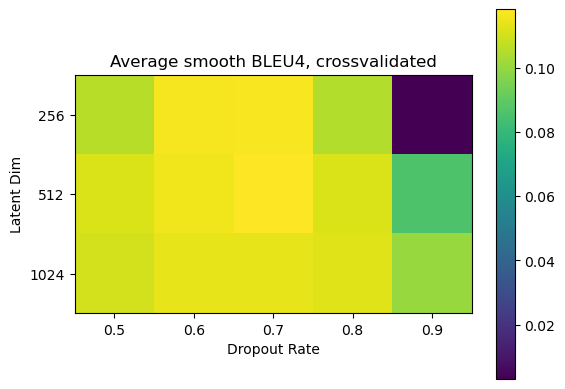

In [14]:
plt.title('Average smooth BLEU4, crossvalidated')
plt.xlabel('Dropout Rate')
plt.xticks(range(len(dropout_rates)), dropout_rates)
plt.ylabel('Latent Dim')
plt.yticks(range(len(latent_dims)),latent_dims)
plt.imshow(average_bleu4)
plt.colorbar()
plt.show()

In [15]:
best_config_index = np.unravel_index(np.argmax(average_bleu4), average_bleu4.shape)
best_latent_dim = latent_dims[best_config_index[0]]
best_dropout_rate = dropout_rates[best_config_index[1]]
print("Best latent dimension: ", best_latent_dim)
print("Best dropout rate: ", best_dropout_rate)

Best latent dimension:  512
Best dropout rate:  0.7


### Optimizacija learning rate-a

Nakon sto smo odredili optimalnu vrednost za dropout_rate i latent_dim, takodje unkarsnom validacijom optimizujemo vrednost posebnog learning rate-a za Embedding slojeve. Learning_rate_multiplier predstavlja odnos izmedju learning rate-a Embedding slojeva i learning rate-a ostalih slojeva.

In [16]:
learning_rate_multipliers = [0.03, 0.1, 0.3, 1, 3, 10, 30]
best_epoch_array = []
bleu4_array = []
for i in range(len(learning_rate_multipliers)):
    df_np = df_train_val.to_numpy()
    np.random.shuffle(df_np)
    total_size = df_np.shape[0]
    fold_size = total_size/folds
    df_folds = [df_np[int(i*fold_size):int((i+1)*fold_size),] for i in range(folds)]
    best_epochs, _, _, smooth_bleu4s, _, _, _ = cv_evaluate(df_train_val, df_folds, folds = folds, epochs = 200, learning_rate = learning_rate, embedding_learning_rate = learning_rate_multipliers[i]*learning_rate, latent_dim = best_latent_dim, dropout_rate = best_dropout_rate)
    best_epoch_array.append(best_epochs)
    bleu4_array.append(smooth_bleu4s)

Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 1/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  0.03
Epoch 1/200
54/54 [==============================] - 26s 214ms/step - loss: 0.8970 - acc: 0.1484 - val_loss: 0.7318 - val_acc: 0.2358
Epoch 2/200
54/54 [==============================] - 3s 59ms/step - loss: 0.7602 - acc: 0.2189 - val_loss: 0.6801 - val_acc: 0.2640
Epoch 3/200
54/54 [==============================] - 3s 58ms/step - loss: 0.7178 - acc: 0.2487 - val_loss: 0.6449 - val_acc: 0.2867
Epoch 4/200
54/54 [==============================] - 3s 59ms/step - loss: 0.6802 - acc: 0.2734 - val_loss: 0.6082 - val_acc: 0.3104
Epoch 5/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6517 - acc: 0.2868 - val_loss: 0.5887 - val_acc: 0.3237
Epoch 6/200
54/54 [==============================] - 3s 59ms/step - loss: 0.6311 - acc: 0.2983 - val_loss: 0.5778 - val_acc: 0.3230
Epoch 7/200
54/54 [==============================] - 3s 59ms/step

54/54 [==============================] - 3s 59ms/step - loss: 0.4469 - acc: 0.4133 - val_loss: 0.4530 - val_acc: 0.4345
Epoch 41/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4439 - acc: 0.4165 - val_loss: 0.4515 - val_acc: 0.4367
Epoch 42/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4411 - acc: 0.4189 - val_loss: 0.4533 - val_acc: 0.4357
Epoch 43/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4382 - acc: 0.4240 - val_loss: 0.4504 - val_acc: 0.4402
Epoch 44/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4362 - acc: 0.4212 - val_loss: 0.4483 - val_acc: 0.4416
Epoch 45/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4339 - acc: 0.4242 - val_loss: 0.4467 - val_acc: 0.4418
Epoch 46/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4306 - acc: 0.4282 - val_loss: 0.4482 - val_acc: 0.4414
Epoch 47/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4289 

Epoch 86/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3460 - acc: 0.4982 - val_loss: 0.4598 - val_acc: 0.4505
Epoch 87/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3428 - acc: 0.5023 - val_loss: 0.4616 - val_acc: 0.4501
Epoch 87: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 4/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  0.03
Epoch 1/200
54/54 [==============================] - 26s 214ms/step - loss: 0.8924 - acc: 0.1494 - val_loss: 0.7375 - val_acc: 0.2395
Epoch 2/200
54/54 [==============================] - 3s 58ms/step - loss: 0.7555 - acc: 0.2216 - val_loss: 0.6898 - val_acc: 0.2651
Epoch 3/200
54/54 [==============================] - 3s 58ms/step - loss: 0.7117 - acc: 0.2508 - val_loss: 0.6559 - val_acc: 0.2878
Epoch 4/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6757 - acc: 0.2715 - val_loss: 0.6223 - val_acc: 0.3080
Epoch 5/200
54/54 [===================

54/54 [==============================] - 3s 58ms/step - loss: 0.4534 - acc: 0.4076 - val_loss: 0.4668 - val_acc: 0.4284
Epoch 39/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4495 - acc: 0.4106 - val_loss: 0.4652 - val_acc: 0.4312
Epoch 40/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4480 - acc: 0.4119 - val_loss: 0.4631 - val_acc: 0.4339
Epoch 41/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4439 - acc: 0.4148 - val_loss: 0.4620 - val_acc: 0.4328
Epoch 42/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4421 - acc: 0.4163 - val_loss: 0.4653 - val_acc: 0.4337
Epoch 43/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4394 - acc: 0.4185 - val_loss: 0.4610 - val_acc: 0.4366
Epoch 44/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4366 - acc: 0.4203 - val_loss: 0.4586 - val_acc: 0.4389
Epoch 45/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4343 

Epoch 78/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3648 - acc: 0.4820 - val_loss: 0.4341 - val_acc: 0.4583
Epoch 79/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3621 - acc: 0.4860 - val_loss: 0.4363 - val_acc: 0.4558
Epoch 80/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3598 - acc: 0.4858 - val_loss: 0.4374 - val_acc: 0.4605
Epoch 81/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3569 - acc: 0.4898 - val_loss: 0.4351 - val_acc: 0.4599
Epoch 82/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3565 - acc: 0.4891 - val_loss: 0.4349 - val_acc: 0.4617
Epoch 82: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 7/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  0.03
Epoch 1/200
54/54 [==============================] - 27s 216ms/step - loss: 0.8939 - acc: 0.1487 - val_loss: 0.7315 - val_acc: 0.2370
Epoch 2/200
54/54 [================

54/54 [==============================] - 3s 59ms/step - loss: 0.4865 - acc: 0.3852 - val_loss: 0.4506 - val_acc: 0.4161
Epoch 29/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4836 - acc: 0.3869 - val_loss: 0.4490 - val_acc: 0.4206
Epoch 30/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4796 - acc: 0.3879 - val_loss: 0.4439 - val_acc: 0.4234
Epoch 31/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4763 - acc: 0.3927 - val_loss: 0.4428 - val_acc: 0.4252
Epoch 32/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4733 - acc: 0.3931 - val_loss: 0.4416 - val_acc: 0.4250
Epoch 33/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4698 - acc: 0.3982 - val_loss: 0.4383 - val_acc: 0.4306
Epoch 34/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4670 - acc: 0.3998 - val_loss: 0.4366 - val_acc: 0.4290
Epoch 35/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4629 

Epoch 66/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3893 - acc: 0.4607 - val_loss: 0.4162 - val_acc: 0.4616
Epoch 67/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3863 - acc: 0.4636 - val_loss: 0.4160 - val_acc: 0.4610
Epoch 68/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3838 - acc: 0.4671 - val_loss: 0.4159 - val_acc: 0.4642
Epoch 69/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3822 - acc: 0.4663 - val_loss: 0.4166 - val_acc: 0.4631
Epoch 70/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3797 - acc: 0.4701 - val_loss: 0.4162 - val_acc: 0.4649
Epoch 71/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3780 - acc: 0.4705 - val_loss: 0.4182 - val_acc: 0.4617
Epoch 72/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3760 - acc: 0.4729 - val_loss: 0.4166 - val_acc: 0.4637
Epoch 73/200
54/54 [==============================] - 3s 57ms/step - 

54/54 [==============================] - 3s 57ms/step - loss: 0.5696 - acc: 0.3295 - val_loss: 0.5298 - val_acc: 0.3660
Epoch 12/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5608 - acc: 0.3358 - val_loss: 0.5256 - val_acc: 0.3712
Epoch 13/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5552 - acc: 0.3387 - val_loss: 0.5171 - val_acc: 0.3785
Epoch 14/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5477 - acc: 0.3434 - val_loss: 0.5147 - val_acc: 0.3804
Epoch 15/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5404 - acc: 0.3473 - val_loss: 0.5103 - val_acc: 0.3841
Epoch 16/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5360 - acc: 0.3516 - val_loss: 0.5026 - val_acc: 0.3876
Epoch 17/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5303 - acc: 0.3537 - val_loss: 0.5030 - val_acc: 0.3937
Epoch 18/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5242 

Epoch 73/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3695 - acc: 0.4787 - val_loss: 0.4350 - val_acc: 0.4589
Epoch 74/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3690 - acc: 0.4782 - val_loss: 0.4366 - val_acc: 0.4615
Epoch 75/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3666 - acc: 0.4813 - val_loss: 0.4349 - val_acc: 0.4585
Epoch 76/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3635 - acc: 0.4865 - val_loss: 0.4329 - val_acc: 0.4603
Epoch 77/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3620 - acc: 0.4869 - val_loss: 0.4374 - val_acc: 0.4582
Epoch 78/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3605 - acc: 0.4870 - val_loss: 0.4348 - val_acc: 0.4582
Epoch 79/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3567 - acc: 0.4917 - val_loss: 0.4352 - val_acc: 0.4560
Epoch 80/200
54/54 [==============================] - 3s 57ms/step - 

54/54 [==============================] - 3s 58ms/step - loss: 0.4907 - acc: 0.3833 - val_loss: 0.4688 - val_acc: 0.4056
Epoch 27/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4860 - acc: 0.3864 - val_loss: 0.4643 - val_acc: 0.4106
Epoch 28/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4835 - acc: 0.3878 - val_loss: 0.4636 - val_acc: 0.4112
Epoch 29/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4792 - acc: 0.3914 - val_loss: 0.4621 - val_acc: 0.4131
Epoch 30/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4765 - acc: 0.3934 - val_loss: 0.4584 - val_acc: 0.4151
Epoch 31/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4731 - acc: 0.3945 - val_loss: 0.4567 - val_acc: 0.4185
Epoch 32/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4701 - acc: 0.3976 - val_loss: 0.4565 - val_acc: 0.4181
Epoch 33/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4670 

Epoch 65/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3868 - acc: 0.4650 - val_loss: 0.4258 - val_acc: 0.4627
Epoch 66/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3845 - acc: 0.4671 - val_loss: 0.4253 - val_acc: 0.4607
Epoch 67/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3823 - acc: 0.4680 - val_loss: 0.4254 - val_acc: 0.4636
Epoch 68/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3801 - acc: 0.4703 - val_loss: 0.4251 - val_acc: 0.4607
Epoch 69/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3781 - acc: 0.4715 - val_loss: 0.4244 - val_acc: 0.4622
Epoch 70/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3762 - acc: 0.4750 - val_loss: 0.4256 - val_acc: 0.4649
Epoch 71/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3739 - acc: 0.4761 - val_loss: 0.4277 - val_acc: 0.4616
Epoch 72/200
54/54 [==============================] - 3s 58ms/step - 

54/54 [==============================] - 3s 58ms/step - loss: 0.5798 - acc: 0.3260 - val_loss: 0.5144 - val_acc: 0.3627
Epoch 11/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5716 - acc: 0.3299 - val_loss: 0.5094 - val_acc: 0.3650
Epoch 12/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5629 - acc: 0.3343 - val_loss: 0.5015 - val_acc: 0.3748
Epoch 13/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5553 - acc: 0.3409 - val_loss: 0.4982 - val_acc: 0.3770
Epoch 14/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5480 - acc: 0.3433 - val_loss: 0.4940 - val_acc: 0.3804
Epoch 15/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5430 - acc: 0.3471 - val_loss: 0.4888 - val_acc: 0.3878
Epoch 16/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5365 - acc: 0.3525 - val_loss: 0.4840 - val_acc: 0.3896
Epoch 17/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5308 

Epoch 72/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3738 - acc: 0.4759 - val_loss: 0.4165 - val_acc: 0.4680
Epoch 73/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3728 - acc: 0.4768 - val_loss: 0.4166 - val_acc: 0.4686
Epoch 74/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3695 - acc: 0.4787 - val_loss: 0.4193 - val_acc: 0.4678
Epoch 75/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3682 - acc: 0.4809 - val_loss: 0.4176 - val_acc: 0.4671
Epoch 76/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3658 - acc: 0.4825 - val_loss: 0.4181 - val_acc: 0.4667
Epoch 77/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3645 - acc: 0.4837 - val_loss: 0.4183 - val_acc: 0.4659
Epoch 78/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3636 - acc: 0.4866 - val_loss: 0.4187 - val_acc: 0.4688
Epoch 79/200
54/54 [==============================] - 3s 60ms/step - 

54/54 [==============================] - 3s 57ms/step - loss: 0.4976 - acc: 0.3778 - val_loss: 0.4793 - val_acc: 0.4062
Epoch 25/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4940 - acc: 0.3803 - val_loss: 0.4754 - val_acc: 0.4071
Epoch 26/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4909 - acc: 0.3824 - val_loss: 0.4723 - val_acc: 0.4108
Epoch 27/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4867 - acc: 0.3854 - val_loss: 0.4702 - val_acc: 0.4134
Epoch 28/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4828 - acc: 0.3882 - val_loss: 0.4667 - val_acc: 0.4122
Epoch 29/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4794 - acc: 0.3908 - val_loss: 0.4658 - val_acc: 0.4160
Epoch 30/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4766 - acc: 0.3932 - val_loss: 0.4628 - val_acc: 0.4183
Epoch 31/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4726 

Epoch 86/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3461 - acc: 0.5014 - val_loss: 0.4322 - val_acc: 0.4647
Epoch 87/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3438 - acc: 0.5027 - val_loss: 0.4350 - val_acc: 0.4605
Epoch 88/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3407 - acc: 0.5060 - val_loss: 0.4353 - val_acc: 0.4626
Epoch 88: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 9/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  0.1
Epoch 1/200
54/54 [==============================] - 26s 214ms/step - loss: 0.8958 - acc: 0.1501 - val_loss: 0.7420 - val_acc: 0.2345
Epoch 2/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7575 - acc: 0.2182 - val_loss: 0.6931 - val_acc: 0.2551
Epoch 3/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7140 - acc: 0.2495 - val_loss: 0.6566 - val_acc: 0.2788
Epoch 4/200
54/54 [===================

54/54 [==============================] - 3s 57ms/step - loss: 0.4615 - acc: 0.4034 - val_loss: 0.4568 - val_acc: 0.4288
Epoch 35/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4576 - acc: 0.4067 - val_loss: 0.4548 - val_acc: 0.4326
Epoch 36/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4564 - acc: 0.4072 - val_loss: 0.4536 - val_acc: 0.4321
Epoch 37/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4533 - acc: 0.4091 - val_loss: 0.4522 - val_acc: 0.4338
Epoch 38/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4499 - acc: 0.4125 - val_loss: 0.4521 - val_acc: 0.4345
Epoch 39/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4472 - acc: 0.4131 - val_loss: 0.4489 - val_acc: 0.4379
Epoch 40/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4443 - acc: 0.4170 - val_loss: 0.4478 - val_acc: 0.4382
Epoch 41/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4419 

Epoch 70/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3728 - acc: 0.4777 - val_loss: 0.4342 - val_acc: 0.4552
Epoch 71/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3695 - acc: 0.4816 - val_loss: 0.4320 - val_acc: 0.4563
Epoch 72/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3677 - acc: 0.4817 - val_loss: 0.4330 - val_acc: 0.4572
Epoch 73/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3657 - acc: 0.4836 - val_loss: 0.4334 - val_acc: 0.4580
Epoch 74/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3639 - acc: 0.4867 - val_loss: 0.4337 - val_acc: 0.4555
Epoch 75/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3612 - acc: 0.4882 - val_loss: 0.4352 - val_acc: 0.4557
Epoch 76/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3603 - acc: 0.4882 - val_loss: 0.4329 - val_acc: 0.4577
Epoch 77/200
54/54 [==============================] - 3s 58ms/step - 

54/54 [==============================] - 3s 57ms/step - loss: 0.4929 - acc: 0.3813 - val_loss: 0.4828 - val_acc: 0.4021
Epoch 25/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4892 - acc: 0.3826 - val_loss: 0.4805 - val_acc: 0.4056
Epoch 26/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4859 - acc: 0.3841 - val_loss: 0.4777 - val_acc: 0.4079
Epoch 27/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4819 - acc: 0.3894 - val_loss: 0.4763 - val_acc: 0.4095
Epoch 28/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4779 - acc: 0.3902 - val_loss: 0.4737 - val_acc: 0.4112
Epoch 29/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4750 - acc: 0.3915 - val_loss: 0.4717 - val_acc: 0.4127
Epoch 30/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4717 - acc: 0.3957 - val_loss: 0.4720 - val_acc: 0.4171
Epoch 31/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4676 

54/54 [==============================] - 3s 58ms/step - loss: 0.3664 - acc: 0.4816 - val_loss: 0.4169 - val_acc: 0.4759
Epoch 73: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 5/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  0.3
Epoch 1/200
54/54 [==============================] - 26s 209ms/step - loss: 0.8951 - acc: 0.1504 - val_loss: 0.7203 - val_acc: 0.2326
Epoch 2/200
54/54 [==============================] - 3s 59ms/step - loss: 0.7577 - acc: 0.2173 - val_loss: 0.6690 - val_acc: 0.2732
Epoch 3/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7156 - acc: 0.2464 - val_loss: 0.6335 - val_acc: 0.2951
Epoch 4/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6785 - acc: 0.2712 - val_loss: 0.5990 - val_acc: 0.3226
Epoch 5/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6479 - acc: 0.2886 - val_loss: 0.5818 - val_acc: 0.3287
Epoch 6/200
54/54 [==============================] - 

54/54 [==============================] - 3s 57ms/step - loss: 0.4627 - acc: 0.4017 - val_loss: 0.4564 - val_acc: 0.4309
Epoch 34/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4600 - acc: 0.4065 - val_loss: 0.4550 - val_acc: 0.4298
Epoch 35/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4566 - acc: 0.4083 - val_loss: 0.4493 - val_acc: 0.4333
Epoch 36/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4528 - acc: 0.4100 - val_loss: 0.4512 - val_acc: 0.4359
Epoch 37/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4511 - acc: 0.4117 - val_loss: 0.4476 - val_acc: 0.4366
Epoch 38/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4485 - acc: 0.4151 - val_loss: 0.4487 - val_acc: 0.4397
Epoch 39/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4450 - acc: 0.4157 - val_loss: 0.4492 - val_acc: 0.4388
Epoch 40/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4417 

Epoch 63/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3837 - acc: 0.4673 - val_loss: 0.4555 - val_acc: 0.4498
Epoch 64/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3815 - acc: 0.4694 - val_loss: 0.4548 - val_acc: 0.4481
Epoch 65/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3787 - acc: 0.4728 - val_loss: 0.4540 - val_acc: 0.4465
Epoch 66/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3785 - acc: 0.4746 - val_loss: 0.4545 - val_acc: 0.4501
Epoch 67/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3754 - acc: 0.4734 - val_loss: 0.4520 - val_acc: 0.4484
Epoch 68/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3728 - acc: 0.4772 - val_loss: 0.4538 - val_acc: 0.4484
Epoch 69/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3713 - acc: 0.4783 - val_loss: 0.4517 - val_acc: 0.4512
Epoch 70/200
54/54 [==============================] - 3s 58ms/step - 

54/54 [==============================] - 3s 58ms/step - loss: 0.5273 - acc: 0.3586 - val_loss: 0.4943 - val_acc: 0.3897
Epoch 18/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5215 - acc: 0.3628 - val_loss: 0.4900 - val_acc: 0.3932
Epoch 19/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5164 - acc: 0.3632 - val_loss: 0.4852 - val_acc: 0.4008
Epoch 20/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5114 - acc: 0.3685 - val_loss: 0.4838 - val_acc: 0.3981
Epoch 21/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5074 - acc: 0.3713 - val_loss: 0.4801 - val_acc: 0.4033
Epoch 22/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5029 - acc: 0.3738 - val_loss: 0.4756 - val_acc: 0.4051
Epoch 23/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4986 - acc: 0.3780 - val_loss: 0.4738 - val_acc: 0.4051
Epoch 24/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4946 

Epoch 79/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3536 - acc: 0.4947 - val_loss: 0.4276 - val_acc: 0.4681
Epoch 80/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3522 - acc: 0.4966 - val_loss: 0.4267 - val_acc: 0.4689
Epoch 81/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3494 - acc: 0.5004 - val_loss: 0.4271 - val_acc: 0.4686
Epoch 82/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3479 - acc: 0.4998 - val_loss: 0.4266 - val_acc: 0.4667
Epoch 82: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 10/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  0.3
Epoch 1/200
54/54 [==============================] - 27s 223ms/step - loss: 0.8945 - acc: 0.1468 - val_loss: 0.7229 - val_acc: 0.2368
Epoch 2/200
54/54 [==============================] - 3s 58ms/step - loss: 0.7596 - acc: 0.2185 - val_loss: 0.6727 - val_acc: 0.2647
Epoch 3/200
54/54 [=================

54/54 [==============================] - 3s 59ms/step - loss: 0.4404 - acc: 0.4232 - val_loss: 0.4225 - val_acc: 0.4537
Epoch 39/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4358 - acc: 0.4285 - val_loss: 0.4219 - val_acc: 0.4535
Epoch 40/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4335 - acc: 0.4305 - val_loss: 0.4211 - val_acc: 0.4552
Epoch 41/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4314 - acc: 0.4318 - val_loss: 0.4191 - val_acc: 0.4543
Epoch 42/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4286 - acc: 0.4341 - val_loss: 0.4189 - val_acc: 0.4540
Epoch 43/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4252 - acc: 0.4382 - val_loss: 0.4179 - val_acc: 0.4578
Epoch 44/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4233 - acc: 0.4388 - val_loss: 0.4184 - val_acc: 0.4598
Epoch 45/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4202 

Epoch 83/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3307 - acc: 0.5204 - val_loss: 0.4277 - val_acc: 0.4714
Epoch 83: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 3/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Epoch 1/200
54/54 [==============================] - 26s 213ms/step - loss: 0.8907 - acc: 0.1518 - val_loss: 0.7416 - val_acc: 0.2404
Epoch 2/200
54/54 [==============================] - 3s 60ms/step - loss: 0.7531 - acc: 0.2216 - val_loss: 0.6840 - val_acc: 0.2704
Epoch 3/200
54/54 [==============================] - 3s 59ms/step - loss: 0.7067 - acc: 0.2520 - val_loss: 0.6436 - val_acc: 0.3009
Epoch 4/200
54/54 [==============================] - 3s 59ms/step - loss: 0.6680 - acc: 0.2781 - val_loss: 0.6114 - val_acc: 0.3201
Epoch 5/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6385 - acc: 0.2969 - val_loss: 0.5896 - val_acc: 0.3315
Epoch 6/200
54/54 [=====================

54/54 [==============================] - 3s 59ms/step - loss: 0.4324 - acc: 0.4288 - val_loss: 0.4470 - val_acc: 0.4459
Epoch 41/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4294 - acc: 0.4317 - val_loss: 0.4461 - val_acc: 0.4475
Epoch 42/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4270 - acc: 0.4335 - val_loss: 0.4437 - val_acc: 0.4487
Epoch 43/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4243 - acc: 0.4369 - val_loss: 0.4442 - val_acc: 0.4487
Epoch 44/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4209 - acc: 0.4380 - val_loss: 0.4436 - val_acc: 0.4493
Epoch 45/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4187 - acc: 0.4420 - val_loss: 0.4443 - val_acc: 0.4495
Epoch 46/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4159 - acc: 0.4429 - val_loss: 0.4397 - val_acc: 0.4544
Epoch 47/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4138 

Epoch 74/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3505 - acc: 0.5004 - val_loss: 0.4282 - val_acc: 0.4676
Epoch 75/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3487 - acc: 0.5020 - val_loss: 0.4278 - val_acc: 0.4677
Epoch 76/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3478 - acc: 0.5026 - val_loss: 0.4292 - val_acc: 0.4644
Epoch 77/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3451 - acc: 0.5082 - val_loss: 0.4301 - val_acc: 0.4677
Epoch 78/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3443 - acc: 0.5080 - val_loss: 0.4287 - val_acc: 0.4646
Epoch 79/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3405 - acc: 0.5101 - val_loss: 0.4287 - val_acc: 0.4650
Epoch 80/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3395 - acc: 0.5116 - val_loss: 0.4287 - val_acc: 0.4660
Epoch 81/200
54/54 [==============================] - 3s 58ms/step - 

54/54 [==============================] - 3s 58ms/step - loss: 0.4628 - acc: 0.4033 - val_loss: 0.4658 - val_acc: 0.4268
Epoch 31/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4602 - acc: 0.4050 - val_loss: 0.4620 - val_acc: 0.4306
Epoch 32/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4567 - acc: 0.4097 - val_loss: 0.4646 - val_acc: 0.4314
Epoch 33/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4526 - acc: 0.4097 - val_loss: 0.4597 - val_acc: 0.4367
Epoch 34/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4498 - acc: 0.4132 - val_loss: 0.4558 - val_acc: 0.4380
Epoch 35/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4464 - acc: 0.4163 - val_loss: 0.4566 - val_acc: 0.4392
Epoch 36/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4431 - acc: 0.4195 - val_loss: 0.4535 - val_acc: 0.4435
Epoch 37/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4402 

Epoch 77/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3437 - acc: 0.5080 - val_loss: 0.4214 - val_acc: 0.4724
Epoch 78/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3418 - acc: 0.5089 - val_loss: 0.4202 - val_acc: 0.4757
Epoch 79/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3397 - acc: 0.5122 - val_loss: 0.4199 - val_acc: 0.4761
Epoch 80/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3376 - acc: 0.5138 - val_loss: 0.4204 - val_acc: 0.4774
Epoch 81/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3359 - acc: 0.5147 - val_loss: 0.4203 - val_acc: 0.4782
Epoch 82/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3334 - acc: 0.5165 - val_loss: 0.4213 - val_acc: 0.4754
Epoch 83/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3312 - acc: 0.5193 - val_loss: 0.4196 - val_acc: 0.4755
Epoch 84/200
54/54 [==============================] - 3s 58ms/step - 

54/54 [==============================] - 3s 58ms/step - loss: 0.4377 - acc: 0.4251 - val_loss: 0.4292 - val_acc: 0.4501
Epoch 40/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4350 - acc: 0.4297 - val_loss: 0.4232 - val_acc: 0.4583
Epoch 41/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4326 - acc: 0.4300 - val_loss: 0.4234 - val_acc: 0.4550
Epoch 42/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4293 - acc: 0.4320 - val_loss: 0.4210 - val_acc: 0.4609
Epoch 43/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4258 - acc: 0.4348 - val_loss: 0.4204 - val_acc: 0.4582
Epoch 44/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4234 - acc: 0.4378 - val_loss: 0.4196 - val_acc: 0.4593
Epoch 45/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4201 - acc: 0.4411 - val_loss: 0.4194 - val_acc: 0.4638
Epoch 46/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4176 

Epoch 1/200
54/54 [==============================] - 27s 218ms/step - loss: 0.8909 - acc: 0.1536 - val_loss: 0.7194 - val_acc: 0.2435
Epoch 2/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7478 - acc: 0.2256 - val_loss: 0.6630 - val_acc: 0.2738
Epoch 3/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7013 - acc: 0.2589 - val_loss: 0.6265 - val_acc: 0.3058
Epoch 4/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6657 - acc: 0.2838 - val_loss: 0.5954 - val_acc: 0.3302
Epoch 5/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6360 - acc: 0.2990 - val_loss: 0.5737 - val_acc: 0.3419
Epoch 6/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6139 - acc: 0.3110 - val_loss: 0.5615 - val_acc: 0.3457
Epoch 7/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5978 - acc: 0.3212 - val_loss: 0.5485 - val_acc: 0.3536
Epoch 8/200
54/54 [==============================] - 3s 58ms/step - loss: 

54/54 [==============================] - 3s 57ms/step - loss: 0.4182 - acc: 0.4449 - val_loss: 0.4332 - val_acc: 0.4560
Epoch 41/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4161 - acc: 0.4476 - val_loss: 0.4293 - val_acc: 0.4570
Epoch 42/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4129 - acc: 0.4485 - val_loss: 0.4283 - val_acc: 0.4583
Epoch 43/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4100 - acc: 0.4533 - val_loss: 0.4268 - val_acc: 0.4605
Epoch 44/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4072 - acc: 0.4545 - val_loss: 0.4248 - val_acc: 0.4599
Epoch 45/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4037 - acc: 0.4585 - val_loss: 0.4250 - val_acc: 0.4639
Epoch 46/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4004 - acc: 0.4618 - val_loss: 0.4237 - val_acc: 0.4635
Epoch 47/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3985 

Epoch 82/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3161 - acc: 0.5391 - val_loss: 0.4112 - val_acc: 0.4887
Epoch 83/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3139 - acc: 0.5415 - val_loss: 0.4090 - val_acc: 0.4874
Epoch 83: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 5/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  3.0
Epoch 1/200
54/54 [==============================] - 26s 212ms/step - loss: 0.8940 - acc: 0.1554 - val_loss: 0.7407 - val_acc: 0.2392
Epoch 2/200
54/54 [==============================] - 3s 59ms/step - loss: 0.7484 - acc: 0.2237 - val_loss: 0.6795 - val_acc: 0.2693
Epoch 3/200
54/54 [==============================] - 3s 59ms/step - loss: 0.7017 - acc: 0.2593 - val_loss: 0.6384 - val_acc: 0.3053
Epoch 4/200
54/54 [==============================] - 3s 60ms/step - loss: 0.6639 - acc: 0.2833 - val_loss: 0.6063 - val_acc: 0.3283
Epoch 5/200
54/54 [====================

54/54 [==============================] - 3s 59ms/step - loss: 0.4304 - acc: 0.4354 - val_loss: 0.4167 - val_acc: 0.4681
Epoch 38/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4274 - acc: 0.4386 - val_loss: 0.4155 - val_acc: 0.4719
Epoch 39/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4239 - acc: 0.4403 - val_loss: 0.4138 - val_acc: 0.4737
Epoch 40/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4203 - acc: 0.4432 - val_loss: 0.4119 - val_acc: 0.4726
Epoch 41/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4177 - acc: 0.4459 - val_loss: 0.4124 - val_acc: 0.4730
Epoch 42/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4143 - acc: 0.4477 - val_loss: 0.4102 - val_acc: 0.4781
Epoch 43/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4110 - acc: 0.4514 - val_loss: 0.4113 - val_acc: 0.4790
Epoch 44/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4094 

Epoch 81: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 8/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  3.0
Epoch 1/200
54/54 [==============================] - 27s 221ms/step - loss: 0.8902 - acc: 0.1503 - val_loss: 0.7288 - val_acc: 0.2387
Epoch 2/200
54/54 [==============================] - 3s 59ms/step - loss: 0.7474 - acc: 0.2267 - val_loss: 0.6681 - val_acc: 0.2756
Epoch 3/200
54/54 [==============================] - 3s 58ms/step - loss: 0.7009 - acc: 0.2611 - val_loss: 0.6340 - val_acc: 0.3002
Epoch 4/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6635 - acc: 0.2844 - val_loss: 0.6012 - val_acc: 0.3245
Epoch 5/200
54/54 [==============================] - 3s 59ms/step - loss: 0.6348 - acc: 0.2998 - val_loss: 0.5809 - val_acc: 0.3347
Epoch 6/200
54/54 [==============================] - 3s 59ms/step - loss: 0.6136 - acc: 0.3124 - val_loss: 0.5659 - val_acc: 0.3397
Epoch 7/200
54/54 [======================

54/54 [==============================] - 3s 57ms/step - loss: 0.4115 - acc: 0.4494 - val_loss: 0.4483 - val_acc: 0.4513
Epoch 43/200
54/54 [==============================] - 3s 60ms/step - loss: 0.4093 - acc: 0.4525 - val_loss: 0.4455 - val_acc: 0.4541
Epoch 44/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4058 - acc: 0.4559 - val_loss: 0.4447 - val_acc: 0.4556
Epoch 45/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4034 - acc: 0.4570 - val_loss: 0.4457 - val_acc: 0.4557
Epoch 46/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3997 - acc: 0.4608 - val_loss: 0.4433 - val_acc: 0.4574
Epoch 47/200
54/54 [==============================] - 3s 60ms/step - loss: 0.3966 - acc: 0.4628 - val_loss: 0.4424 - val_acc: 0.4617
Epoch 48/200
54/54 [==============================] - 3s 63ms/step - loss: 0.3947 - acc: 0.4653 - val_loss: 0.4417 - val_acc: 0.4596
Epoch 49/200
54/54 [==============================] - 3s 62ms/step - loss: 0.3917 

54/54 [==============================] - 3s 58ms/step - loss: 0.5511 - acc: 0.3483 - val_loss: 0.5268 - val_acc: 0.3664
Epoch 11/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5420 - acc: 0.3536 - val_loss: 0.5157 - val_acc: 0.3742
Epoch 12/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5332 - acc: 0.3596 - val_loss: 0.5128 - val_acc: 0.3810
Epoch 13/200
54/54 [==============================] - 3s 60ms/step - loss: 0.5254 - acc: 0.3630 - val_loss: 0.5076 - val_acc: 0.3836
Epoch 14/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5174 - acc: 0.3687 - val_loss: 0.4992 - val_acc: 0.3954
Epoch 15/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5104 - acc: 0.3747 - val_loss: 0.4950 - val_acc: 0.3981
Epoch 16/200
54/54 [==============================] - 3s 59ms/step - loss: 0.5032 - acc: 0.3796 - val_loss: 0.4904 - val_acc: 0.4022
Epoch 17/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4964 

Epoch 66/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3268 - acc: 0.5323 - val_loss: 0.4048 - val_acc: 0.4897
Epoch 67/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3243 - acc: 0.5342 - val_loss: 0.4054 - val_acc: 0.4931
Epoch 68/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3219 - acc: 0.5381 - val_loss: 0.4050 - val_acc: 0.4944
Epoch 69/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3194 - acc: 0.5388 - val_loss: 0.4053 - val_acc: 0.4964
Epoch 70/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3162 - acc: 0.5420 - val_loss: 0.4070 - val_acc: 0.4951
Epoch 71/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3141 - acc: 0.5434 - val_loss: 0.4061 - val_acc: 0.4933
Epoch 71: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 3/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  10.0
Epoch 1/200
54/54 [=================

54/54 [==============================] - 3s 55ms/step - loss: 0.4065 - acc: 0.4583 - val_loss: 0.4271 - val_acc: 0.4682
Epoch 39/200
54/54 [==============================] - 3s 55ms/step - loss: 0.4022 - acc: 0.4625 - val_loss: 0.4267 - val_acc: 0.4699
Epoch 40/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3988 - acc: 0.4658 - val_loss: 0.4254 - val_acc: 0.4664
Epoch 41/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3969 - acc: 0.4666 - val_loss: 0.4212 - val_acc: 0.4722
Epoch 42/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3945 - acc: 0.4708 - val_loss: 0.4207 - val_acc: 0.4725
Epoch 43/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3897 - acc: 0.4743 - val_loss: 0.4199 - val_acc: 0.4737
Epoch 44/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3869 - acc: 0.4746 - val_loss: 0.4196 - val_acc: 0.4750
Epoch 45/200
54/54 [==============================] - 3s 55ms/step - loss: 0.3838 

54/54 [==============================] - 3s 57ms/step - loss: 0.5257 - acc: 0.3641 - val_loss: 0.4986 - val_acc: 0.3900
Epoch 14/200
54/54 [==============================] - 3s 56ms/step - loss: 0.5179 - acc: 0.3686 - val_loss: 0.4962 - val_acc: 0.3975
Epoch 15/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5115 - acc: 0.3734 - val_loss: 0.4916 - val_acc: 0.4006
Epoch 16/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5042 - acc: 0.3799 - val_loss: 0.4876 - val_acc: 0.3985
Epoch 17/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4987 - acc: 0.3827 - val_loss: 0.4828 - val_acc: 0.4065
Epoch 18/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4928 - acc: 0.3881 - val_loss: 0.4772 - val_acc: 0.4179
Epoch 19/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4864 - acc: 0.3940 - val_loss: 0.4745 - val_acc: 0.4198
Epoch 20/200
54/54 [==============================] - 3s 57ms/step - loss: 0.4805 

Epoch 64/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3303 - acc: 0.5283 - val_loss: 0.4132 - val_acc: 0.4945
Epoch 65/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3277 - acc: 0.5300 - val_loss: 0.4120 - val_acc: 0.4944
Epoch 66/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3253 - acc: 0.5308 - val_loss: 0.4081 - val_acc: 0.4961
Epoch 67/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3221 - acc: 0.5366 - val_loss: 0.4089 - val_acc: 0.4917
Epoch 68/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3197 - acc: 0.5391 - val_loss: 0.4099 - val_acc: 0.4977
Epoch 69/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3174 - acc: 0.5412 - val_loss: 0.4093 - val_acc: 0.4953
Epoch 70/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3154 - acc: 0.5435 - val_loss: 0.4078 - val_acc: 0.4972
Epoch 71/200
54/54 [==============================] - 3s 57ms/step - 

54/54 [==============================] - 3s 63ms/step - loss: 0.4464 - acc: 0.4252 - val_loss: 0.4316 - val_acc: 0.4516
Epoch 28/200
54/54 [==============================] - 3s 63ms/step - loss: 0.4429 - acc: 0.4296 - val_loss: 0.4307 - val_acc: 0.4572
Epoch 29/200
54/54 [==============================] - 3s 63ms/step - loss: 0.4395 - acc: 0.4328 - val_loss: 0.4281 - val_acc: 0.4592
Epoch 30/200
54/54 [==============================] - 3s 63ms/step - loss: 0.4352 - acc: 0.4364 - val_loss: 0.4253 - val_acc: 0.4579
Epoch 31/200
54/54 [==============================] - 3s 63ms/step - loss: 0.4315 - acc: 0.4404 - val_loss: 0.4243 - val_acc: 0.4656
Epoch 32/200
54/54 [==============================] - 3s 63ms/step - loss: 0.4270 - acc: 0.4431 - val_loss: 0.4235 - val_acc: 0.4648
Epoch 33/200
54/54 [==============================] - 3s 63ms/step - loss: 0.4236 - acc: 0.4434 - val_loss: 0.4217 - val_acc: 0.4648
Epoch 34/200
54/54 [==============================] - 3s 64ms/step - loss: 0.4206 

54/54 [==============================] - 3s 58ms/step - loss: 0.7238 - acc: 0.2486 - val_loss: 0.6390 - val_acc: 0.3063
Epoch 3/200
54/54 [==============================] - 3s 58ms/step - loss: 0.6765 - acc: 0.2835 - val_loss: 0.5990 - val_acc: 0.3260
Epoch 4/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6395 - acc: 0.3043 - val_loss: 0.5725 - val_acc: 0.3417
Epoch 5/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6113 - acc: 0.3193 - val_loss: 0.5459 - val_acc: 0.3533
Epoch 6/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5892 - acc: 0.3306 - val_loss: 0.5361 - val_acc: 0.3612
Epoch 7/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5733 - acc: 0.3390 - val_loss: 0.5246 - val_acc: 0.3691
Epoch 8/200
54/54 [==============================] - 3s 58ms/step - loss: 0.5590 - acc: 0.3453 - val_loss: 0.5171 - val_acc: 0.3770
Epoch 9/200
54/54 [==============================] - 3s 57ms/step - loss: 0.5472 - acc: 

Epoch 64/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3149 - acc: 0.5485 - val_loss: 0.4146 - val_acc: 0.4866
Epoch 65/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3110 - acc: 0.5500 - val_loss: 0.4131 - val_acc: 0.4865
Epoch 66/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3099 - acc: 0.5523 - val_loss: 0.4133 - val_acc: 0.4905
Epoch 66: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 2/10
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  30.0
Epoch 1/200
54/54 [==============================] - 27s 222ms/step - loss: 0.8726 - acc: 0.1698 - val_loss: 0.7134 - val_acc: 0.2470
Epoch 2/200
54/54 [==============================] - 3s 57ms/step - loss: 0.7207 - acc: 0.2511 - val_loss: 0.6498 - val_acc: 0.3012
Epoch 3/200
54/54 [==============================] - 3s 57ms/step - loss: 0.6729 - acc: 0.2827 - val_loss: 0.6137 - val_acc: 0.3224
Epoch 4/200
54/54 [==================

54/54 [==============================] - 3s 60ms/step - loss: 0.3913 - acc: 0.4770 - val_loss: 0.4221 - val_acc: 0.4688
Epoch 38/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3875 - acc: 0.4773 - val_loss: 0.4217 - val_acc: 0.4684
Epoch 39/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3849 - acc: 0.4805 - val_loss: 0.4219 - val_acc: 0.4711
Epoch 40/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3818 - acc: 0.4851 - val_loss: 0.4202 - val_acc: 0.4758
Epoch 41/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3782 - acc: 0.4880 - val_loss: 0.4195 - val_acc: 0.4746
Epoch 42/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3756 - acc: 0.4890 - val_loss: 0.4180 - val_acc: 0.4770
Epoch 43/200
54/54 [==============================] - 3s 56ms/step - loss: 0.3717 - acc: 0.4934 - val_loss: 0.4182 - val_acc: 0.4783
Epoch 44/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3694 

54/54 [==============================] - 3s 61ms/step - loss: 0.5355 - acc: 0.3592 - val_loss: 0.5169 - val_acc: 0.3793
Epoch 11/200
54/54 [==============================] - 3s 62ms/step - loss: 0.5267 - acc: 0.3662 - val_loss: 0.5115 - val_acc: 0.3847
Epoch 12/200
54/54 [==============================] - 3s 62ms/step - loss: 0.5176 - acc: 0.3721 - val_loss: 0.5048 - val_acc: 0.3888
Epoch 13/200
54/54 [==============================] - 3s 61ms/step - loss: 0.5092 - acc: 0.3773 - val_loss: 0.4988 - val_acc: 0.3934
Epoch 14/200
54/54 [==============================] - 3s 61ms/step - loss: 0.5009 - acc: 0.3854 - val_loss: 0.4940 - val_acc: 0.3997
Epoch 15/200
54/54 [==============================] - 3s 62ms/step - loss: 0.4948 - acc: 0.3891 - val_loss: 0.4884 - val_acc: 0.4044
Epoch 16/200
54/54 [==============================] - 3s 62ms/step - loss: 0.4872 - acc: 0.3965 - val_loss: 0.4847 - val_acc: 0.4115
Epoch 17/200
54/54 [==============================] - 3s 62ms/step - loss: 0.4802 

Epoch 1/200
54/54 [==============================] - 26s 213ms/step - loss: 0.8707 - acc: 0.1743 - val_loss: 0.7058 - val_acc: 0.2513
Epoch 2/200
54/54 [==============================] - 3s 56ms/step - loss: 0.7225 - acc: 0.2496 - val_loss: 0.6443 - val_acc: 0.3048
Epoch 3/200
54/54 [==============================] - 3s 56ms/step - loss: 0.6770 - acc: 0.2804 - val_loss: 0.6076 - val_acc: 0.3316
Epoch 4/200
54/54 [==============================] - 3s 56ms/step - loss: 0.6406 - acc: 0.3014 - val_loss: 0.5769 - val_acc: 0.3452
Epoch 5/200
54/54 [==============================] - 3s 56ms/step - loss: 0.6117 - acc: 0.3173 - val_loss: 0.5529 - val_acc: 0.3594
Epoch 6/200
54/54 [==============================] - 3s 56ms/step - loss: 0.5906 - acc: 0.3284 - val_loss: 0.5376 - val_acc: 0.3674
Epoch 7/200
54/54 [==============================] - 3s 56ms/step - loss: 0.5750 - acc: 0.3365 - val_loss: 0.5274 - val_acc: 0.3734
Epoch 8/200
54/54 [==============================] - 3s 56ms/step - loss: 

54/54 [==============================] - 3s 58ms/step - loss: 0.3503 - acc: 0.5139 - val_loss: 0.4341 - val_acc: 0.4768
Epoch 51/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3473 - acc: 0.5155 - val_loss: 0.4348 - val_acc: 0.4757
Epoch 52/200
54/54 [==============================] - 3s 59ms/step - loss: 0.3446 - acc: 0.5167 - val_loss: 0.4335 - val_acc: 0.4783
Epoch 53/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3406 - acc: 0.5203 - val_loss: 0.4341 - val_acc: 0.4747
Epoch 54/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3396 - acc: 0.5207 - val_loss: 0.4350 - val_acc: 0.4784
Epoch 55/200
54/54 [==============================] - 3s 57ms/step - loss: 0.3354 - acc: 0.5263 - val_loss: 0.4347 - val_acc: 0.4826
Epoch 56/200
54/54 [==============================] - 3s 58ms/step - loss: 0.3330 - acc: 0.5279 - val_loss: 0.4332 - val_acc: 0.4832
Epoch 57/200
54/54 [==============================] - 3s 60ms/step - loss: 0.3304 

54/54 [==============================] - 3s 59ms/step - loss: 0.4142 - acc: 0.4553 - val_loss: 0.4428 - val_acc: 0.4595
Epoch 32/200
54/54 [==============================] - 3s 58ms/step - loss: 0.4102 - acc: 0.4574 - val_loss: 0.4422 - val_acc: 0.4604
Epoch 33/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4065 - acc: 0.4606 - val_loss: 0.4404 - val_acc: 0.4632
Epoch 34/200
54/54 [==============================] - 3s 59ms/step - loss: 0.4025 - acc: 0.4643 - val_loss: 0.4394 - val_acc: 0.4652
Epoch 35/200
54/54 [==============================] - 3s 60ms/step - loss: 0.3994 - acc: 0.4661 - val_loss: 0.4368 - val_acc: 0.4680
Epoch 36/200
54/54 [==============================] - 3s 61ms/step - loss: 0.3947 - acc: 0.4733 - val_loss: 0.4378 - val_acc: 0.4675
Epoch 37/200
54/54 [==============================] - 3s 61ms/step - loss: 0.3922 - acc: 0.4742 - val_loss: 0.4350 - val_acc: 0.4754
Epoch 38/200
54/54 [==============================] - 3s 60ms/step - loss: 0.3879 

In [17]:
bleu4_array = np.array(bleu4_array)
best_epoch_array = np.array(best_epoch_array)
best_multiplier_index = np.argmax(np.mean(bleu4_array, -1))
bleu4_avg = np.mean(bleu4_array[best_multiplier_index])
print("Average BLEU4(smooth) on validation: ", bleu4_avg)
best_multiplier = learning_rate_multipliers[best_multiplier_index]
print("Best Multiplier for Embedding Learning Rates:", best_multiplier)
best_multiplier_epochs = best_epoch_array[best_multiplier_index]
print('Epochs to convergence on all folds: ', best_multiplier_epochs) 
epoch_avg = np.mean(best_multiplier_epochs)

Average BLEU4(smooth) on validation:  0.13396938152944704
Best Multiplier for Embedding Learning Rates: 30
Epochs to convergence on all folds:  [56 69 62 63 59 61 56 61 62 61]


Iznenadjujuce dobijamo visoku vrednost za learning_rate_multiplier, kada smo ocekivali vrednost manju od 1. Posto je optimalna vrednost maksimalna moguca, trebalo bi ponoviti eksperiment sa jos vecim vrednostima hiperparametra.

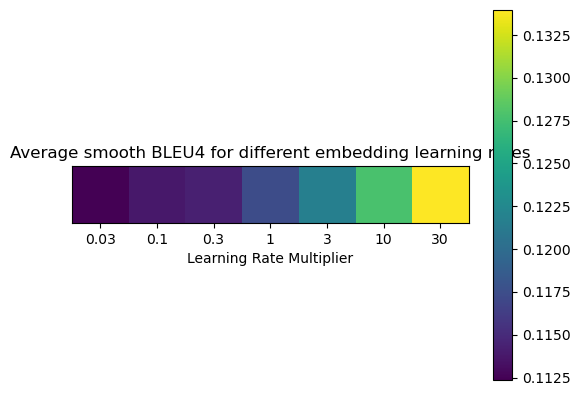

In [18]:
plt.title('Average smooth BLEU4 for different embedding learning rates')
plt.xlabel('Learning Rate Multiplier')
plt.yticks([])
plt.xticks(range(len(learning_rate_multipliers)), learning_rate_multipliers)
plt.imshow(np.mean(bleu4_array, axis = 1).reshape(1,-1))
plt.colorbar()
plt.show()

## Finalni model za evaluaciju

Na kraju koristimo kombinovani trening i validacioni skup da istreniramo konacan model za evaluaciju.

Izdvajamo mali deo ovog skupa (300 redova) za validaciju tokom treniranja, da bismo znali kad da prekinemo trening.

In [12]:
df_train_val_np = df_train_val.to_numpy()
np.random.shuffle(df_train_val_np)
split_size = 300 
train_data = df_train_val_np[:train_size + val_size - split_size,]
val_data = df_train_val_np[train_size + val_size - split_size:,]
input_texts, target_texts = clean_texts(train_data[:,1], train_data[:,0])
input_word_index, target_word_index, max_input_seq_len, max_target_seq_len = analyse_texts(input_texts, target_texts)
input_pad_len = 80
target_pad_len = 60
num_input_words = len(input_word_index) - 1
num_target_words = len(target_word_index) - 1
inverted_input_word_index = {value: key for key,value in input_word_index.items()}
inverted_target_word_index = {value: key for (key,value) in target_word_index.items()}
input_embedding_matrix, target_embedding_matrix = load_embedding_data_get_matrices(inverted_input_word_index, inverted_target_word_index)
encoder_input_data, decoder_input_data, decoder_output_data = create_model_data(input_texts, target_texts, input_word_index, target_word_index, input_pad_len, target_pad_len)

input_texts_val, target_texts_val = clean_texts(val_data[:,1], val_data[:,0])
encoder_input_data_val, decoder_input_data_val, decoder_output_data_val = create_model_data(input_texts_val, target_texts_val, input_word_index, target_word_index, input_pad_len, target_pad_len)

input_texts_test, target_texts_test = clean_texts_df(df_test)
encoder_input_data_test, decoder_input_data_test, decoder_output_data_test = create_model_data(input_texts_test, target_texts_test, input_word_index, target_word_index, input_pad_len, target_pad_len)

In [13]:
model_for_evaluation = GRU_Translation_Model(num_input_words, num_target_words, input_embedding_matrix, target_embedding_matrix)

other_layers = model_for_evaluation.layers[0].layers + model_for_evaluation.layers[1].layers 
embedding_layers = [other_layers.pop(2), other_layers.pop(-9)] 
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers = [(Adam(learning_rate), other_layers), (Adam(best_multiplier*learning_rate), embedding_layers)])
model_for_evaluation.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

early_stopping_safe = EarlyStopping(patience = 20, restore_best_weights = True, monitor = 'val_loss', mode = 'min', verbose = 1)
history = model_for_evaluation.fit([encoder_input_data, decoder_input_data], decoder_output_data, validation_data = ([encoder_input_data_val, decoder_input_data_val], decoder_output_data_val), epochs = 200, batch_size = 128, verbose = 1, callbacks = [early_stopping_safe])

Epoch 1/200
58/58 [==============================] - 69s 648ms/step - loss: 0.8479 - acc: 0.1840 - val_loss: 0.6928 - val_acc: 0.2836
Epoch 2/200
58/58 [==============================] - 21s 369ms/step - loss: 0.6832 - acc: 0.2816 - val_loss: 0.6257 - val_acc: 0.3231
Epoch 3/200
58/58 [==============================] - 21s 358ms/step - loss: 0.6312 - acc: 0.3136 - val_loss: 0.5866 - val_acc: 0.3431
Epoch 4/200
58/58 [==============================] - 21s 355ms/step - loss: 0.5946 - acc: 0.3327 - val_loss: 0.5594 - val_acc: 0.3554
Epoch 5/200
58/58 [==============================] - 21s 354ms/step - loss: 0.5674 - acc: 0.3469 - val_loss: 0.5393 - val_acc: 0.3726
Epoch 6/200
58/58 [==============================] - 21s 354ms/step - loss: 0.5483 - acc: 0.3583 - val_loss: 0.5224 - val_acc: 0.3858
Epoch 7/200
58/58 [==============================] - 20s 353ms/step - loss: 0.5322 - acc: 0.3688 - val_loss: 0.5115 - val_acc: 0.3936
Epoch 8/200
58/58 [==============================] - 21s 353ms

Epoch 62/200
58/58 [==============================] - 20s 353ms/step - loss: 0.2879 - acc: 0.5857 - val_loss: 0.4191 - val_acc: 0.5074
Epoch 63/200
58/58 [==============================] - 20s 352ms/step - loss: 0.2854 - acc: 0.5902 - val_loss: 0.4219 - val_acc: 0.5023
Epoch 64/200
58/58 [==============================] - 21s 355ms/step - loss: 0.2833 - acc: 0.5895 - val_loss: 0.4227 - val_acc: 0.5081
Epoch 65/200
58/58 [==============================] - 21s 357ms/step - loss: 0.2805 - acc: 0.5927 - val_loss: 0.4222 - val_acc: 0.5100
Epoch 66/200
58/58 [==============================] - 21s 358ms/step - loss: 0.2788 - acc: 0.5966 - val_loss: 0.4240 - val_acc: 0.5061
Epoch 66: early stopping


In [14]:
model_for_evaluation.save_weights('gru_weights.h5')

In [15]:
model_for_evaluation.summary(expand_nested = True)

Model: "gru__translation__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               2510076   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 80)]              0         |
|                                                               |
| custom_dropout (CustomDropo  (None, 80)             0         |
| ut)                                                           |
|                                                               |
| embedding (Embedding)     (None, 80, 300)           639900    |
|                                                               |
| gru (GRU)                 (None, 80, 256)           428544    |
|                                                               |
| dense (Dense)             (None, 80, 300)           77100     |
|                                          

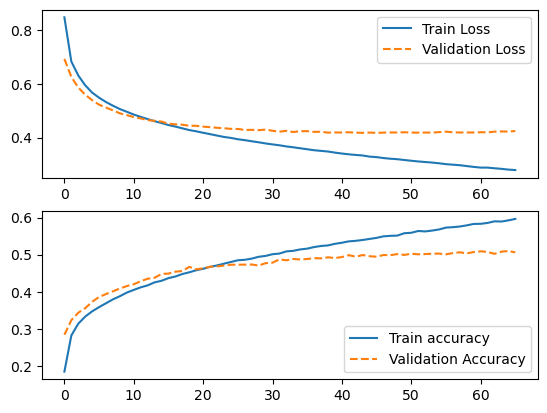

In [16]:
epoch_counter = range(len(history.history['loss']))
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(epoch_counter, history.history['loss'], label = 'Train Loss')
ax1.plot(epoch_counter, history.history['val_loss'], label = 'Validation Loss', linestyle = 'dashed')
ax1.legend()
ax2.plot(epoch_counter, history.history['acc'], label = 'Train accuracy')
ax2.plot(epoch_counter, history.history['val_acc'], label = 'Validation Accuracy', linestyle = 'dashed')
ax2.legend()

In [17]:
wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1 = evaluate(model_for_evaluation, input_texts_test, target_texts_test, input_word_index, target_word_index, inverted_target_word_index, input_pad_len, target_pad_len)
print('Results on test data:')
print('Word Error Rate: ', 100*wer) 
print('BLEU4(smooth): ', 100*smooth_bleu4) 
print('BLEU3(smooth): ', 100*smooth_bleu3) 
print('BLEU2(smooth): ', 100*smooth_bleu2) 
print('BLEU1(smooth): ', 100*smooth_bleu1) 

Results on test data:
Word Error Rate:  73.33331427648359
BLEU4(smooth):  16.87210507808429
BLEU3(smooth):  24.004787815065797
BLEU2(smooth):  34.18685209480099
BLEU1(smooth):  47.345965734969944


Nazalost dobijamo znatno gore performanse na test skupu nego pri unakrsnoj validaciji.

Neki primeri prevoda recenica iz test skupa:

In [18]:
n_examples = 3
starting_index = 38
translation_examples = translate_from_text(model_for_evaluation, input_texts_test[starting_index:starting_index + n_examples], input_word_index, target_word_index, inverted_target_word_index, input_pad_len, target_pad_len)
for i in range(n_examples):
    print('Originalna recenica:')
    print(input_texts_test[starting_index + i])
    print('Prevod:')
    print(translation_examples[i])
    print('Referenca:')
    print(df_test['orth'][starting_index + i])
    print('\n')

Originalna recenica:
und nun die wettervorhersage für morgen dienstag den dreizehnten oktober
Prevod:
JETZT WETTER WIE-AUSSEHEN MORGEN DIENSTAG VIERZEHN GRAD 
Referenca:
JETZT MORGEN WETTER WIE-AUSSEHEN DREIZEHN OKTOBER


Originalna recenica:
im westen ist es freundlich
Prevod:
WEST MEHR FREUNDLICH 
Referenca:
WEST FREUNDLICH


Originalna recenica:
ähnliches wetter dann auch am donnerstag
Prevod:
DONNERSTAG AUCH DASSELBE 
Referenca:
AUCH DONNERSTAG


